In [1]:
import load_data
import numpy as np
import torch as th
import torch.nn as nn
import pandas as pd
import PIL
import matplotlib.pyplot as plt

# Helper Functions

In [2]:
def true_params(cases, recovered, deaths, population):
    X = cases
    R = recovered + deaths

    n = np.array([population] * len(X), dtype=np.float64)

    S = n - X - R

    X_diff = np.array([X[:-1], X[1:]], dtype=np.float64).T
    R_diff = np.array([R[:-1], R[1:]], dtype=np.float64).T


    gamma = (R[1:] - R[:-1]) / (X[:-1])
    beta = n[:-1] * (X[1:] - X[:-1] + R[1:] - R[:-1]) / (X[:-1] * (n[:-1] - X[:-1] - R[:-1]))
    return np.nan_to_num(gamma), np.nan_to_num(beta)

In [3]:
def nan_to_num(t,mynan=0.):
    if th.all(th.isfinite(t)):
        return t
    if len(t.size()) == 0:
        return th.tensor(mynan)
    return th.cat([nan_to_num(l).unsqueeze(0) for l in t],0)

In [4]:
def my_msle(output, target):
    loss = th.mean(((output.add(1)).log() - (target.add(1)).log())**2)
    return loss

# Load Data

In [5]:
df = load_data.load_county_level(data_dir='data')
keys = df.keys()

loading county-level data...
loaded and merged COVID-19 cases/deaths data successfully


In [6]:
attr_cols = []

# Set the variable to True if we want to specify features ourselves.
use_specified_fields = False

if use_specified_fields:
    f = open("fields.txt", "r")
    fields = f.readlines()
    for field in fields:
        field = field.rstrip()
        arr = np.array(df[field])
        if arr.dtype == np.float32 or arr.dtype == np.float64:
            attr_cols.append(np.array(arr, dtype=np.float32))
else:
    for i in range(6, 86):
        arr = np.array(df[keys[i]])
        if arr.dtype == np.float32 or arr.dtype == np.float64:
            attr_cols.append(np.array(arr, dtype=np.float32))

attrs = th.tensor(np.stack(attr_cols, 1), dtype=th.float32)
cases = []
# for i in range(87, 216):
for i in range(132, 216):
    cases.append(np.array(df[keys[i]]))
cases = np.stack(cases, 1)
deaths = []
# for i in range(218, 347):
for i in range(263, 347):
    deaths.append(np.array(df[keys[i]]))
deaths = np.stack(deaths, 1)

pop = attrs[:,5]
pop = pop.view(3142, 1)
pop[1834] = 96471 #fixed the population value for Erie

In [7]:
gamma_lst = []
beta_lst = []
recovered = np.zeros(len(cases[0]))
for i in range(len(cases)):
    gamma, beta = true_params(cases[i], recovered, deaths[i], pop[i])
    gamma_lst.append(gamma)
    beta_lst.append(beta)
gamma_lst = np.nan_to_num(np.stack(gamma_lst,0))
beta_lst = np.nan_to_num(np.stack(beta_lst,0))

/home/ubuntu/.local/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]
/home/ubuntu/.local/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in true_divide
  
/home/ubuntu/.local/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  
/home/ubuntu/.local/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in true_divide
  del sys.path[0]


In [12]:
out_size = 1
num_days = cases.shape[1]
num_valid_days = 15
num_test_days = 15
train_valid_split = num_days - num_valid_days - num_test_days
valid_test_split = num_days - num_test_days
in_len = 20
out_len = 1

train_past_cases_1d = []
train_past_deaths_1d = []
train_past_gamma_1d = []
train_past_beta_1d = []
train_labels_cases_1d = []
train_labels_deaths_1d = []
train_labels_gamma_1d = []
train_labels_beta_1d = []

# for start in range(14):
#     end = start + in_len + out_len - 1
#     end_begin = end - out_len
#     train_past_cases_1d.append(th.tensor(cases[:,start:end_begin], dtype=th.float32))
#     train_past_deaths_1d.append(th.mul(th.tensor(deaths[:,start:end_begin], dtype=th.float32),1))
#     train_labels_cases_1d.append(th.tensor(cases[:,end_begin:end], dtype=th.float32))
#     train_labels_deaths_1d.append(th.mul(th.tensor(deaths[:,end_begin:end], dtype=th.float32),1))

# for start in range(14, train_valid_split - in_len - out_len + 1):
#     end = start + in_len + out_len - 1
#     end_begin = end - out_len
#     train_past_cases_1d.append(th.tensor(cases[:,start:end_begin], dtype=th.float32))
#     train_past_deaths_1d.append(th.mul(th.tensor(cases[:,start-14:end_begin-14], dtype=th.float32),1))
#     train_labels_cases_1d.append(th.tensor(cases[:,end_begin:end], dtype=th.float32))
#     train_labels_deaths_1d.append(th.mul(th.tensor(cases[:,end_begin-14:end-14], dtype=th.float32),1))

for start in range(train_valid_split - in_len - out_len + 1):
    end = start + in_len + out_len - 1
    end_begin = end - out_len
    train_past_cases_1d.append(th.tensor(cases[:,start:end_begin], dtype=th.float32))
    train_past_deaths_1d.append(th.tensor(deaths[:,start:end_begin], dtype=th.float32))
    train_past_gamma_1d.append(nan_to_num(th.tensor(gamma_lst[:,start:end_begin], dtype=th.float32),0))
    train_past_beta_1d.append(nan_to_num(th.tensor(beta_lst[:,start:end_begin], dtype=th.float32),0))
    train_labels_cases_1d.append(th.tensor(cases[:,end_begin:end], dtype=th.float32))
    train_labels_deaths_1d.append(th.tensor(deaths[:,end_begin:end], dtype=th.float32))
    train_labels_gamma_1d.append(nan_to_num(th.tensor(gamma_lst[:,end_begin:end], dtype=th.float32),0))
    train_labels_beta_1d.append(nan_to_num(th.tensor(beta_lst[:,end_begin:end], dtype=th.float32),0))


valid_past_cases_1d = []
valid_past_deaths_1d = []
valid_past_gamma_1d = []
valid_past_beta_1d = []
valid_labels_cases_1d = []
valid_labels_deaths_1d = []
valid_labels_gamma_1d = []
valid_labels_beta_1d = []
for start in range(train_valid_split - in_len - out_len + 1, valid_test_split - in_len - out_len):
    end = start + in_len + out_len - 1
    end_begin = end - out_len
    valid_past_cases_1d.append(th.tensor(cases[:,start:end_begin], dtype=th.float32))
    valid_past_deaths_1d.append(th.mul(th.tensor(deaths[:,start:end_begin], dtype=th.float32),1))
    valid_past_gamma_1d.append(nan_to_num(th.tensor(gamma_lst[:,start:end_begin], dtype=th.float32),0))
    valid_past_beta_1d.append(nan_to_num(th.tensor(beta_lst[:,start:end_begin], dtype=th.float32),0))
    valid_labels_cases_1d.append(th.tensor(cases[:,end_begin:end], dtype=th.float32))
    valid_labels_deaths_1d.append(th.mul(th.tensor(deaths[:,end_begin:end], dtype=th.float32),1))
    valid_labels_gamma_1d.append(nan_to_num(th.tensor(gamma_lst[:,end_begin:end], dtype=th.float32),0))
    valid_labels_beta_1d.append(nan_to_num(th.tensor(beta_lst[:,end_begin:end], dtype=th.float32),0))
    
test_past_cases_1d = []
test_past_deaths_1d = []
test_past_gamma_1d = []
test_past_beta_1d = []
test_labels_cases_1d = []
test_labels_deaths_1d = []
test_labels_gamma_1d = []
test_labels_beta_1d = []
for start in range(valid_test_split - in_len - out_len + 1, num_days - in_len - out_len):
    end = start + in_len + out_len - 1
    end_begin = end - out_len
    test_past_cases_1d.append(th.tensor(cases[:,start:end_begin], dtype=th.float32))
    test_past_deaths_1d.append(th.mul(th.tensor(deaths[:,start:end_begin], dtype=th.float32),1))
    test_past_gamma_1d.append(nan_to_num(th.tensor(gamma_lst[:,start:end_begin], dtype=th.float32),0))
    test_past_beta_1d.append(nan_to_num(th.tensor(beta_lst[:,start:end_begin], dtype=th.float32),0))
    test_labels_cases_1d.append(th.tensor(cases[:,end_begin:end], dtype=th.float32))
    test_labels_deaths_1d.append(th.mul(th.tensor(deaths[:,end_begin:end], dtype=th.float32),1))
    test_labels_gamma_1d.append(nan_to_num(th.tensor(gamma_lst[:,end_begin:end], dtype=th.float32),0))
    test_labels_beta_1d.append(nan_to_num(th.tensor(beta_lst[:,end_begin:end], dtype=th.float32),0))

In [18]:
train_labels_Sacramento = []
for i in range(34):
    train_labels_Sacramento.append(train_labels_cases_1d[i][202].cpu().numpy())

train_labels_NYC = []
for i in range(34):
    train_labels_NYC.append(train_labels_cases_1d[i][4].cpu().numpy())

train_gamma_Sacramento = []
for i in range(34):
    train_gamma_Sacramento.append(train_labels_gamma_1d[i][202].cpu().numpy())

train_gamma_NYC = []
for i in range(34):
    train_gamma_NYC.append(train_labels_gamma_1d[i][4].cpu().numpy())

train_beta_Sacramento = []
for i in range(34):
    train_beta_Sacramento.append(train_labels_beta_1d[i][202].cpu().numpy())

train_beta_NYC = []
for i in range(34):
    train_beta_NYC.append(train_labels_beta_1d[i][4].cpu().numpy())


valid_labels_Sacramento = []
for i in range(14):
    valid_labels_Sacramento.append(valid_labels_cases_1d[i][202].cpu().numpy())

valid_labels_NYC = []
for i in range(14):
    valid_labels_NYC.append(valid_labels_cases_1d[i][4].cpu().numpy())

valid_gamma_Sacramento = []
for i in range(14):
    valid_gamma_Sacramento.append(valid_labels_gamma_1d[i][202].cpu().numpy())

valid_gamma_NYC = []
for i in range(14):
    valid_gamma_NYC.append(valid_labels_gamma_1d[i][4].cpu().numpy())

valid_beta_Sacramento = []
for i in range(14):
    valid_beta_Sacramento.append(valid_labels_beta_1d[i][202].cpu().numpy())

valid_beta_NYC = []
for i in range(14):
    valid_beta_NYC.append(valid_labels_beta_1d[i][4].cpu().numpy())

# Models

## MLP - SIR

In [19]:
class Net_SIR(nn.Module):
    def __init__(self, input_size, hidden_size, out_size):
        super(Net_SIR, self).__init__()
        self.nn_model = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            #nn.BatchNorm1d(num_features=hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, out_size),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.nn_model(x)

In [20]:
def my_msle_ID(I, D, I_label, D_label):
    I_loss = ((I.add(1)).log() - (I_label.add(1)).log())**2
    D_loss = ((D.add(1)).log() - (D_label.add(1)).log())**2
    loss = th.mean(th.add(I_loss, D_loss))
    return loss

In [21]:
def sir_1d_output(params, I, D):
    gamma = params[:,0]
    beta = params[:,1]
    I[I != I] = 0.0
    D[D != D] = 0.0
    err = th.tensor([0],dtype=th.float)
    err = err.to(device)
    S = pop - I - D

    I_new = th.add(th.add(I, th.mul(beta.view(3142,1), th.div(th.mul(S,I), pop))), - th.mul(gamma.view(3142,1), I))
    D_new = th.add(D, th.mul(gamma.view(3142,1), I))

    return I_new, D_new

## GAT - SIR

### Contiguous Graph

In [22]:
county_names = df['CountyName']
county_code = np.array([int(code) for code in df['countyFIPS']])
county_code_dict = {code:idx for idx, code in enumerate(county_code)}

In [23]:
data_contiguous = pd.read_csv('/home/ubuntu/covid19-severity-prediction/data/neighborcounties.csv')
df_contiguous = pd.DataFrame(data_contiguous, columns= ['orgfips','adjfips','instate'])

In [24]:
import dgl

g = dgl.DGLGraph()
g.add_nodes(len(county_code_dict))
for ind in df_contiguous.index: 
    src = int(df_contiguous['orgfips'][ind])
    dst = int(df_contiguous['adjfips'][ind])
    if src in county_code_dict and dst in county_code_dict:
        g.add_edge(county_code_dict[src],county_code_dict[dst])

Using backend: pytorch


In [25]:
from dgl.nn import pytorch as dglnn
import torch.nn.functional as F
import torch.nn as nn

class GAT_SIR(nn.Module):
    def __init__(self, g, input_size, hidden_size, output_size, gcn_nlayers, num_heads=5):
        super(GAT_SIR, self).__init__()
        self.g = g
        self.gcn_layers = nn.ModuleList()
        self.gcn_layers.append(dglnn.conv.GATConv(input_size, hidden_size, num_heads=num_heads,
                                                  residual=True, activation=F.relu))
        for i in range(gcn_nlayers):
            self.gcn_layers.append(dglnn.conv.GATConv(num_heads * hidden_size, hidden_size, num_heads=num_heads,
                                                      residual=True, activation=F.relu))

        self.linear_layers = nn.Sequential(
            nn.Linear(num_heads * hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size),
            nn.Sigmoid()
        )

    def forward(self, x):
        h = x
        for layer in self.gcn_layers:
            h = layer(self.g, h).flatten(1)
        return self.linear_layers(h)

# Training

## MLP - SIR (loss = cases label)

In [26]:
hidden_size = 100
learning_rate = 0.0000005
num_epochs = 1000
batch_size = 1000
output_size = 2

device = th.device('cuda:0')
input_size = train_past_cases_1d[0].shape[1] + attrs.shape[1]
mlp_sir = Net_SIR(input_size, hidden_size, output_size)
print('#features:', input_size)

# Move model to GPU
mlp_sir = mlp_sir.to(device)

# Move data to GPU
pop = pop.to(device)
attrs = attrs.to(device)
for i in range(len(train_past_cases_1d)):
    train_past_cases_1d[i] = train_past_cases_1d[i].to(device)
    train_past_deaths_1d[i] = train_past_deaths_1d[i].to(device)
    train_labels_cases_1d[i] = train_labels_cases_1d[i].to(device)
    train_labels_deaths_1d[i] = train_labels_deaths_1d[i].to(device)
    if len(train_labels_cases_1d[i].shape) == 1:
        train_labels_cases_1d[i] = train_labels_cases_1d[i].unsqueeze(1)
    if len(train_labels_deaths_1d[i].shape) == 1:
        train_labels_deaths_1d[i] = train_labels_deaths_1d[i].unsqueeze(1)
        
for i in range(len(valid_past_cases_1d)):
    valid_past_cases_1d[i] = valid_past_cases_1d[i].to(device)
    valid_past_deaths_1d[i] = valid_past_deaths_1d[i].to(device)
    valid_labels_cases_1d[i] = valid_labels_cases_1d[i].to(device)
    valid_labels_deaths_1d[i] = valid_labels_deaths_1d[i].to(device)
    if len(valid_labels_cases_1d[i].shape) == 1:
         valid_labels_cases_1d[i] = valid_labels_cases_1d[i].unsqueeze(1)
    if len(test_labels_deaths_1d[i].shape) == 1:
        valid_labels_deaths_1d[i] = valid_labels_deaths_1d[i].unsqueeze(1)

for i in range(len(test_past_cases_1d)):
    test_past_cases_1d[i] = test_past_cases_1d[i].to(device)
    test_past_deaths_1d[i] = test_past_deaths_1d[i].to(device)
    test_labels_cases_1d[i] = test_labels_cases_1d[i].to(device)
    test_labels_deaths_1d[i] = test_labels_deaths_1d[i].to(device)
    if len(test_labels_cases_1d[i].shape) == 1:
        test_labels_cases_1d[i] = test_labels_cases_1d[i].unsqueeze(1)
    if len(test_labels_deaths_1d[i].shape) == 1:
        test_labels_deaths_1d[i] = test_labels_deaths_1d[i].unsqueeze(1)
        
# Normalize attrs
attrs[th.isnan(attrs)] = 0
attr_mean = th.mean(attrs, dim=1, keepdim=True)
attrs = attrs - attr_mean
attr_std = th.std(attrs, dim=1, keepdim=True)
attrs = attrs / attr_std

new_eval_err = 1000
optimizer = th.optim.Adam(mlp_sir.parameters(), lr=learning_rate)
for epoch in range(num_epochs):
    losses = []
    for idx in range(len(train_past_cases_1d)):
        labels_cases = train_labels_cases_1d[idx]
        labels_deaths = train_labels_deaths_1d[idx]
        batch = th.cat([train_past_cases_1d[idx], attrs], dim=1)
        vals = mlp_sir(batch)
        I = train_past_cases_1d[idx][:,-1].view(3142,1)
        D = train_past_deaths_1d[idx][:,-1].view(3142,1)
        I_new, D_new = sir_1d_output(vals, I, D)
        loss = my_msle_ID(I_new, D_new, labels_cases, labels_deaths)
        loss.backward(retain_graph=True)
        optimizer.step()
        losses.append(loss.detach().cpu().numpy())
    
    count = 0
    with th.no_grad():
        eval_errs = []
        test_errs = []
        test_mses = []
        test_maes = []
        for idx in range(14):
            valid_feats = th.cat([valid_past_cases_1d[idx], attrs], dim=1)
            eval_vals = mlp_sir(valid_feats)
            eval_I = valid_past_cases_1d[idx][:,-1].view(3142,1)
            eval_D = valid_past_deaths_1d[idx][:,-1].view(3142,1)
            eval_labels_cases = valid_labels_cases_1d[idx]
            eval_labels_deaths = valid_labels_deaths_1d[idx]
            eval_I_new, eval_D_new = sir_1d_output(eval_vals, eval_I, eval_D)
            err = my_msle_ID(eval_I_new, eval_D_new, eval_labels_cases, eval_labels_deaths)
            eval_errs.append(err.cpu().numpy())
            
            test_feats = th.cat([test_past_cases_1d[idx], attrs], dim=1)
            test_vals = mlp_sir(test_feats)
            test_I = test_past_cases_1d[idx][:,-1].view(3142,1)
            test_D = test_past_deaths_1d[idx][:,-1].view(3142,1)
            test_cases = test_labels_cases_1d[idx]
            test_deaths = test_labels_deaths_1d[idx]
            test_I_new, test_D_new = sir_1d_output(test_vals, test_I, test_D)
            test_err = my_msle_ID(test_I_new, test_D_new, test_cases, test_deaths)
            test_mse = th.mean((test_I_new - test_labels_cases_1d[idx])**2)
            test_mae = th.mean(th.abs(test_I_new - test_labels_cases_1d[idx]))
            test_errs.append(test_err.cpu().numpy())
            test_mses.append(test_mse.cpu().numpy())
            test_maes.append(test_mae.cpu().numpy())
        print('epoch={}, loss={:.3f}, validation loss = {:.3f}, test loss={:.3f}, test mse = {:.3f}, test mae = {:.3f}'.format(epoch, np.mean(losses), np.mean(eval_errs), np.mean(test_errs), np.mean(test_mses), np.mean(test_maes)))

#features: 97
epoch=0, loss=2.156, validation loss = 2.381, test loss=2.350, test mse = 7761224.000, test mae = 459.646
epoch=1, loss=2.132, validation loss = 2.347, test loss=2.316, test mse = 7761280.000, test mae = 459.871
epoch=2, loss=2.107, validation loss = 2.310, test loss=2.280, test mse = 7761336.000, test mae = 460.101
epoch=3, loss=2.081, validation loss = 2.274, test loss=2.244, test mse = 7761386.500, test mae = 460.324
epoch=4, loss=2.055, validation loss = 2.239, test loss=2.209, test mse = 7761434.500, test mae = 460.536
epoch=5, loss=2.031, validation loss = 2.205, test loss=2.174, test mse = 7761477.500, test mae = 460.737
epoch=6, loss=2.007, validation loss = 2.172, test loss=2.141, test mse = 7761516.500, test mae = 460.926
epoch=7, loss=1.983, validation loss = 2.140, test loss=2.109, test mse = 7761553.000, test mae = 461.105
epoch=8, loss=1.961, validation loss = 2.109, test loss=2.078, test mse = 7761584.500, test mae = 461.274
epoch=9, loss=1.939, validation 

epoch=78, loss=1.155, validation loss = 1.089, test loss=1.044, test mse = 7762085.000, test mae = 465.359
epoch=79, loss=1.149, validation loss = 1.081, test loss=1.037, test mse = 7762087.500, test mae = 465.386
epoch=80, loss=1.142, validation loss = 1.074, test loss=1.029, test mse = 7762089.000, test mae = 465.414
epoch=81, loss=1.135, validation loss = 1.066, test loss=1.022, test mse = 7762092.000, test mae = 465.441
epoch=82, loss=1.129, validation loss = 1.059, test loss=1.014, test mse = 7762093.500, test mae = 465.468
epoch=83, loss=1.122, validation loss = 1.051, test loss=1.007, test mse = 7762096.000, test mae = 465.495
epoch=84, loss=1.116, validation loss = 1.044, test loss=1.000, test mse = 7762098.500, test mae = 465.522
epoch=85, loss=1.109, validation loss = 1.036, test loss=0.993, test mse = 7762100.500, test mae = 465.548
epoch=86, loss=1.103, validation loss = 1.029, test loss=0.986, test mse = 7762101.500, test mae = 465.574
epoch=87, loss=1.096, validation loss

epoch=156, loss=0.758, validation loss = 0.669, test loss=0.642, test mse = 7762173.500, test mae = 466.667
epoch=157, loss=0.754, validation loss = 0.665, test loss=0.639, test mse = 7762173.500, test mae = 466.672
epoch=158, loss=0.750, validation loss = 0.662, test loss=0.635, test mse = 7762173.000, test mae = 466.678
epoch=159, loss=0.747, validation loss = 0.658, test loss=0.632, test mse = 7762173.000, test mae = 466.683
epoch=160, loss=0.743, validation loss = 0.654, test loss=0.629, test mse = 7762173.000, test mae = 466.688
epoch=161, loss=0.739, validation loss = 0.651, test loss=0.625, test mse = 7762173.000, test mae = 466.692
epoch=162, loss=0.735, validation loss = 0.647, test loss=0.622, test mse = 7762173.000, test mae = 466.697
epoch=163, loss=0.731, validation loss = 0.644, test loss=0.619, test mse = 7762172.500, test mae = 466.702
epoch=164, loss=0.728, validation loss = 0.640, test loss=0.615, test mse = 7762172.500, test mae = 466.706
epoch=165, loss=0.724, valid

epoch=232, loss=0.519, validation loss = 0.460, test loss=0.452, test mse = 7762141.500, test mae = 466.780
epoch=233, loss=0.517, validation loss = 0.458, test loss=0.451, test mse = 7762140.500, test mae = 466.777
epoch=234, loss=0.514, validation loss = 0.456, test loss=0.449, test mse = 7762139.500, test mae = 466.774
epoch=235, loss=0.511, validation loss = 0.454, test loss=0.447, test mse = 7762139.000, test mae = 466.771
epoch=236, loss=0.509, validation loss = 0.452, test loss=0.445, test mse = 7762137.000, test mae = 466.768
epoch=237, loss=0.507, validation loss = 0.450, test loss=0.444, test mse = 7762136.000, test mae = 466.764
epoch=238, loss=0.504, validation loss = 0.448, test loss=0.442, test mse = 7762135.000, test mae = 466.760
epoch=239, loss=0.502, validation loss = 0.446, test loss=0.440, test mse = 7762134.500, test mae = 466.756
epoch=240, loss=0.499, validation loss = 0.444, test loss=0.438, test mse = 7762133.000, test mae = 466.752
epoch=241, loss=0.497, valid

epoch=308, loss=0.355, validation loss = 0.333, test loss=0.343, test mse = 7761919.000, test mae = 465.736
epoch=309, loss=0.353, validation loss = 0.332, test loss=0.342, test mse = 7761912.000, test mae = 465.703
epoch=310, loss=0.351, validation loss = 0.331, test loss=0.341, test mse = 7761904.500, test mae = 465.670
epoch=311, loss=0.350, validation loss = 0.329, test loss=0.340, test mse = 7761897.000, test mae = 465.636
epoch=312, loss=0.348, validation loss = 0.328, test loss=0.338, test mse = 7761890.500, test mae = 465.601
epoch=313, loss=0.346, validation loss = 0.326, test loss=0.337, test mse = 7761881.000, test mae = 465.565
epoch=314, loss=0.344, validation loss = 0.325, test loss=0.336, test mse = 7761873.000, test mae = 465.529
epoch=315, loss=0.342, validation loss = 0.324, test loss=0.335, test mse = 7761864.500, test mae = 465.491
epoch=316, loss=0.340, validation loss = 0.322, test loss=0.334, test mse = 7761855.500, test mae = 465.452
epoch=317, loss=0.339, valid

epoch=384, loss=0.211, validation loss = 0.207, test loss=0.229, test mse = 7740986.500, test mae = 445.873
epoch=385, loss=0.209, validation loss = 0.204, test loss=0.226, test mse = 7738335.000, test mae = 444.226
epoch=386, loss=0.207, validation loss = 0.201, test loss=0.223, test mse = 7734860.500, test mae = 442.397
epoch=387, loss=0.205, validation loss = 0.197, test loss=0.220, test mse = 7730014.500, test mae = 440.254
epoch=388, loss=0.203, validation loss = 0.194, test loss=0.216, test mse = 7721563.500, test mae = 437.541
epoch=389, loss=0.201, validation loss = 0.190, test loss=0.213, test mse = 7710154.500, test mae = 434.071
epoch=390, loss=0.199, validation loss = 0.186, test loss=0.209, test mse = 7699279.000, test mae = 430.276
epoch=391, loss=0.197, validation loss = 0.182, test loss=0.205, test mse = 7684291.500, test mae = 426.034
epoch=392, loss=0.195, validation loss = 0.177, test loss=0.201, test mse = 7664867.000, test mae = 420.805
epoch=393, loss=0.193, valid

epoch=462, loss=0.118, validation loss = 0.071, test loss=0.061, test mse = 1614.483, test mae = 10.178
epoch=463, loss=0.117, validation loss = 0.070, test loss=0.061, test mse = 1613.631, test mae = 10.125
epoch=464, loss=0.116, validation loss = 0.070, test loss=0.060, test mse = 1612.816, test mae = 10.074
epoch=465, loss=0.116, validation loss = 0.069, test loss=0.060, test mse = 1612.035, test mae = 10.023
epoch=466, loss=0.115, validation loss = 0.069, test loss=0.059, test mse = 1611.287, test mae = 9.974
epoch=467, loss=0.114, validation loss = 0.068, test loss=0.059, test mse = 1610.570, test mae = 9.927
epoch=468, loss=0.113, validation loss = 0.067, test loss=0.058, test mse = 1609.881, test mae = 9.880
epoch=469, loss=0.113, validation loss = 0.067, test loss=0.058, test mse = 1609.221, test mae = 9.835
epoch=470, loss=0.112, validation loss = 0.066, test loss=0.057, test mse = 1608.586, test mae = 9.790
epoch=471, loss=0.111, validation loss = 0.066, test loss=0.057, test

epoch=542, loss=0.074, validation loss = 0.040, test loss=0.034, test mse = 1591.734, test mae = 8.124
epoch=543, loss=0.073, validation loss = 0.040, test loss=0.033, test mse = 1591.660, test mae = 8.112
epoch=544, loss=0.073, validation loss = 0.040, test loss=0.033, test mse = 1591.587, test mae = 8.100
epoch=545, loss=0.072, validation loss = 0.039, test loss=0.033, test mse = 1591.516, test mae = 8.088
epoch=546, loss=0.072, validation loss = 0.039, test loss=0.033, test mse = 1591.447, test mae = 8.076
epoch=547, loss=0.072, validation loss = 0.039, test loss=0.033, test mse = 1591.379, test mae = 8.065
epoch=548, loss=0.071, validation loss = 0.039, test loss=0.032, test mse = 1591.312, test mae = 8.053
epoch=549, loss=0.071, validation loss = 0.039, test loss=0.032, test mse = 1591.247, test mae = 8.042
epoch=550, loss=0.071, validation loss = 0.038, test loss=0.032, test mse = 1591.183, test mae = 8.031
epoch=551, loss=0.070, validation loss = 0.038, test loss=0.032, test mse

epoch=622, loss=0.052, validation loss = 0.026, test loss=0.021, test mse = 1588.785, test mae = 7.485
epoch=623, loss=0.052, validation loss = 0.026, test loss=0.021, test mse = 1588.769, test mae = 7.480
epoch=624, loss=0.052, validation loss = 0.026, test loss=0.021, test mse = 1588.755, test mae = 7.475
epoch=625, loss=0.052, validation loss = 0.026, test loss=0.021, test mse = 1588.740, test mae = 7.470
epoch=626, loss=0.051, validation loss = 0.026, test loss=0.021, test mse = 1588.726, test mae = 7.465
epoch=627, loss=0.051, validation loss = 0.026, test loss=0.021, test mse = 1588.712, test mae = 7.460
epoch=628, loss=0.051, validation loss = 0.026, test loss=0.021, test mse = 1588.698, test mae = 7.455
epoch=629, loss=0.051, validation loss = 0.025, test loss=0.021, test mse = 1588.684, test mae = 7.451
epoch=630, loss=0.051, validation loss = 0.025, test loss=0.021, test mse = 1588.671, test mae = 7.446
epoch=631, loss=0.051, validation loss = 0.025, test loss=0.020, test mse

epoch=702, loss=0.042, validation loss = 0.019, test loss=0.015, test mse = 1588.147, test mae = 7.204
epoch=703, loss=0.042, validation loss = 0.019, test loss=0.015, test mse = 1588.144, test mae = 7.202
epoch=704, loss=0.042, validation loss = 0.019, test loss=0.015, test mse = 1588.140, test mae = 7.200
epoch=705, loss=0.042, validation loss = 0.019, test loss=0.015, test mse = 1588.137, test mae = 7.197
epoch=706, loss=0.042, validation loss = 0.019, test loss=0.015, test mse = 1588.134, test mae = 7.195
epoch=707, loss=0.042, validation loss = 0.019, test loss=0.015, test mse = 1588.131, test mae = 7.193
epoch=708, loss=0.042, validation loss = 0.019, test loss=0.015, test mse = 1588.127, test mae = 7.191
epoch=709, loss=0.042, validation loss = 0.018, test loss=0.015, test mse = 1588.124, test mae = 7.188
epoch=710, loss=0.042, validation loss = 0.018, test loss=0.015, test mse = 1588.121, test mae = 7.186
epoch=711, loss=0.042, validation loss = 0.018, test loss=0.014, test mse

epoch=782, loss=0.038, validation loss = 0.015, test loss=0.011, test mse = 1588.004, test mae = 7.069
epoch=783, loss=0.038, validation loss = 0.015, test loss=0.011, test mse = 1588.003, test mae = 7.068
epoch=784, loss=0.038, validation loss = 0.015, test loss=0.011, test mse = 1588.003, test mae = 7.067
epoch=785, loss=0.038, validation loss = 0.015, test loss=0.011, test mse = 1588.002, test mae = 7.066
epoch=786, loss=0.038, validation loss = 0.015, test loss=0.011, test mse = 1588.001, test mae = 7.065
epoch=787, loss=0.038, validation loss = 0.015, test loss=0.011, test mse = 1588.001, test mae = 7.064
epoch=788, loss=0.038, validation loss = 0.015, test loss=0.011, test mse = 1588.000, test mae = 7.063
epoch=789, loss=0.038, validation loss = 0.015, test loss=0.011, test mse = 1587.999, test mae = 7.061
epoch=790, loss=0.038, validation loss = 0.015, test loss=0.011, test mse = 1587.999, test mae = 7.060
epoch=791, loss=0.037, validation loss = 0.015, test loss=0.011, test mse

epoch=862, loss=0.036, validation loss = 0.013, test loss=0.010, test mse = 1587.980, test mae = 6.999
epoch=863, loss=0.036, validation loss = 0.013, test loss=0.010, test mse = 1587.980, test mae = 6.998
epoch=864, loss=0.036, validation loss = 0.013, test loss=0.010, test mse = 1587.980, test mae = 6.998
epoch=865, loss=0.036, validation loss = 0.013, test loss=0.010, test mse = 1587.980, test mae = 6.997
epoch=866, loss=0.036, validation loss = 0.013, test loss=0.010, test mse = 1587.980, test mae = 6.996
epoch=867, loss=0.036, validation loss = 0.013, test loss=0.010, test mse = 1587.980, test mae = 6.996
epoch=868, loss=0.036, validation loss = 0.013, test loss=0.010, test mse = 1587.980, test mae = 6.995
epoch=869, loss=0.036, validation loss = 0.012, test loss=0.010, test mse = 1587.980, test mae = 6.995
epoch=870, loss=0.035, validation loss = 0.012, test loss=0.010, test mse = 1587.980, test mae = 6.994
epoch=871, loss=0.035, validation loss = 0.012, test loss=0.009, test mse

epoch=942, loss=0.035, validation loss = 0.012, test loss=0.009, test mse = 1587.984, test mae = 6.960
epoch=943, loss=0.035, validation loss = 0.012, test loss=0.009, test mse = 1587.984, test mae = 6.959
epoch=944, loss=0.035, validation loss = 0.012, test loss=0.009, test mse = 1587.984, test mae = 6.959
epoch=945, loss=0.035, validation loss = 0.012, test loss=0.009, test mse = 1587.984, test mae = 6.959
epoch=946, loss=0.035, validation loss = 0.012, test loss=0.009, test mse = 1587.984, test mae = 6.958
epoch=947, loss=0.035, validation loss = 0.012, test loss=0.009, test mse = 1587.984, test mae = 6.958
epoch=948, loss=0.035, validation loss = 0.012, test loss=0.009, test mse = 1587.984, test mae = 6.957
epoch=949, loss=0.035, validation loss = 0.012, test loss=0.009, test mse = 1587.984, test mae = 6.957
epoch=950, loss=0.035, validation loss = 0.012, test loss=0.009, test mse = 1587.984, test mae = 6.957
epoch=951, loss=0.035, validation loss = 0.012, test loss=0.009, test mse

In [28]:
with th.no_grad():
    mlp1dc_trainp_R0_NYC = []
    mlp1dc_trainp_R0_Sacramento = []
    mlp1dc_trainp_gamma_NYC = []
    mlp1dc_trainp_beta_NYC = []
    mlp1dc_trainp_gamma_Sacramento = []
    mlp1dc_trainp_beta_Sacramento = []
    mlp1dc_trainp_case_vals = []
    mlp1dc_trainp_death_vals = []
    for idx in range(len(train_past_cases_1d)):
        labels = train_labels_cases_1d[idx]
        batch = th.cat([train_past_cases_1d[idx], attrs], dim=1)
        vals = mlp_sir(batch)
        mlp1dc_trainp_gamma_NYC.append(vals[4][0])
        mlp1dc_trainp_gamma_Sacramento.append(vals[202][0])
        mlp1dc_trainp_beta_NYC.append(vals[4][1])
        mlp1dc_trainp_beta_Sacramento.append(vals[202][1])
        R_NYC_div = th.div(vals[4][1],vals[4][0])
        R_Sacramento_div = th.div(vals[202][1],vals[202][0])
        mlp1dc_trainp_R0_NYC.append(R_NYC_div)
        mlp1dc_trainp_R0_Sacramento.append(R_Sacramento_div)  
        I = train_past_cases_1d[idx][:,-1].view(3142,1)
        D = train_past_deaths_1d[idx][:,-1].view(3142,1)
        I_new, D_new = sir_1d_output(vals, I, D)
        mlp1dc_trainp_case_vals.append(I_new)
        mlp1dc_trainp_death_vals.append(D_new)

    mlp1dc_validp_R0_NYC = []
    mlp1dc_validp_R0_Sacramento = []
    mlp1dc_validp_gamma_NYC = []
    mlp1dc_validp_beta_NYC = []
    mlp1dc_validp_gamma_Sacramento = []
    mlp1dc_validp_beta_Sacramento = []
    mlp1dc_validp_case_vals = []
    mlp1dc_validp_death_vals = []
    for idx in range(14):
        labels = valid_labels_cases_1d[idx]
        batch = th.cat([valid_past_cases_1d[idx], attrs], dim=1)
        vals = mlp_sir(batch)
        mlp1dc_validp_gamma_NYC.append(vals[4][0])
        mlp1dc_validp_gamma_Sacramento.append(vals[202][0])
        mlp1dc_validp_beta_NYC.append(vals[4][1])
        mlp1dc_validp_beta_Sacramento.append(vals[202][1])
        R_NYC_div = th.div(vals[4][1],vals[4][0])
        R_Sacramento_div = th.div(vals[202][1],vals[202][0])
        mlp1dc_validp_R0_NYC.append(R_NYC_div)
        mlp1dc_validp_R0_Sacramento.append(R_Sacramento_div)  
        I = train_past_cases_1d[idx][:,-1].view(3142,1)
        D = train_past_deaths_1d[idx][:,-1].view(3142,1)
        I_new, D_new = sir_1d_output(vals, I, D)
        mlp1dc_validp_case_vals.append(I_new)
        mlp1dc_validp_death_vals.append(D_new)

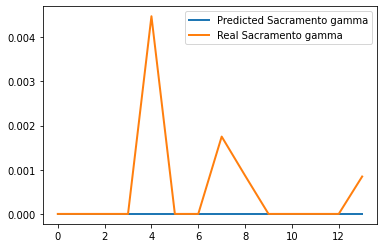

In [29]:
x = range(14)
y1 = mlp1dc_validp_gamma_Sacramento
y2 = valid_gamma_Sacramento
plt.plot(x, y1, ls="-", lw=2, label="Predicted Sacramento gamma")
plt.plot(x, y2, ls="-", lw=2, label="Real Sacramento gamma")
plt.legend()
plt.show()

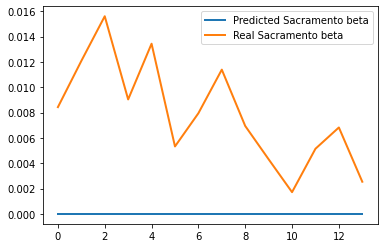

In [30]:
x = range(14)
y1 = mlp1dc_validp_beta_Sacramento
y2 = valid_beta_Sacramento
plt.plot(x, y1, ls="-", lw=2, label="Predicted Sacramento beta")
plt.plot(x, y2, ls="-", lw=2, label="Real Sacramento beta")
plt.legend()
plt.show()

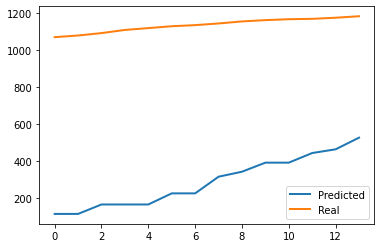

In [42]:
pred_vals = []
for i in range(14):
    pred_vals.append(mlp1dc_validp_case_vals[i][202])

x = range(14)
y1 = pred_vals
y2 = valid_labels_Sacramento
plt.plot(x, y1, ls="-", lw=2, label="Predicted")
plt.plot(x, y2, ls="-", lw=2, label="Real")
plt.legend()
plt.show()

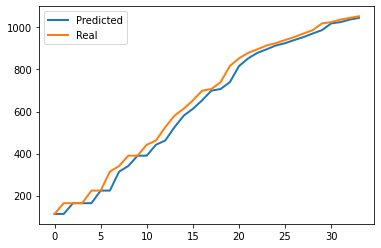

In [43]:
pred_vals = []
for i in range(34):
    pred_vals.append(mlp1dc_trainp_case_vals[i][202])

x = range(34)
y1 = pred_vals
y2 = train_labels_Sacramento
plt.plot(x, y1, ls="-", lw=2, label="Predicted")
plt.plot(x, y2, ls="-", lw=2, label="Real")
plt.legend()
plt.show()

## MLP - SIR (loss = params)

In [52]:
# For debugging
hidden_size = 100
learning_rate = 0.00000005
num_epochs = 1000
batch_size = 1000
output_size = 2

device = th.device('cuda:0')
input_size = train_past_cases_1d[0].shape[1] + attrs.shape[1]
mlp_sir = Net_SIR(input_size, hidden_size, output_size)
# Move model to GPU
mlp_sir = mlp_sir.to(device)

optimizer = th.optim.Adam(mlp_sir.parameters(), lr=learning_rate)

idx = 0
batch = th.cat([train_past_cases_1d[idx], attrs], dim=1)
vals = mlp_sir(batch)
loss = th.mean(100*(train_labels_gamma_1d[idx] - vals[:,0].view(3142,1))**2 + (train_labels_beta_1d[idx] - vals[:,1].view(3142,1))**2)

#features: 97


In [44]:
hidden_size = 100
learning_rate = 0.00000005
num_epochs = 10000
batch_size = 1000
output_size = 2

device = th.device('cuda:0')
input_size = train_past_cases_1d[0].shape[1] + attrs.shape[1]
mlp_sir = Net_SIR(input_size, hidden_size, output_size)
print('#features:', input_size)

# Move model to GPU
mlp_sir = mlp_sir.to(device)

# Move data to GPU
pop = pop.to(device)
attrs = attrs.to(device)
for i in range(len(train_past_cases_1d)):
    train_past_cases_1d[i] = train_past_cases_1d[i].to(device)
    train_past_deaths_1d[i] = train_past_deaths_1d[i].to(device)
    train_past_gamma_1d[i] = train_past_gamma_1d[i].to(device)
    train_past_beta_1d[i] = train_past_beta_1d[i].to(device)
    train_labels_cases_1d[i] = train_labels_cases_1d[i].to(device)
    train_labels_deaths_1d[i] = train_labels_deaths_1d[i].to(device)
    train_labels_gamma_1d[i] = train_labels_gamma_1d[i].to(device)
    train_labels_beta_1d[i] = train_labels_beta_1d[i].to(device)
    if len(train_labels_cases_1d[i].shape) == 1:
        train_labels_cases_1d[i] = train_labels_cases_1d[i].unsqueeze(1)
    if len(train_labels_deaths_1d[i].shape) == 1:
        train_labels_deaths_1d[i] = train_labels_deaths_1d[i].unsqueeze(1)
    if len(train_labels_gamma_1d[i].shape) == 1:
        train_labels_gamma_1d[i] = train_labels_gamma_1d[i].unsqueeze(1)
    if len(train_labels_beta_1d[i].shape) == 1:
        train_labels_beta_1d[i] = train_labels_beta_1d[i].unsqueeze(1)
        
for i in range(len(valid_past_cases_1d)):
    valid_past_cases_1d[i] = valid_past_cases_1d[i].to(device)
    valid_past_deaths_1d[i] = valid_past_deaths_1d[i].to(device)
    valid_past_gamma_1d[i] = valid_past_gamma_1d[i].to(device)
    valid_past_beta_1d[i] = valid_past_beta_1d[i].to(device)
    valid_labels_cases_1d[i] = valid_labels_cases_1d[i].to(device)
    valid_labels_deaths_1d[i] = valid_labels_deaths_1d[i].to(device)
    valid_labels_gamma_1d[i] = valid_labels_gamma_1d[i].to(device)
    valid_labels_beta_1d[i] = valid_labels_beta_1d[i].to(device)
    if len(valid_labels_cases_1d[i].shape) == 1:
         valid_labels_cases_1d[i] = valid_labels_cases_1d[i].unsqueeze(1)
    if len(test_labels_deaths_1d[i].shape) == 1:
        valid_labels_deaths_1d[i] = valid_labels_deaths_1d[i].unsqueeze(1)
    if len(valid_labels_gamma_1d[i].shape) == 1:
         valid_labels_gamma_1d[i] = valid_labels_gamma_1d[i].unsqueeze(1)
    if len(test_labels_beta_1d[i].shape) == 1:
        valid_labels_beta_1d[i] = valid_labels_beta_1d[i].unsqueeze(1)

for i in range(len(test_past_cases_1d)):
    test_past_cases_1d[i] = test_past_cases_1d[i].to(device)
    test_past_deaths_1d[i] = test_past_deaths_1d[i].to(device)
    test_past_gamma_1d[i] = test_past_gamma_1d[i].to(device)
    test_past_beta_1d[i] = test_past_beta_1d[i].to(device)
    test_labels_cases_1d[i] = test_labels_cases_1d[i].to(device)
    test_labels_deaths_1d[i] = test_labels_deaths_1d[i].to(device)
    test_labels_gamma_1d[i] = test_labels_gamma_1d[i].to(device)
    test_labels_beta_1d[i] = test_labels_beta_1d[i].to(device)
    if len(test_labels_cases_1d[i].shape) == 1:
        test_labels_cases_1d[i] = test_labels_cases_1d[i].unsqueeze(1)
    if len(test_labels_deaths_1d[i].shape) == 1:
        test_labels_deaths_1d[i] = test_labels_deaths_1d[i].unsqueeze(1)
    if len(test_labels_gamma_1d[i].shape) == 1:
        test_labels_gamma_1d[i] = test_labels_gamma_1d[i].unsqueeze(1)
    if len(test_labels_beta_1d[i].shape) == 1:
        test_labels_beta_1d[i] = test_labels_beta_1d[i].unsqueeze(1)
        
# Normalize attrs
attrs[th.isnan(attrs)] = 0
attr_mean = th.mean(attrs, dim=1, keepdim=True)
attrs = attrs - attr_mean
attr_std = th.std(attrs, dim=1, keepdim=True)
attrs = attrs / attr_std


optimizer = th.optim.Adam(mlp_sir.parameters(), lr=learning_rate)
for epoch in range(num_epochs):
    losses = []
    for idx in range(len(train_past_cases_1d)):
        batch = th.cat([train_past_cases_1d[idx], attrs], dim=1)
        vals = mlp_sir(batch)
        loss = th.mean(100000*(train_labels_gamma_1d[idx] - vals[:,0])**2 + (train_labels_beta_1d[idx] - vals[:,1])**2)
        loss.backward(retain_graph=True)
        optimizer.step()
        losses.append(loss.detach().cpu().numpy())
    
    count = 0
    with th.no_grad():
        eval_loss1 = []
        eval_errs = []
        test_loss1 = []
        test_errs = []
        test_mses = []
        test_maes = []
        for idx in range(14):
            valid_feats = th.cat([valid_past_cases_1d[idx], attrs], dim=1)
            eval_vals = mlp_sir(valid_feats)
            eval_I = valid_past_cases_1d[idx][:,-1].view(3142,1)
            eval_D = valid_past_deaths_1d[idx][:,-1].view(3142,1)
            eval_labels_cases = valid_labels_cases_1d[idx]
            eval_labels_deaths = valid_labels_deaths_1d[idx]
            eval_I_new, eval_D_new = sir_1d_output(eval_vals, eval_I, eval_D)
            err = my_msle_ID(eval_I_new, eval_D_new, eval_labels_cases, eval_labels_deaths)
            eval_loss = th.mean(100000*(valid_labels_gamma_1d[idx] - eval_vals[:,0])**2 + (valid_labels_beta_1d[idx] - eval_vals[:,1])**2)
            eval_errs.append(err.cpu().numpy())
            eval_loss1.append(eval_loss.cpu().numpy())
            
            test_feats = th.cat([test_past_cases_1d[idx], attrs], dim=1)
            test_vals = mlp_sir(test_feats)
            test_I = test_past_cases_1d[idx][:,-1].view(3142,1)
            test_D = test_past_deaths_1d[idx][:,-1].view(3142,1)
            test_cases = test_labels_cases_1d[idx]
            test_deaths = test_labels_deaths_1d[idx]
            test_I_new, test_D_new = sir_1d_output(test_vals, test_I, test_D)
            test_err = my_msle_ID(test_I_new, test_D_new, test_cases, test_deaths)
            test_mse = th.mean((test_I_new - test_labels_cases_1d[idx])**2)
            test_mae = th.mean(th.abs(test_I_new - test_labels_cases_1d[idx]))
            test_errs.append(test_err.cpu().numpy())
            test_mses.append(test_mse.cpu().numpy())
            test_maes.append(test_mae.cpu().numpy())
            test_loss = th.mean(100000*(test_labels_gamma_1d[idx] - test_vals[:,0])**2 + (test_labels_beta_1d[idx] - test_vals[:,1])**2)
            test_loss1.append(test_loss.cpu().numpy())
        print('epoch={}, loss={:.3f}, validation loss = {:.3f}, test loss={:.3f}, test mse = {:.3f}, test mae = {:.3f}'.format(epoch, np.mean(losses), np.mean(eval_loss1), np.mean(test_loss1), np.mean(test_mses), np.mean(test_maes)))

#features: 97
epoch=0, loss=30806.602, validation loss = 43249.566, test loss=48534.152, test mse = 8248.208, test mae = 13.806
epoch=1, loss=30775.721, validation loss = 43201.941, test loss=48483.469, test mse = 8248.126, test mae = 13.808
epoch=2, loss=30740.020, validation loss = 43149.930, test loss=48428.074, test mse = 8248.046, test mae = 13.810
epoch=3, loss=30702.203, validation loss = 43095.508, test loss=48370.113, test mse = 8247.975, test mae = 13.814
epoch=4, loss=30663.088, validation loss = 43040.020, test loss=48311.012, test mse = 8247.915, test mae = 13.819
epoch=5, loss=30623.246, validation loss = 42983.988, test loss=48251.301, test mse = 8247.869, test mae = 13.824
epoch=6, loss=30582.932, validation loss = 42927.562, test loss=48191.156, test mse = 8247.834, test mae = 13.830
epoch=7, loss=30542.248, validation loss = 42870.840, test loss=48130.660, test mse = 8247.813, test mae = 13.838
epoch=8, loss=30501.242, validation loss = 42813.832, test loss=48069.816,

epoch=72, loss=27765.199, validation loss = 38880.699, test loss=43799.105, test mse = 8320.019, test mae = 16.178
epoch=73, loss=27724.180, validation loss = 38815.375, test loss=43727.055, test mse = 8323.337, test mae = 16.240
epoch=74, loss=27683.262, validation loss = 38749.871, test loss=43654.785, test mse = 8326.765, test mae = 16.302
epoch=75, loss=27642.367, validation loss = 38684.211, test loss=43582.305, test mse = 8330.303, test mae = 16.365
epoch=76, loss=27601.424, validation loss = 38618.355, test loss=43509.590, test mse = 8333.952, test mae = 16.429
epoch=77, loss=27560.400, validation loss = 38552.344, test loss=43436.637, test mse = 8337.719, test mae = 16.493
epoch=78, loss=27519.307, validation loss = 38486.121, test loss=43363.441, test mse = 8341.606, test mae = 16.558
epoch=79, loss=27478.172, validation loss = 38419.680, test loss=43289.961, test mse = 8345.618, test mae = 16.625
epoch=80, loss=27437.016, validation loss = 38353.000, test loss=43216.180, test

epoch=143, loss=24811.297, validation loss = 33522.621, test loss=37750.633, test mse = 9418.439, test mae = 23.946
epoch=144, loss=24769.490, validation loss = 33433.641, test loss=37646.832, test mse = 9477.283, test mae = 24.139
epoch=145, loss=24727.992, validation loss = 33344.184, test loss=37542.316, test mse = 9540.162, test mae = 24.336
epoch=146, loss=24686.635, validation loss = 33254.258, test loss=37437.082, test mse = 9607.286, test mae = 24.537
epoch=147, loss=24645.156, validation loss = 33163.848, test loss=37331.082, test mse = 9678.860, test mae = 24.743
epoch=148, loss=24603.412, validation loss = 33072.941, test loss=37224.316, test mse = 9754.991, test mae = 24.951
epoch=149, loss=24561.453, validation loss = 32981.523, test loss=37116.762, test mse = 9835.721, test mae = 25.167
epoch=150, loss=24519.627, validation loss = 32889.598, test loss=37008.430, test mse = 9921.127, test mae = 25.392
epoch=151, loss=24478.104, validation loss = 32797.137, test loss=36899.

epoch=214, loss=21794.547, validation loss = 24448.053, test loss=26823.812, test mse = 113350.867, test mae = 80.967
epoch=215, loss=21750.328, validation loss = 24248.012, test loss=26544.127, test mse = 178749.047, test mae = 86.699
epoch=216, loss=21706.109, validation loss = 24045.908, test loss=26258.467, test mse = 240477.281, test mae = 92.752
epoch=217, loss=21661.645, validation loss = 23846.770, test loss=25966.760, test mse = 301976.812, test mae = 99.242
epoch=218, loss=21616.404, validation loss = 23649.334, test loss=25663.115, test mse = 502633.812, test mae = 109.805
epoch=219, loss=21570.219, validation loss = 23451.455, test loss=25359.082, test mse = 794585.188, test mae = 121.307
epoch=220, loss=21524.230, validation loss = 23253.375, test loss=25057.387, test mse = 1057922.125, test mae = 131.891
epoch=221, loss=21477.596, validation loss = 23058.354, test loss=24758.002, test mse = 1208577.375, test mae = 141.159
epoch=222, loss=21431.172, validation loss = 22865

epoch=283, loss=20115.182, validation loss = 18281.355, test loss=17414.914, test mse = 7750311.000, test mae = 440.861
epoch=284, loss=20100.756, validation loss = 18246.297, test loss=17370.852, test mse = 7750573.500, test mae = 441.106
epoch=285, loss=20086.414, validation loss = 18211.596, test loss=17327.309, test mse = 7750827.000, test mae = 441.345
epoch=286, loss=20072.160, validation loss = 18177.244, test loss=17284.277, test mse = 7751069.500, test mae = 441.579
epoch=287, loss=20057.992, validation loss = 18143.240, test loss=17241.744, test mse = 7751307.000, test mae = 441.807
epoch=288, loss=20043.916, validation loss = 18109.586, test loss=17199.707, test mse = 7751533.500, test mae = 442.030
epoch=289, loss=20029.918, validation loss = 18076.256, test loss=17158.143, test mse = 7751751.500, test mae = 442.249
epoch=290, loss=20015.998, validation loss = 18043.252, test loss=17117.043, test mse = 7751962.500, test mae = 442.463
epoch=291, loss=20002.164, validation lo

epoch=352, loss=19268.689, validation loss = 16423.283, test loss=15173.432, test mse = 7758024.500, test mae = 450.541
epoch=353, loss=19258.041, validation loss = 16402.031, test loss=15148.845, test mse = 7758068.500, test mae = 450.623
epoch=354, loss=19247.428, validation loss = 16380.894, test loss=15124.409, test mse = 7758112.000, test mae = 450.704
epoch=355, loss=19236.848, validation loss = 16359.873, test loss=15100.123, test mse = 7758154.500, test mae = 450.783
epoch=356, loss=19226.301, validation loss = 16338.960, test loss=15075.986, test mse = 7758196.000, test mae = 450.862
epoch=357, loss=19215.789, validation loss = 16318.157, test loss=15051.995, test mse = 7758237.000, test mae = 450.940
epoch=358, loss=19205.311, validation loss = 16297.466, test loss=15028.150, test mse = 7758277.500, test mae = 451.017
epoch=359, loss=19194.867, validation loss = 16276.884, test loss=15004.451, test mse = 7758317.000, test mae = 451.094
epoch=360, loss=19184.457, validation lo

epoch=421, loss=18601.150, validation loss = 15171.476, test loss=13759.110, test mse = 7759874.500, test mae = 454.618
epoch=422, loss=18592.312, validation loss = 15155.911, test loss=13741.939, test mse = 7759890.500, test mae = 454.661
epoch=423, loss=18583.490, validation loss = 15140.407, test loss=13724.845, test mse = 7759906.500, test mae = 454.703
epoch=424, loss=18574.689, validation loss = 15124.962, test loss=13707.822, test mse = 7759921.000, test mae = 454.745
epoch=425, loss=18565.908, validation loss = 15109.580, test loss=13690.873, test mse = 7759936.000, test mae = 454.787
epoch=426, loss=18557.148, validation loss = 15094.252, test loss=13673.999, test mse = 7759951.000, test mae = 454.828
epoch=427, loss=18548.406, validation loss = 15078.984, test loss=13657.195, test mse = 7759965.000, test mae = 454.869
epoch=428, loss=18539.688, validation loss = 15063.773, test loss=13640.463, test mse = 7759980.000, test mae = 454.910
epoch=429, loss=18530.982, validation lo

epoch=490, loss=18032.988, validation loss = 14217.271, test loss=12722.688, test mse = 7760633.000, test mae = 456.949
epoch=491, loss=18025.309, validation loss = 14204.970, test loss=12709.539, test mse = 7760640.000, test mae = 456.976
epoch=492, loss=18017.641, validation loss = 14192.706, test loss=12696.435, test mse = 7760648.000, test mae = 457.002
epoch=493, loss=18009.984, validation loss = 14180.479, test loss=12683.375, test mse = 7760655.000, test mae = 457.029
epoch=494, loss=18002.346, validation loss = 14168.290, test loss=12670.357, test mse = 7760661.500, test mae = 457.055
epoch=495, loss=17994.721, validation loss = 14156.140, test loss=12657.388, test mse = 7760669.000, test mae = 457.081
epoch=496, loss=17987.109, validation loss = 14144.024, test loss=12644.456, test mse = 7760676.500, test mae = 457.107
epoch=497, loss=17979.510, validation loss = 14131.945, test loss=12631.572, test mse = 7760683.500, test mae = 457.132
epoch=498, loss=17971.922, validation lo

epoch=559, loss=17533.018, validation loss = 13446.511, test loss=11907.240, test mse = 7761023.000, test mae = 458.475
epoch=560, loss=17526.176, validation loss = 13436.368, test loss=11896.616, test mse = 7761027.500, test mae = 458.493
epoch=561, loss=17519.350, validation loss = 13426.250, test loss=11886.021, test mse = 7761031.000, test mae = 458.511
epoch=562, loss=17512.527, validation loss = 13416.161, test loss=11875.454, test mse = 7761036.500, test mae = 458.529
epoch=563, loss=17505.723, validation loss = 13406.094, test loss=11864.916, test mse = 7761040.000, test mae = 458.547
epoch=564, loss=17498.922, validation loss = 13396.053, test loss=11854.409, test mse = 7761044.000, test mae = 458.565
epoch=565, loss=17492.133, validation loss = 13386.039, test loss=11843.931, test mse = 7761049.000, test mae = 458.583
epoch=566, loss=17485.354, validation loss = 13376.046, test loss=11833.479, test mse = 7761052.500, test mae = 458.601
epoch=567, loss=17478.580, validation lo

epoch=628, loss=17081.889, validation loss = 12799.886, test loss=11234.953, test mse = 7761254.500, test mae = 459.557
epoch=629, loss=17075.648, validation loss = 12791.233, test loss=11226.021, test mse = 7761256.500, test mae = 459.571
epoch=630, loss=17069.422, validation loss = 12782.597, test loss=11217.109, test mse = 7761259.500, test mae = 459.584
epoch=631, loss=17063.201, validation loss = 12773.983, test loss=11208.219, test mse = 7761261.500, test mae = 459.597
epoch=632, loss=17056.990, validation loss = 12765.384, test loss=11199.349, test mse = 7761264.500, test mae = 459.611
epoch=633, loss=17050.785, validation loss = 12756.804, test loss=11190.501, test mse = 7761267.500, test mae = 459.624
epoch=634, loss=17044.590, validation loss = 12748.242, test loss=11181.672, test mse = 7761269.000, test mae = 459.637
epoch=635, loss=17038.402, validation loss = 12739.698, test loss=11172.866, test mse = 7761272.500, test mae = 459.650
epoch=636, loss=17032.223, validation lo

epoch=697, loss=16669.506, validation loss = 12242.732, test loss=10663.446, test mse = 7761403.500, test mae = 460.371
epoch=698, loss=16663.773, validation loss = 12235.196, test loss=10655.768, test mse = 7761405.000, test mae = 460.381
epoch=699, loss=16658.047, validation loss = 12227.674, test loss=10648.109, test mse = 7761407.000, test mae = 460.391
epoch=700, loss=16652.324, validation loss = 12220.167, test loss=10640.464, test mse = 7761408.000, test mae = 460.402
epoch=701, loss=16646.609, validation loss = 12212.675, test loss=10632.837, test mse = 7761410.500, test mae = 460.412
epoch=702, loss=16640.902, validation loss = 12205.196, test loss=10625.225, test mse = 7761411.500, test mae = 460.422
epoch=703, loss=16635.201, validation loss = 12197.732, test loss=10617.627, test mse = 7761413.500, test mae = 460.432
epoch=704, loss=16629.506, validation loss = 12190.283, test loss=10610.049, test mse = 7761415.000, test mae = 460.442
epoch=705, loss=16623.818, validation lo

epoch=766, loss=16289.807, validation loss = 11755.167, test loss=10169.944, test mse = 7761506.500, test mae = 461.006
epoch=767, loss=16284.527, validation loss = 11748.570, test loss=10163.322, test mse = 7761507.500, test mae = 461.014
epoch=768, loss=16279.256, validation loss = 11741.986, test loss=10156.717, test mse = 7761508.500, test mae = 461.022
epoch=769, loss=16273.987, validation loss = 11735.416, test loss=10150.126, test mse = 7761509.500, test mae = 461.030
epoch=770, loss=16268.728, validation loss = 11728.858, test loss=10143.552, test mse = 7761511.500, test mae = 461.038
epoch=771, loss=16263.475, validation loss = 11722.313, test loss=10136.992, test mse = 7761512.500, test mae = 461.046
epoch=772, loss=16258.225, validation loss = 11715.781, test loss=10130.448, test mse = 7761513.500, test mae = 461.054
epoch=773, loss=16252.979, validation loss = 11709.265, test loss=10123.921, test mse = 7761514.500, test mae = 461.061
epoch=774, loss=16247.744, validation lo

epoch=835, loss=15938.700, validation loss = 11328.281, test loss=9745.834, test mse = 7761577.000, test mae = 461.491
epoch=836, loss=15933.794, validation loss = 11322.463, test loss=9740.096, test mse = 7761578.500, test mae = 461.497
epoch=837, loss=15928.892, validation loss = 11316.654, test loss=9734.369, test mse = 7761579.000, test mae = 461.503
epoch=838, loss=15923.992, validation loss = 11310.854, test loss=9728.651, test mse = 7761580.000, test mae = 461.509
epoch=839, loss=15919.100, validation loss = 11305.062, test loss=9722.942, test mse = 7761580.500, test mae = 461.515
epoch=840, loss=15914.210, validation loss = 11299.279, test loss=9717.242, test mse = 7761581.500, test mae = 461.521
epoch=841, loss=15909.325, validation loss = 11293.505, test loss=9711.552, test mse = 7761582.500, test mae = 461.527
epoch=842, loss=15904.445, validation loss = 11287.739, test loss=9705.868, test mse = 7761583.000, test mae = 461.533
epoch=843, loss=15899.570, validation loss = 112

epoch=904, loss=15610.077, validation loss = 10945.689, test loss=9369.671, test mse = 7761627.500, test mae = 461.866
epoch=905, loss=15605.450, validation loss = 10940.401, test loss=9364.485, test mse = 7761627.500, test mae = 461.871
epoch=906, loss=15600.829, validation loss = 10935.120, test loss=9359.308, test mse = 7761628.500, test mae = 461.876
epoch=907, loss=15596.211, validation loss = 10929.846, test loss=9354.139, test mse = 7761629.000, test mae = 461.881
epoch=908, loss=15591.596, validation loss = 10924.579, test loss=9348.976, test mse = 7761629.000, test mae = 461.885
epoch=909, loss=15586.985, validation loss = 10919.318, test loss=9343.821, test mse = 7761629.500, test mae = 461.890
epoch=910, loss=15582.379, validation loss = 10914.064, test loss=9338.674, test mse = 7761631.000, test mae = 461.895
epoch=911, loss=15577.777, validation loss = 10908.819, test loss=9333.534, test mse = 7761632.000, test mae = 461.900
epoch=912, loss=15573.180, validation loss = 109

epoch=973, loss=15299.505, validation loss = 10596.173, test loss=9028.044, test mse = 7761664.000, test mae = 462.172
epoch=974, loss=15295.113, validation loss = 10591.322, test loss=9023.320, test mse = 7761664.500, test mae = 462.176
epoch=975, loss=15290.726, validation loss = 10586.479, test loss=9018.602, test mse = 7761664.500, test mae = 462.180
epoch=976, loss=15286.342, validation loss = 10581.639, test loss=9013.888, test mse = 7761665.000, test mae = 462.184
epoch=977, loss=15281.961, validation loss = 10576.805, test loss=9009.179, test mse = 7761665.500, test mae = 462.188
epoch=978, loss=15277.581, validation loss = 10571.974, test loss=9004.479, test mse = 7761665.500, test mae = 462.192
epoch=979, loss=15273.206, validation loss = 10567.150, test loss=8999.781, test mse = 7761666.500, test mae = 462.196
epoch=980, loss=15268.834, validation loss = 10562.334, test loss=8995.092, test mse = 7761666.500, test mae = 462.199
epoch=981, loss=15264.464, validation loss = 105

epoch=1042, loss=15003.448, validation loss = 10274.406, test loss=8715.617, test mse = 7761689.500, test mae = 462.422
epoch=1043, loss=14999.256, validation loss = 10269.927, test loss=8711.281, test mse = 7761689.500, test mae = 462.426
epoch=1044, loss=14995.065, validation loss = 10265.448, test loss=8706.949, test mse = 7761689.500, test mae = 462.429
epoch=1045, loss=14990.878, validation loss = 10260.978, test loss=8702.623, test mse = 7761691.000, test mae = 462.432
epoch=1046, loss=14986.693, validation loss = 10256.510, test loss=8698.303, test mse = 7761691.000, test mae = 462.435
epoch=1047, loss=14982.511, validation loss = 10252.048, test loss=8693.985, test mse = 7761692.500, test mae = 462.439
epoch=1048, loss=14978.331, validation loss = 10247.591, test loss=8689.676, test mse = 7761693.000, test mae = 462.442
epoch=1049, loss=14974.152, validation loss = 10243.136, test loss=8685.370, test mse = 7761693.000, test mae = 462.445
epoch=1050, loss=14969.977, validation l

epoch=1111, loss=14719.913, validation loss = 9975.814, test loss=8427.919, test mse = 7761710.500, test mae = 462.629
epoch=1112, loss=14715.889, validation loss = 9971.641, test loss=8423.915, test mse = 7761710.500, test mae = 462.632
epoch=1113, loss=14711.866, validation loss = 9967.469, test loss=8419.917, test mse = 7761710.500, test mae = 462.634
epoch=1114, loss=14707.843, validation loss = 9963.303, test loss=8415.923, test mse = 7761710.500, test mae = 462.637
epoch=1115, loss=14703.824, validation loss = 9959.140, test loss=8411.933, test mse = 7761711.500, test mae = 462.640
epoch=1116, loss=14699.808, validation loss = 9954.981, test loss=8407.948, test mse = 7761711.500, test mae = 462.642
epoch=1117, loss=14695.791, validation loss = 9950.826, test loss=8403.967, test mse = 7761711.500, test mae = 462.645
epoch=1118, loss=14691.776, validation loss = 9946.674, test loss=8399.990, test mse = 7761711.500, test mae = 462.648
epoch=1119, loss=14687.764, validation loss = 99

epoch=1180, loss=14446.404, validation loss = 9696.663, test loss=8161.774, test mse = 7761724.000, test mae = 462.800
epoch=1181, loss=14442.508, validation loss = 9692.749, test loss=8158.066, test mse = 7761724.500, test mae = 462.802
epoch=1182, loss=14438.615, validation loss = 9688.838, test loss=8154.362, test mse = 7761724.500, test mae = 462.804
epoch=1183, loss=14434.724, validation loss = 9684.931, test loss=8150.662, test mse = 7761724.500, test mae = 462.807
epoch=1184, loss=14430.836, validation loss = 9681.026, test loss=8146.966, test mse = 7761724.500, test mae = 462.809
epoch=1185, loss=14426.952, validation loss = 9677.127, test loss=8143.275, test mse = 7761724.500, test mae = 462.811
epoch=1186, loss=14423.069, validation loss = 9673.229, test loss=8139.587, test mse = 7761724.500, test mae = 462.813
epoch=1187, loss=14419.191, validation loss = 9669.338, test loss=8135.903, test mse = 7761724.500, test mae = 462.815
epoch=1188, loss=14415.316, validation loss = 96

epoch=1249, loss=14182.829, validation loss = 9434.877, test loss=7915.130, test mse = 7761733.000, test mae = 462.939
epoch=1250, loss=14179.066, validation loss = 9431.193, test loss=7911.676, test mse = 7761733.000, test mae = 462.941
epoch=1251, loss=14175.306, validation loss = 9427.511, test loss=7908.228, test mse = 7761733.000, test mae = 462.943
epoch=1252, loss=14171.547, validation loss = 9423.834, test loss=7904.783, test mse = 7761733.000, test mae = 462.945
epoch=1253, loss=14167.790, validation loss = 9420.158, test loss=7901.343, test mse = 7761733.000, test mae = 462.947
epoch=1254, loss=14164.036, validation loss = 9416.489, test loss=7897.905, test mse = 7761733.000, test mae = 462.949
epoch=1255, loss=14160.281, validation loss = 9412.821, test loss=7894.469, test mse = 7761733.000, test mae = 462.950
epoch=1256, loss=14156.529, validation loss = 9409.154, test loss=7891.037, test mse = 7761733.000, test mae = 462.952
epoch=1257, loss=14152.780, validation loss = 94

epoch=1318, loss=13926.758, validation loss = 9186.828, test loss=7683.354, test mse = 7761739.500, test mae = 463.057
epoch=1319, loss=13923.099, validation loss = 9183.317, test loss=7680.083, test mse = 7761739.500, test mae = 463.058
epoch=1320, loss=13919.438, validation loss = 9179.810, test loss=7676.812, test mse = 7761739.500, test mae = 463.060
epoch=1321, loss=13915.782, validation loss = 9176.302, test loss=7673.546, test mse = 7761739.500, test mae = 463.062
epoch=1322, loss=13912.126, validation loss = 9172.798, test loss=7670.281, test mse = 7761739.500, test mae = 463.063
epoch=1323, loss=13908.471, validation loss = 9169.296, test loss=7667.018, test mse = 7761739.500, test mae = 463.065
epoch=1324, loss=13904.816, validation loss = 9165.798, test loss=7663.757, test mse = 7761739.500, test mae = 463.066
epoch=1325, loss=13901.164, validation loss = 9162.300, test loss=7660.500, test mse = 7761739.500, test mae = 463.068
epoch=1326, loss=13897.514, validation loss = 91

epoch=1387, loss=13677.850, validation loss = 8949.956, test loss=7463.247, test mse = 7761743.000, test mae = 463.157
epoch=1388, loss=13674.286, validation loss = 8946.597, test loss=7460.136, test mse = 7761743.000, test mae = 463.159
epoch=1389, loss=13670.723, validation loss = 8943.240, test loss=7457.026, test mse = 7761743.000, test mae = 463.160
epoch=1390, loss=13667.161, validation loss = 8939.884, test loss=7453.919, test mse = 7761743.000, test mae = 463.162
epoch=1391, loss=13663.601, validation loss = 8936.529, test loss=7450.813, test mse = 7761743.000, test mae = 463.163
epoch=1392, loss=13660.039, validation loss = 8933.178, test loss=7447.711, test mse = 7761743.000, test mae = 463.164
epoch=1393, loss=13656.480, validation loss = 8929.827, test loss=7444.609, test mse = 7761743.000, test mae = 463.166
epoch=1394, loss=13652.922, validation loss = 8926.479, test loss=7441.510, test mse = 7761743.000, test mae = 463.167
epoch=1395, loss=13649.363, validation loss = 89

epoch=1456, loss=13434.220, validation loss = 8722.188, test loss=7253.022, test mse = 7761744.500, test mae = 463.246
epoch=1457, loss=13430.723, validation loss = 8718.939, test loss=7250.035, test mse = 7761744.500, test mae = 463.247
epoch=1458, loss=13427.227, validation loss = 8715.693, test loss=7247.049, test mse = 7761744.500, test mae = 463.248
epoch=1459, loss=13423.730, validation loss = 8712.448, test loss=7244.065, test mse = 7761744.500, test mae = 463.249
epoch=1460, loss=13420.237, validation loss = 8709.205, test loss=7241.082, test mse = 7761744.500, test mae = 463.251
epoch=1461, loss=13416.743, validation loss = 8705.962, test loss=7238.101, test mse = 7761744.500, test mae = 463.252
epoch=1462, loss=13413.252, validation loss = 8702.722, test loss=7235.121, test mse = 7761744.500, test mae = 463.253
epoch=1463, loss=13409.761, validation loss = 8699.481, test loss=7232.144, test mse = 7761744.500, test mae = 463.254
epoch=1464, loss=13406.271, validation loss = 86

epoch=1525, loss=13195.065, validation loss = 8501.202, test loss=7050.500, test mse = 7761745.500, test mae = 463.329
epoch=1526, loss=13191.628, validation loss = 8498.042, test loss=7047.614, test mse = 7761745.500, test mae = 463.331
epoch=1527, loss=13188.191, validation loss = 8494.883, test loss=7044.729, test mse = 7761745.500, test mae = 463.332
epoch=1528, loss=13184.755, validation loss = 8491.726, test loss=7041.845, test mse = 7761745.500, test mae = 463.333
epoch=1529, loss=13181.320, validation loss = 8488.567, test loss=7038.963, test mse = 7761745.500, test mae = 463.334
epoch=1530, loss=13177.885, validation loss = 8485.412, test loss=7036.082, test mse = 7761745.500, test mae = 463.335
epoch=1531, loss=13174.452, validation loss = 8482.257, test loss=7033.203, test mse = 7761745.500, test mae = 463.337
epoch=1532, loss=13171.019, validation loss = 8479.104, test loss=7030.325, test mse = 7761745.500, test mae = 463.338
epoch=1533, loss=13167.586, validation loss = 84

epoch=1594, loss=12959.294, validation loss = 8285.358, test loss=6853.908, test mse = 7761749.500, test mae = 463.417
epoch=1595, loss=12955.893, validation loss = 8282.258, test loss=6851.091, test mse = 7761749.500, test mae = 463.419
epoch=1596, loss=12952.491, validation loss = 8279.159, test loss=6848.274, test mse = 7761749.500, test mae = 463.420
epoch=1597, loss=12949.089, validation loss = 8276.061, test loss=6845.459, test mse = 7761749.500, test mae = 463.421
epoch=1598, loss=12945.689, validation loss = 8272.962, test loss=6842.645, test mse = 7761749.500, test mae = 463.423
epoch=1599, loss=12942.289, validation loss = 8269.864, test loss=6839.832, test mse = 7761749.500, test mae = 463.424
epoch=1600, loss=12938.888, validation loss = 8266.768, test loss=6837.019, test mse = 7761749.500, test mae = 463.425
epoch=1601, loss=12935.488, validation loss = 8263.671, test loss=6834.206, test mse = 7761749.500, test mae = 463.426
epoch=1602, loss=12932.089, validation loss = 82

epoch=1663, loss=12725.288, validation loss = 8072.910, test loss=6661.284, test mse = 7761754.500, test mae = 463.503
epoch=1664, loss=12721.909, validation loss = 8069.855, test loss=6658.519, test mse = 7761754.500, test mae = 463.504
epoch=1665, loss=12718.532, validation loss = 8066.799, test loss=6655.754, test mse = 7761754.500, test mae = 463.505
epoch=1666, loss=12715.153, validation loss = 8063.745, test loss=6652.991, test mse = 7761754.500, test mae = 463.506
epoch=1667, loss=12711.776, validation loss = 8060.690, test loss=6650.229, test mse = 7761754.500, test mae = 463.508
epoch=1668, loss=12708.399, validation loss = 8057.639, test loss=6647.469, test mse = 7761754.500, test mae = 463.509
epoch=1669, loss=12705.024, validation loss = 8054.587, test loss=6644.708, test mse = 7761754.500, test mae = 463.510
epoch=1670, loss=12701.650, validation loss = 8051.537, test loss=6641.949, test mse = 7761754.500, test mae = 463.511
epoch=1671, loss=12698.275, validation loss = 80

epoch=1732, loss=12493.466, validation loss = 7864.167, test loss=6472.817, test mse = 7761757.500, test mae = 463.583
epoch=1733, loss=12490.122, validation loss = 7861.174, test loss=6470.120, test mse = 7761757.500, test mae = 463.585
epoch=1734, loss=12486.775, validation loss = 7858.181, test loss=6467.423, test mse = 7761757.500, test mae = 463.586
epoch=1735, loss=12483.433, validation loss = 7855.187, test loss=6464.727, test mse = 7761757.500, test mae = 463.587
epoch=1736, loss=12480.088, validation loss = 7852.195, test loss=6462.032, test mse = 7761757.500, test mae = 463.588
epoch=1737, loss=12476.743, validation loss = 7849.203, test loss=6459.338, test mse = 7761757.500, test mae = 463.589
epoch=1738, loss=12473.401, validation loss = 7846.212, test loss=6456.646, test mse = 7761757.500, test mae = 463.590
epoch=1739, loss=12470.059, validation loss = 7843.222, test loss=6453.954, test mse = 7761757.500, test mae = 463.591
epoch=1740, loss=12466.716, validation loss = 78

epoch=1801, loss=12263.829, validation loss = 7659.813, test loss=6289.218, test mse = 7761761.500, test mae = 463.660
epoch=1802, loss=12260.534, validation loss = 7656.895, test loss=6286.602, test mse = 7761761.500, test mae = 463.661
epoch=1803, loss=12257.239, validation loss = 7653.976, test loss=6283.988, test mse = 7761761.500, test mae = 463.662
epoch=1804, loss=12253.945, validation loss = 7651.059, test loss=6281.375, test mse = 7761761.500, test mae = 463.663
epoch=1805, loss=12250.650, validation loss = 7648.143, test loss=6278.763, test mse = 7761761.500, test mae = 463.664
epoch=1806, loss=12247.358, validation loss = 7645.228, test loss=6276.153, test mse = 7761761.500, test mae = 463.665
epoch=1807, loss=12244.064, validation loss = 7642.313, test loss=6273.543, test mse = 7761761.500, test mae = 463.666
epoch=1808, loss=12240.772, validation loss = 7639.401, test loss=6270.934, test mse = 7761761.500, test mae = 463.667
epoch=1809, loss=12237.481, validation loss = 76

epoch=1870, loss=12037.805, validation loss = 7461.074, test loss=6111.673, test mse = 7761764.000, test mae = 463.732
epoch=1871, loss=12034.547, validation loss = 7458.232, test loss=6109.143, test mse = 7761764.000, test mae = 463.732
epoch=1872, loss=12031.289, validation loss = 7455.393, test loss=6106.614, test mse = 7761764.000, test mae = 463.733
epoch=1873, loss=12028.032, validation loss = 7452.554, test loss=6104.086, test mse = 7761764.500, test mae = 463.734
epoch=1874, loss=12024.774, validation loss = 7449.716, test loss=6101.560, test mse = 7761764.500, test mae = 463.735
epoch=1875, loss=12021.518, validation loss = 7446.880, test loss=6099.035, test mse = 7761764.500, test mae = 463.736
epoch=1876, loss=12018.263, validation loss = 7444.044, test loss=6096.511, test mse = 7761764.500, test mae = 463.737
epoch=1877, loss=12015.006, validation loss = 7441.210, test loss=6093.987, test mse = 7761764.500, test mae = 463.738
epoch=1878, loss=12011.751, validation loss = 74

epoch=1939, loss=11814.038, validation loss = 7267.548, test loss=5939.831, test mse = 7761766.500, test mae = 463.795
epoch=1940, loss=11810.811, validation loss = 7264.780, test loss=5937.380, test mse = 7761766.500, test mae = 463.796
epoch=1941, loss=11807.584, validation loss = 7262.012, test loss=5934.931, test mse = 7761766.500, test mae = 463.796
epoch=1942, loss=11804.355, validation loss = 7259.248, test loss=5932.483, test mse = 7761766.500, test mae = 463.797
epoch=1943, loss=11801.129, validation loss = 7256.483, test loss=5930.035, test mse = 7761766.500, test mae = 463.798
epoch=1944, loss=11797.903, validation loss = 7253.720, test loss=5927.588, test mse = 7761766.500, test mae = 463.799
epoch=1945, loss=11794.679, validation loss = 7250.957, test loss=5925.143, test mse = 7761766.500, test mae = 463.800
epoch=1946, loss=11791.453, validation loss = 7248.194, test loss=5922.698, test mse = 7761766.500, test mae = 463.801
epoch=1947, loss=11788.228, validation loss = 72

epoch=2008, loss=11592.254, validation loss = 7078.864, test loss=5773.218, test mse = 7761767.500, test mae = 463.852
epoch=2009, loss=11589.054, validation loss = 7076.164, test loss=5770.839, test mse = 7761767.500, test mae = 463.853
epoch=2010, loss=11585.854, validation loss = 7073.464, test loss=5768.462, test mse = 7761767.500, test mae = 463.853
epoch=2011, loss=11582.654, validation loss = 7070.765, test loss=5766.085, test mse = 7761767.500, test mae = 463.854
epoch=2012, loss=11579.455, validation loss = 7068.067, test loss=5763.710, test mse = 7761767.500, test mae = 463.855
epoch=2013, loss=11576.257, validation loss = 7065.370, test loss=5761.335, test mse = 7761767.500, test mae = 463.856
epoch=2014, loss=11573.058, validation loss = 7062.674, test loss=5758.962, test mse = 7761767.500, test mae = 463.856
epoch=2015, loss=11569.861, validation loss = 7059.979, test loss=5756.590, test mse = 7761767.500, test mae = 463.857
epoch=2016, loss=11566.664, validation loss = 70

epoch=2077, loss=11372.408, validation loss = 6894.613, test loss=5611.368, test mse = 7761768.000, test mae = 463.903
epoch=2078, loss=11369.238, validation loss = 6891.974, test loss=5609.055, test mse = 7761768.000, test mae = 463.904
epoch=2079, loss=11366.066, validation loss = 6889.337, test loss=5606.744, test mse = 7761768.000, test mae = 463.904
epoch=2080, loss=11362.896, validation loss = 6886.700, test loss=5604.434, test mse = 7761768.000, test mae = 463.905
epoch=2081, loss=11359.727, validation loss = 6884.064, test loss=5602.125, test mse = 7761768.000, test mae = 463.906
epoch=2082, loss=11356.555, validation loss = 6881.430, test loss=5599.816, test mse = 7761768.000, test mae = 463.906
epoch=2083, loss=11353.386, validation loss = 6878.797, test loss=5597.509, test mse = 7761768.000, test mae = 463.907
epoch=2084, loss=11350.216, validation loss = 6876.164, test loss=5595.204, test mse = 7761768.000, test mae = 463.908
epoch=2085, loss=11347.047, validation loss = 68

epoch=2146, loss=11154.554, validation loss = 6714.933, test loss=5454.340, test mse = 7761768.000, test mae = 463.949
epoch=2147, loss=11151.414, validation loss = 6712.363, test loss=5452.101, test mse = 7761768.000, test mae = 463.949
epoch=2148, loss=11148.275, validation loss = 6709.793, test loss=5449.862, test mse = 7761768.000, test mae = 463.950
epoch=2149, loss=11145.140, validation loss = 6707.227, test loss=5447.625, test mse = 7761768.000, test mae = 463.951
epoch=2150, loss=11142.003, validation loss = 6704.660, test loss=5445.388, test mse = 7761768.000, test mae = 463.951
epoch=2151, loss=11138.866, validation loss = 6702.094, test loss=5443.152, test mse = 7761768.000, test mae = 463.952
epoch=2152, loss=11135.730, validation loss = 6699.530, test loss=5440.918, test mse = 7761768.000, test mae = 463.953
epoch=2153, loss=11132.597, validation loss = 6696.965, test loss=5438.684, test mse = 7761768.000, test mae = 463.953
epoch=2154, loss=11129.463, validation loss = 66

epoch=2215, loss=10940.273, validation loss = 6540.277, test loss=5302.390, test mse = 7761768.000, test mae = 463.991
epoch=2216, loss=10937.189, validation loss = 6537.782, test loss=5300.225, test mse = 7761768.000, test mae = 463.992
epoch=2217, loss=10934.107, validation loss = 6535.289, test loss=5298.061, test mse = 7761768.000, test mae = 463.992
epoch=2218, loss=10931.023, validation loss = 6532.796, test loss=5295.897, test mse = 7761768.000, test mae = 463.993
epoch=2219, loss=10927.942, validation loss = 6530.304, test loss=5293.734, test mse = 7761768.000, test mae = 463.993
epoch=2220, loss=10924.859, validation loss = 6527.812, test loss=5291.572, test mse = 7761768.000, test mae = 463.994
epoch=2221, loss=10921.777, validation loss = 6525.321, test loss=5289.410, test mse = 7761768.000, test mae = 463.995
epoch=2222, loss=10918.695, validation loss = 6522.831, test loss=5287.249, test mse = 7761768.000, test mae = 463.995
epoch=2223, loss=10915.614, validation loss = 65

epoch=2284, loss=10727.531, validation loss = 6369.284, test loss=5154.212, test mse = 7761768.500, test mae = 464.033
epoch=2285, loss=10724.450, validation loss = 6366.823, test loss=5152.083, test mse = 7761769.000, test mae = 464.033
epoch=2286, loss=10721.371, validation loss = 6364.361, test loss=5149.954, test mse = 7761769.000, test mae = 464.034
epoch=2287, loss=10718.292, validation loss = 6361.901, test loss=5147.826, test mse = 7761769.000, test mae = 464.034
epoch=2288, loss=10715.213, validation loss = 6359.441, test loss=5145.698, test mse = 7761769.000, test mae = 464.035
epoch=2289, loss=10712.134, validation loss = 6356.981, test loss=5143.571, test mse = 7761769.000, test mae = 464.036
epoch=2290, loss=10709.056, validation loss = 6354.523, test loss=5141.444, test mse = 7761769.000, test mae = 464.036
epoch=2291, loss=10705.978, validation loss = 6352.065, test loss=5139.319, test mse = 7761768.500, test mae = 464.037
epoch=2292, loss=10702.902, validation loss = 63

epoch=2353, loss=10516.186, validation loss = 6200.940, test loss=5008.785, test mse = 7761769.500, test mae = 464.076
epoch=2354, loss=10513.139, validation loss = 6198.523, test loss=5006.700, test mse = 7761769.500, test mae = 464.077
epoch=2355, loss=10510.093, validation loss = 6196.104, test loss=5004.613, test mse = 7761769.500, test mae = 464.078
epoch=2356, loss=10507.045, validation loss = 6193.688, test loss=5002.528, test mse = 7761769.500, test mae = 464.078
epoch=2357, loss=10503.998, validation loss = 6191.271, test loss=5000.443, test mse = 7761770.500, test mae = 464.079
epoch=2358, loss=10500.950, validation loss = 6188.854, test loss=4998.358, test mse = 7761770.500, test mae = 464.080
epoch=2359, loss=10497.904, validation loss = 6186.437, test loss=4996.273, test mse = 7761770.500, test mae = 464.080
epoch=2360, loss=10494.856, validation loss = 6184.021, test loss=4994.188, test mse = 7761770.500, test mae = 464.081
epoch=2361, loss=10491.810, validation loss = 61

epoch=2422, loss=10307.570, validation loss = 6035.851, test loss=4866.540, test mse = 7761771.500, test mae = 464.122
epoch=2423, loss=10304.566, validation loss = 6033.484, test loss=4864.503, test mse = 7761771.500, test mae = 464.123
epoch=2424, loss=10301.563, validation loss = 6031.118, test loss=4862.468, test mse = 7761771.500, test mae = 464.124
epoch=2425, loss=10298.562, validation loss = 6028.753, test loss=4860.433, test mse = 7761771.500, test mae = 464.124
epoch=2426, loss=10295.559, validation loss = 6026.388, test loss=4858.399, test mse = 7761771.500, test mae = 464.125
epoch=2427, loss=10292.558, validation loss = 6024.025, test loss=4856.366, test mse = 7761771.500, test mae = 464.126
epoch=2428, loss=10289.558, validation loss = 6021.662, test loss=4854.332, test mse = 7761771.500, test mae = 464.126
epoch=2429, loss=10286.557, validation loss = 6019.300, test loss=4852.301, test mse = 7761771.500, test mae = 464.127
epoch=2430, loss=10283.556, validation loss = 60

epoch=2491, loss=10101.179, validation loss = 5874.096, test loss=4727.543, test mse = 7761772.500, test mae = 464.170
epoch=2492, loss=10098.198, validation loss = 5871.773, test loss=4725.549, test mse = 7761772.500, test mae = 464.171
epoch=2493, loss=10095.219, validation loss = 5869.451, test loss=4723.557, test mse = 7761772.500, test mae = 464.172
epoch=2494, loss=10092.239, validation loss = 5867.129, test loss=4721.565, test mse = 7761773.500, test mae = 464.172
epoch=2495, loss=10089.261, validation loss = 5864.809, test loss=4719.573, test mse = 7761773.500, test mae = 464.173
epoch=2496, loss=10086.282, validation loss = 5862.488, test loss=4717.582, test mse = 7761773.500, test mae = 464.174
epoch=2497, loss=10083.304, validation loss = 5860.168, test loss=4715.592, test mse = 7761773.500, test mae = 464.175
epoch=2498, loss=10080.326, validation loss = 5857.849, test loss=4713.602, test mse = 7761773.500, test mae = 464.175
epoch=2499, loss=10077.349, validation loss = 58

epoch=2561, loss=9893.516, validation loss = 5712.927, test loss=4589.369, test mse = 7761777.000, test mae = 464.220
epoch=2562, loss=9890.562, validation loss = 5710.646, test loss=4587.415, test mse = 7761777.000, test mae = 464.220
epoch=2563, loss=9887.606, validation loss = 5708.364, test loss=4585.461, test mse = 7761777.000, test mae = 464.221
epoch=2564, loss=9884.652, validation loss = 5706.083, test loss=4583.509, test mse = 7761777.500, test mae = 464.222
epoch=2565, loss=9881.700, validation loss = 5703.804, test loss=4581.557, test mse = 7761777.500, test mae = 464.222
epoch=2566, loss=9878.747, validation loss = 5701.524, test loss=4579.605, test mse = 7761777.500, test mae = 464.223
epoch=2567, loss=9875.796, validation loss = 5699.246, test loss=4577.653, test mse = 7761777.500, test mae = 464.224
epoch=2568, loss=9872.843, validation loss = 5696.966, test loss=4575.703, test mse = 7761777.500, test mae = 464.224
epoch=2569, loss=9869.892, validation loss = 5694.688, t

epoch=2631, loss=9687.455, validation loss = 5554.560, test loss=4453.908, test mse = 7761779.500, test mae = 464.269
epoch=2632, loss=9684.521, validation loss = 5552.318, test loss=4451.993, test mse = 7761779.500, test mae = 464.270
epoch=2633, loss=9681.588, validation loss = 5550.077, test loss=4450.078, test mse = 7761779.500, test mae = 464.271
epoch=2634, loss=9678.655, validation loss = 5547.835, test loss=4448.163, test mse = 7761780.000, test mae = 464.271
epoch=2635, loss=9675.721, validation loss = 5545.594, test loss=4446.249, test mse = 7761780.000, test mae = 464.272
epoch=2636, loss=9672.788, validation loss = 5543.354, test loss=4444.335, test mse = 7761780.000, test mae = 464.273
epoch=2637, loss=9669.855, validation loss = 5541.114, test loss=4442.423, test mse = 7761780.000, test mae = 464.274
epoch=2638, loss=9666.923, validation loss = 5538.875, test loss=4440.511, test mse = 7761780.000, test mae = 464.274
epoch=2639, loss=9663.990, validation loss = 5536.636, t

epoch=2701, loss=9482.766, validation loss = 5398.892, test loss=4321.088, test mse = 7761783.000, test mae = 464.321
epoch=2702, loss=9479.853, validation loss = 5396.688, test loss=4319.208, test mse = 7761783.000, test mae = 464.322
epoch=2703, loss=9476.938, validation loss = 5394.482, test loss=4317.330, test mse = 7761783.000, test mae = 464.323
epoch=2704, loss=9474.027, validation loss = 5392.278, test loss=4315.452, test mse = 7761783.000, test mae = 464.324
epoch=2705, loss=9471.115, validation loss = 5390.074, test loss=4313.574, test mse = 7761783.000, test mae = 464.325
epoch=2706, loss=9468.202, validation loss = 5387.872, test loss=4311.696, test mse = 7761783.000, test mae = 464.325
epoch=2707, loss=9465.290, validation loss = 5385.669, test loss=4309.820, test mse = 7761783.000, test mae = 464.326
epoch=2708, loss=9462.379, validation loss = 5383.467, test loss=4307.943, test mse = 7761783.000, test mae = 464.327
epoch=2709, loss=9459.467, validation loss = 5381.265, t

epoch=2771, loss=9279.519, validation loss = 5245.919, test loss=4190.891, test mse = 7761788.000, test mae = 464.381
epoch=2772, loss=9276.632, validation loss = 5243.758, test loss=4189.054, test mse = 7761788.000, test mae = 464.382
epoch=2773, loss=9273.745, validation loss = 5241.597, test loss=4187.217, test mse = 7761788.000, test mae = 464.383
epoch=2774, loss=9270.859, validation loss = 5239.437, test loss=4185.381, test mse = 7761788.500, test mae = 464.384
epoch=2775, loss=9267.975, validation loss = 5237.277, test loss=4183.546, test mse = 7761788.500, test mae = 464.385
epoch=2776, loss=9265.088, validation loss = 5235.117, test loss=4181.711, test mse = 7761789.000, test mae = 464.385
epoch=2777, loss=9262.203, validation loss = 5232.958, test loss=4179.876, test mse = 7761789.000, test mae = 464.386
epoch=2778, loss=9259.320, validation loss = 5230.801, test loss=4178.042, test mse = 7761789.000, test mae = 464.387
epoch=2779, loss=9256.435, validation loss = 5228.644, t

epoch=2841, loss=9078.384, validation loss = 5096.223, test loss=4063.882, test mse = 7761795.500, test mae = 464.450
epoch=2842, loss=9075.524, validation loss = 5094.107, test loss=4062.090, test mse = 7761796.000, test mae = 464.451
epoch=2843, loss=9072.665, validation loss = 5091.991, test loss=4060.298, test mse = 7761796.000, test mae = 464.452
epoch=2844, loss=9069.807, validation loss = 5089.878, test loss=4058.506, test mse = 7761796.000, test mae = 464.453
epoch=2845, loss=9066.948, validation loss = 5087.763, test loss=4056.716, test mse = 7761796.000, test mae = 464.455
epoch=2846, loss=9064.091, validation loss = 5085.649, test loss=4054.926, test mse = 7761796.000, test mae = 464.456
epoch=2847, loss=9061.233, validation loss = 5083.537, test loss=4053.137, test mse = 7761796.000, test mae = 464.457
epoch=2848, loss=9058.376, validation loss = 5081.425, test loss=4051.348, test mse = 7761796.500, test mae = 464.458
epoch=2849, loss=9055.520, validation loss = 5079.313, t

epoch=2911, loss=8879.162, validation loss = 4949.638, test loss=3939.932, test mse = 7761805.000, test mae = 464.530
epoch=2912, loss=8876.329, validation loss = 4947.566, test loss=3938.182, test mse = 7761805.000, test mae = 464.531
epoch=2913, loss=8873.496, validation loss = 4945.495, test loss=3936.434, test mse = 7761805.000, test mae = 464.532
epoch=2914, loss=8870.664, validation loss = 4943.424, test loss=3934.687, test mse = 7761805.500, test mae = 464.533
epoch=2915, loss=8867.834, validation loss = 4941.354, test loss=3932.939, test mse = 7761805.500, test mae = 464.534
epoch=2916, loss=8865.000, validation loss = 4939.284, test loss=3931.193, test mse = 7761805.500, test mae = 464.536
epoch=2917, loss=8862.168, validation loss = 4937.215, test loss=3929.447, test mse = 7761805.500, test mae = 464.537
epoch=2918, loss=8859.338, validation loss = 4935.146, test loss=3927.702, test mse = 7761805.500, test mae = 464.538
epoch=2919, loss=8856.507, validation loss = 4933.079, t

epoch=2981, loss=8681.450, validation loss = 4805.969, test loss=3818.905, test mse = 7761816.000, test mae = 464.611
epoch=2982, loss=8678.630, validation loss = 4803.933, test loss=3817.194, test mse = 7761816.000, test mae = 464.612
epoch=2983, loss=8675.811, validation loss = 4801.897, test loss=3815.482, test mse = 7761816.000, test mae = 464.613
epoch=2984, loss=8672.991, validation loss = 4799.863, test loss=3813.772, test mse = 7761816.000, test mae = 464.614
epoch=2985, loss=8670.172, validation loss = 4797.829, test loss=3812.061, test mse = 7761817.000, test mae = 464.616
epoch=2986, loss=8667.352, validation loss = 4795.796, test loss=3810.352, test mse = 7761817.000, test mae = 464.617
epoch=2987, loss=8664.533, validation loss = 4793.762, test loss=3808.643, test mse = 7761817.000, test mae = 464.618
epoch=2988, loss=8661.714, validation loss = 4791.729, test loss=3806.934, test mse = 7761817.000, test mae = 464.619
epoch=2989, loss=8658.896, validation loss = 4789.698, t

epoch=3051, loss=8484.696, validation loss = 4664.829, test loss=3700.437, test mse = 7761827.000, test mae = 464.690
epoch=3052, loss=8481.897, validation loss = 4662.833, test loss=3698.764, test mse = 7761827.000, test mae = 464.691
epoch=3053, loss=8479.096, validation loss = 4660.837, test loss=3697.093, test mse = 7761827.500, test mae = 464.692
epoch=3054, loss=8476.296, validation loss = 4658.843, test loss=3695.421, test mse = 7761827.500, test mae = 464.694
epoch=3055, loss=8473.496, validation loss = 4656.848, test loss=3693.750, test mse = 7761827.500, test mae = 464.695
epoch=3056, loss=8470.697, validation loss = 4654.854, test loss=3692.081, test mse = 7761827.500, test mae = 464.696
epoch=3057, loss=8467.898, validation loss = 4652.862, test loss=3690.411, test mse = 7761827.500, test mae = 464.697
epoch=3058, loss=8465.101, validation loss = 4650.870, test loss=3688.743, test mse = 7761827.500, test mae = 464.698
epoch=3059, loss=8462.304, validation loss = 4648.878, t

epoch=3121, loss=8289.596, validation loss = 4526.544, test loss=3584.774, test mse = 7761836.500, test mae = 464.768
epoch=3122, loss=8286.814, validation loss = 4524.585, test loss=3583.138, test mse = 7761837.000, test mae = 464.769
epoch=3123, loss=8284.036, validation loss = 4522.627, test loss=3581.503, test mse = 7761837.000, test mae = 464.770
epoch=3124, loss=8281.258, validation loss = 4520.669, test loss=3579.870, test mse = 7761837.500, test mae = 464.771
epoch=3125, loss=8278.479, validation loss = 4518.712, test loss=3578.236, test mse = 7761837.500, test mae = 464.773
epoch=3126, loss=8275.700, validation loss = 4516.756, test loss=3576.603, test mse = 7761837.500, test mae = 464.774
epoch=3127, loss=8272.923, validation loss = 4514.800, test loss=3574.970, test mse = 7761837.500, test mae = 464.775
epoch=3128, loss=8270.145, validation loss = 4512.845, test loss=3573.338, test mse = 7761837.500, test mae = 464.776
epoch=3129, loss=8267.367, validation loss = 4510.889, t

epoch=3191, loss=8095.687, validation loss = 4390.693, test loss=3471.546, test mse = 7761846.500, test mae = 464.839
epoch=3192, loss=8092.928, validation loss = 4388.772, test loss=3469.947, test mse = 7761846.500, test mae = 464.840
epoch=3193, loss=8090.169, validation loss = 4386.851, test loss=3468.350, test mse = 7761846.500, test mae = 464.841
epoch=3194, loss=8087.410, validation loss = 4384.932, test loss=3466.752, test mse = 7761846.500, test mae = 464.842
epoch=3195, loss=8084.652, validation loss = 4383.012, test loss=3465.155, test mse = 7761846.500, test mae = 464.843
epoch=3196, loss=8081.895, validation loss = 4381.093, test loss=3463.559, test mse = 7761847.000, test mae = 464.844
epoch=3197, loss=8079.137, validation loss = 4379.174, test loss=3461.963, test mse = 7761847.000, test mae = 464.845
epoch=3198, loss=8076.380, validation loss = 4377.255, test loss=3460.368, test mse = 7761847.000, test mae = 464.846
epoch=3199, loss=8073.623, validation loss = 4375.337, t

epoch=3261, loss=7903.282, validation loss = 4257.430, test loss=3360.852, test mse = 7761853.500, test mae = 464.901
epoch=3262, loss=7900.545, validation loss = 4255.545, test loss=3359.289, test mse = 7761853.500, test mae = 464.902
epoch=3263, loss=7897.809, validation loss = 4253.662, test loss=3357.727, test mse = 7761854.500, test mae = 464.902
epoch=3264, loss=7895.073, validation loss = 4251.777, test loss=3356.165, test mse = 7761854.500, test mae = 464.903
epoch=3265, loss=7892.337, validation loss = 4249.895, test loss=3354.603, test mse = 7761854.500, test mae = 464.904
epoch=3266, loss=7889.601, validation loss = 4248.011, test loss=3353.042, test mse = 7761854.500, test mae = 464.905
epoch=3267, loss=7886.868, validation loss = 4246.129, test loss=3351.482, test mse = 7761854.500, test mae = 464.906
epoch=3268, loss=7884.132, validation loss = 4244.248, test loss=3349.922, test mse = 7761854.500, test mae = 464.906
epoch=3269, loss=7881.399, validation loss = 4242.368, t

epoch=3331, loss=7712.607, validation loss = 4126.834, test loss=3252.705, test mse = 7761859.500, test mae = 464.952
epoch=3332, loss=7709.895, validation loss = 4124.987, test loss=3251.178, test mse = 7761859.500, test mae = 464.953
epoch=3333, loss=7707.184, validation loss = 4123.142, test loss=3249.653, test mse = 7761859.500, test mae = 464.953
epoch=3334, loss=7704.473, validation loss = 4121.296, test loss=3248.127, test mse = 7761859.500, test mae = 464.954
epoch=3335, loss=7701.763, validation loss = 4119.452, test loss=3246.602, test mse = 7761859.500, test mae = 464.955
epoch=3336, loss=7699.052, validation loss = 4117.608, test loss=3245.077, test mse = 7761860.000, test mae = 464.955
epoch=3337, loss=7696.342, validation loss = 4115.765, test loss=3243.553, test mse = 7761860.500, test mae = 464.956
epoch=3338, loss=7693.632, validation loss = 4113.922, test loss=3242.030, test mse = 7761860.500, test mae = 464.957
epoch=3339, loss=7690.923, validation loss = 4112.079, t

epoch=3401, loss=7523.542, validation loss = 3998.914, test loss=3147.119, test mse = 7761864.500, test mae = 464.993
epoch=3402, loss=7520.852, validation loss = 3997.106, test loss=3145.629, test mse = 7761865.000, test mae = 464.993
epoch=3403, loss=7518.164, validation loss = 3995.299, test loss=3144.140, test mse = 7761865.000, test mae = 464.994
epoch=3404, loss=7515.476, validation loss = 3993.492, test loss=3142.651, test mse = 7761865.000, test mae = 464.994
epoch=3405, loss=7512.787, validation loss = 3991.686, test loss=3141.164, test mse = 7761865.000, test mae = 464.995
epoch=3406, loss=7510.100, validation loss = 3989.881, test loss=3139.676, test mse = 7761865.000, test mae = 464.995
epoch=3407, loss=7507.413, validation loss = 3988.076, test loss=3138.189, test mse = 7761865.000, test mae = 464.996
epoch=3408, loss=7504.725, validation loss = 3986.270, test loss=3136.702, test mse = 7761865.000, test mae = 464.996
epoch=3409, loss=7502.040, validation loss = 3984.467, t

epoch=3471, loss=7336.126, validation loss = 3873.630, test loss=3044.046, test mse = 7761867.000, test mae = 465.025
epoch=3472, loss=7333.462, validation loss = 3871.859, test loss=3042.592, test mse = 7761867.000, test mae = 465.026
epoch=3473, loss=7330.797, validation loss = 3870.088, test loss=3041.137, test mse = 7761867.000, test mae = 465.026
epoch=3474, loss=7328.134, validation loss = 3868.318, test loss=3039.684, test mse = 7761867.500, test mae = 465.027
epoch=3475, loss=7325.470, validation loss = 3866.549, test loss=3038.231, test mse = 7761867.500, test mae = 465.027
epoch=3476, loss=7322.806, validation loss = 3864.781, test loss=3036.778, test mse = 7761867.500, test mae = 465.028
epoch=3477, loss=7320.144, validation loss = 3863.012, test loss=3035.325, test mse = 7761867.500, test mae = 465.028
epoch=3478, loss=7317.481, validation loss = 3861.245, test loss=3033.874, test mse = 7761867.500, test mae = 465.028
epoch=3479, loss=7314.819, validation loss = 3859.477, t

epoch=3541, loss=7150.558, validation loss = 3750.947, test loss=2943.421, test mse = 7761868.500, test mae = 465.053
epoch=3542, loss=7147.920, validation loss = 3749.212, test loss=2942.000, test mse = 7761868.500, test mae = 465.054
epoch=3543, loss=7145.284, validation loss = 3747.478, test loss=2940.580, test mse = 7761868.500, test mae = 465.054
epoch=3544, loss=7142.648, validation loss = 3745.745, test loss=2939.162, test mse = 7761868.500, test mae = 465.054
epoch=3545, loss=7140.015, validation loss = 3744.014, test loss=2937.744, test mse = 7761868.500, test mae = 465.055
epoch=3546, loss=7137.384, validation loss = 3742.284, test loss=2936.327, test mse = 7761868.500, test mae = 465.055
epoch=3547, loss=7134.752, validation loss = 3740.554, test loss=2934.911, test mse = 7761868.500, test mae = 465.055
epoch=3548, loss=7132.121, validation loss = 3738.825, test loss=2933.495, test mse = 7761868.500, test mae = 465.056
epoch=3549, loss=7129.491, validation loss = 3737.096, t

epoch=3611, loss=6966.979, validation loss = 3630.841, test loss=2845.203, test mse = 7761871.000, test mae = 465.076
epoch=3612, loss=6964.368, validation loss = 3629.142, test loss=2843.815, test mse = 7761871.000, test mae = 465.077
epoch=3613, loss=6961.756, validation loss = 3627.443, test loss=2842.428, test mse = 7761871.000, test mae = 465.077
epoch=3614, loss=6959.146, validation loss = 3625.745, test loss=2841.041, test mse = 7761871.000, test mae = 465.077
epoch=3615, loss=6956.535, validation loss = 3624.046, test loss=2839.655, test mse = 7761871.000, test mae = 465.078
epoch=3616, loss=6953.925, validation loss = 3622.349, test loss=2838.268, test mse = 7761871.000, test mae = 465.078
epoch=3617, loss=6951.315, validation loss = 3620.652, test loss=2836.883, test mse = 7761871.000, test mae = 465.078
epoch=3618, loss=6948.706, validation loss = 3618.956, test loss=2835.498, test mse = 7761871.000, test mae = 465.078
epoch=3619, loss=6946.098, validation loss = 3617.260, t

epoch=3681, loss=6784.973, validation loss = 3512.914, test loss=2749.038, test mse = 7761872.000, test mae = 465.095
epoch=3682, loss=6782.383, validation loss = 3511.244, test loss=2747.678, test mse = 7761872.000, test mae = 465.095
epoch=3683, loss=6779.793, validation loss = 3509.574, test loss=2746.319, test mse = 7761872.000, test mae = 465.095
epoch=3684, loss=6777.204, validation loss = 3507.905, test loss=2744.960, test mse = 7761872.000, test mae = 465.095
epoch=3685, loss=6774.614, validation loss = 3506.236, test loss=2743.602, test mse = 7761872.000, test mae = 465.096
epoch=3686, loss=6772.026, validation loss = 3504.568, test loss=2742.243, test mse = 7761872.000, test mae = 465.096
epoch=3687, loss=6769.437, validation loss = 3502.901, test loss=2740.886, test mse = 7761872.000, test mae = 465.096
epoch=3688, loss=6766.849, validation loss = 3501.233, test loss=2739.529, test mse = 7761872.000, test mae = 465.096
epoch=3689, loss=6764.262, validation loss = 3499.567, t

epoch=3751, loss=6604.960, validation loss = 3397.364, test loss=2655.082, test mse = 7761871.000, test mae = 465.108
epoch=3752, loss=6602.400, validation loss = 3395.730, test loss=2653.755, test mse = 7761871.000, test mae = 465.109
epoch=3753, loss=6599.842, validation loss = 3394.097, test loss=2652.428, test mse = 7761871.000, test mae = 465.109
epoch=3754, loss=6597.282, validation loss = 3392.464, test loss=2651.103, test mse = 7761871.000, test mae = 465.109
epoch=3755, loss=6594.723, validation loss = 3390.831, test loss=2649.778, test mse = 7761872.000, test mae = 465.109
epoch=3756, loss=6592.164, validation loss = 3389.199, test loss=2648.453, test mse = 7761872.000, test mae = 465.109
epoch=3757, loss=6589.605, validation loss = 3387.567, test loss=2647.128, test mse = 7761872.000, test mae = 465.109
epoch=3758, loss=6587.046, validation loss = 3385.935, test loss=2645.803, test mse = 7761872.000, test mae = 465.110
epoch=3759, loss=6584.486, validation loss = 3384.303, t

epoch=3821, loss=6426.111, validation loss = 3283.905, test loss=2563.104, test mse = 7761869.500, test mae = 465.119
epoch=3822, loss=6423.566, validation loss = 3282.301, test loss=2561.805, test mse = 7761869.500, test mae = 465.119
epoch=3823, loss=6421.022, validation loss = 3280.697, test loss=2560.507, test mse = 7761869.500, test mae = 465.119
epoch=3824, loss=6418.479, validation loss = 3279.093, test loss=2559.209, test mse = 7761869.500, test mae = 465.119
epoch=3825, loss=6415.936, validation loss = 3277.490, test loss=2557.912, test mse = 7761869.500, test mae = 465.120
epoch=3826, loss=6413.393, validation loss = 3275.887, test loss=2556.615, test mse = 7761869.500, test mae = 465.120
epoch=3827, loss=6410.851, validation loss = 3274.285, test loss=2555.318, test mse = 7761869.500, test mae = 465.120
epoch=3828, loss=6408.309, validation loss = 3272.683, test loss=2554.023, test mse = 7761869.500, test mae = 465.120
epoch=3829, loss=6405.767, validation loss = 3271.082, t

epoch=3891, loss=6248.571, validation loss = 3172.565, test loss=2473.118, test mse = 7761869.000, test mae = 465.130
epoch=3892, loss=6246.044, validation loss = 3170.989, test loss=2471.847, test mse = 7761869.000, test mae = 465.130
epoch=3893, loss=6243.517, validation loss = 3169.414, test loss=2470.576, test mse = 7761869.000, test mae = 465.130
epoch=3894, loss=6240.989, validation loss = 3167.839, test loss=2469.305, test mse = 7761869.000, test mae = 465.130
epoch=3895, loss=6238.462, validation loss = 3166.265, test loss=2468.035, test mse = 7761869.000, test mae = 465.130
epoch=3896, loss=6235.936, validation loss = 3164.691, test loss=2466.765, test mse = 7761869.000, test mae = 465.130
epoch=3897, loss=6233.410, validation loss = 3163.118, test loss=2465.496, test mse = 7761869.000, test mae = 465.131
epoch=3898, loss=6230.883, validation loss = 3161.545, test loss=2464.227, test mse = 7761869.000, test mae = 465.131
epoch=3899, loss=6228.358, validation loss = 3159.973, t

epoch=3961, loss=6072.503, validation loss = 3063.364, test loss=2385.099, test mse = 7761869.000, test mae = 465.143
epoch=3962, loss=6070.000, validation loss = 3061.819, test loss=2383.855, test mse = 7761869.000, test mae = 465.143
epoch=3963, loss=6067.498, validation loss = 3060.275, test loss=2382.611, test mse = 7761869.000, test mae = 465.143
epoch=3964, loss=6064.996, validation loss = 3058.731, test loss=2381.368, test mse = 7761869.000, test mae = 465.143
epoch=3965, loss=6062.496, validation loss = 3057.188, test loss=2380.126, test mse = 7761869.000, test mae = 465.144
epoch=3966, loss=6059.995, validation loss = 3055.644, test loss=2378.884, test mse = 7761869.000, test mae = 465.144
epoch=3967, loss=6057.495, validation loss = 3054.102, test loss=2377.642, test mse = 7761869.000, test mae = 465.144
epoch=3968, loss=6054.995, validation loss = 3052.560, test loss=2376.401, test mse = 7761869.000, test mae = 465.144
epoch=3969, loss=6052.495, validation loss = 3051.018, t

epoch=4031, loss=5897.912, validation loss = 2956.124, test loss=2298.846, test mse = 7761869.500, test mae = 465.157
epoch=4032, loss=5895.426, validation loss = 2954.605, test loss=2297.625, test mse = 7761869.500, test mae = 465.157
epoch=4033, loss=5892.941, validation loss = 2953.086, test loss=2296.406, test mse = 7761869.500, test mae = 465.157
epoch=4034, loss=5890.456, validation loss = 2951.568, test loss=2295.186, test mse = 7761869.500, test mae = 465.157
epoch=4035, loss=5887.971, validation loss = 2950.050, test loss=2293.967, test mse = 7761869.500, test mae = 465.157
epoch=4036, loss=5885.487, validation loss = 2948.532, test loss=2292.748, test mse = 7761869.500, test mae = 465.157
epoch=4037, loss=5883.003, validation loss = 2947.016, test loss=2291.529, test mse = 7761869.500, test mae = 465.158
epoch=4038, loss=5880.520, validation loss = 2945.499, test loss=2290.311, test mse = 7761869.500, test mae = 465.158
epoch=4039, loss=5878.036, validation loss = 2943.983, t

epoch=4101, loss=5724.743, validation loss = 2850.818, test loss=2214.333, test mse = 7761869.000, test mae = 465.168
epoch=4102, loss=5722.282, validation loss = 2849.328, test loss=2213.139, test mse = 7761869.000, test mae = 465.168
epoch=4103, loss=5719.821, validation loss = 2847.839, test loss=2211.945, test mse = 7761869.000, test mae = 465.168
epoch=4104, loss=5717.361, validation loss = 2846.350, test loss=2210.751, test mse = 7761869.000, test mae = 465.169
epoch=4105, loss=5714.901, validation loss = 2844.862, test loss=2209.558, test mse = 7761869.000, test mae = 465.169
epoch=4106, loss=5712.441, validation loss = 2843.374, test loss=2208.365, test mse = 7761869.000, test mae = 465.169
epoch=4107, loss=5709.982, validation loss = 2841.886, test loss=2207.173, test mse = 7761869.000, test mae = 465.169
epoch=4108, loss=5707.523, validation loss = 2840.399, test loss=2205.981, test mse = 7761869.000, test mae = 465.169
epoch=4109, loss=5705.065, validation loss = 2838.912, t

epoch=4171, loss=5553.457, validation loss = 2747.660, test loss=2131.728, test mse = 7761868.500, test mae = 465.177
epoch=4172, loss=5551.025, validation loss = 2746.203, test loss=2130.562, test mse = 7761868.500, test mae = 465.177
epoch=4173, loss=5548.593, validation loss = 2744.746, test loss=2129.397, test mse = 7761868.500, test mae = 465.177
epoch=4174, loss=5546.163, validation loss = 2743.291, test loss=2128.233, test mse = 7761868.500, test mae = 465.177
epoch=4175, loss=5543.732, validation loss = 2741.835, test loss=2127.069, test mse = 7761868.500, test mae = 465.177
epoch=4176, loss=5541.303, validation loss = 2740.379, test loss=2125.905, test mse = 7761868.500, test mae = 465.178
epoch=4177, loss=5538.874, validation loss = 2738.925, test loss=2124.741, test mse = 7761868.500, test mae = 465.178
epoch=4178, loss=5536.445, validation loss = 2737.470, test loss=2123.578, test mse = 7761868.500, test mae = 465.178
epoch=4179, loss=5534.015, validation loss = 2736.016, t

epoch=4241, loss=5384.226, validation loss = 2646.712, test loss=2051.051, test mse = 7761867.500, test mae = 465.185
epoch=4242, loss=5381.824, validation loss = 2645.285, test loss=2049.912, test mse = 7761867.500, test mae = 465.185
epoch=4243, loss=5379.421, validation loss = 2643.860, test loss=2048.773, test mse = 7761867.500, test mae = 465.185
epoch=4244, loss=5377.019, validation loss = 2642.434, test loss=2047.634, test mse = 7761867.500, test mae = 465.185
epoch=4245, loss=5374.618, validation loss = 2641.009, test loss=2046.496, test mse = 7761867.500, test mae = 465.185
epoch=4246, loss=5372.216, validation loss = 2639.584, test loss=2045.359, test mse = 7761867.500, test mae = 465.186
epoch=4247, loss=5369.815, validation loss = 2638.159, test loss=2044.221, test mse = 7761867.500, test mae = 465.186
epoch=4248, loss=5367.415, validation loss = 2636.736, test loss=2043.084, test mse = 7761867.500, test mae = 465.186
epoch=4249, loss=5365.015, validation loss = 2635.312, t

epoch=4311, loss=5216.921, validation loss = 2547.831, test loss=1972.160, test mse = 7761866.500, test mae = 465.195
epoch=4312, loss=5214.543, validation loss = 2546.432, test loss=1971.046, test mse = 7761866.500, test mae = 465.195
epoch=4313, loss=5212.164, validation loss = 2545.033, test loss=1969.931, test mse = 7761866.500, test mae = 465.196
epoch=4314, loss=5209.785, validation loss = 2543.635, test loss=1968.817, test mse = 7761866.500, test mae = 465.196
epoch=4315, loss=5207.408, validation loss = 2542.238, test loss=1967.703, test mse = 7761866.500, test mae = 465.196
epoch=4316, loss=5205.030, validation loss = 2540.841, test loss=1966.589, test mse = 7761866.500, test mae = 465.196
epoch=4317, loss=5202.653, validation loss = 2539.445, test loss=1965.477, test mse = 7761866.500, test mae = 465.196
epoch=4318, loss=5200.277, validation loss = 2538.049, test loss=1964.364, test mse = 7761866.500, test mae = 465.197
epoch=4319, loss=5197.901, validation loss = 2536.653, t

epoch=4381, loss=5051.287, validation loss = 2451.009, test loss=1895.057, test mse = 7761867.000, test mae = 465.213
epoch=4382, loss=5048.934, validation loss = 2449.643, test loss=1893.970, test mse = 7761867.000, test mae = 465.213
epoch=4383, loss=5046.582, validation loss = 2448.277, test loss=1892.883, test mse = 7761867.000, test mae = 465.213
epoch=4384, loss=5044.229, validation loss = 2446.911, test loss=1891.797, test mse = 7761867.000, test mae = 465.214
epoch=4385, loss=5041.877, validation loss = 2445.545, test loss=1890.711, test mse = 7761867.000, test mae = 465.214
epoch=4386, loss=5039.525, validation loss = 2444.181, test loss=1889.626, test mse = 7761867.000, test mae = 465.215
epoch=4387, loss=5037.173, validation loss = 2442.816, test loss=1888.541, test mse = 7761867.000, test mae = 465.215
epoch=4388, loss=5034.822, validation loss = 2441.452, test loss=1887.456, test mse = 7761867.000, test mae = 465.215
epoch=4389, loss=5032.472, validation loss = 2440.089, t

epoch=4451, loss=4887.443, validation loss = 2356.393, test loss=1819.880, test mse = 7761869.000, test mae = 465.242
epoch=4452, loss=4885.120, validation loss = 2355.059, test loss=1818.822, test mse = 7761869.000, test mae = 465.243
epoch=4453, loss=4882.797, validation loss = 2353.725, test loss=1817.763, test mse = 7761869.000, test mae = 465.243
epoch=4454, loss=4880.473, validation loss = 2352.392, test loss=1816.706, test mse = 7761869.000, test mae = 465.244
epoch=4455, loss=4878.152, validation loss = 2351.060, test loss=1815.648, test mse = 7761869.000, test mae = 465.244
epoch=4456, loss=4875.830, validation loss = 2349.727, test loss=1814.591, test mse = 7761869.000, test mae = 465.245
epoch=4457, loss=4873.509, validation loss = 2348.396, test loss=1813.535, test mse = 7761869.000, test mae = 465.245
epoch=4458, loss=4871.188, validation loss = 2347.065, test loss=1812.479, test mse = 7761869.500, test mae = 465.246
epoch=4459, loss=4868.868, validation loss = 2345.735, t

epoch=4521, loss=4725.984, validation loss = 2264.177, test loss=1746.763, test mse = 7761873.000, test mae = 465.273
epoch=4522, loss=4723.697, validation loss = 2262.877, test loss=1745.733, test mse = 7761873.000, test mae = 465.273
epoch=4523, loss=4721.409, validation loss = 2261.577, test loss=1744.704, test mse = 7761874.500, test mae = 465.273
epoch=4524, loss=4719.122, validation loss = 2260.279, test loss=1743.675, test mse = 7761874.500, test mae = 465.274
epoch=4525, loss=4716.836, validation loss = 2258.980, test loss=1742.647, test mse = 7761874.500, test mae = 465.274
epoch=4526, loss=4714.550, validation loss = 2257.682, test loss=1741.619, test mse = 7761874.500, test mae = 465.275
epoch=4527, loss=4712.265, validation loss = 2256.385, test loss=1740.591, test mse = 7761874.500, test mae = 465.275
epoch=4528, loss=4709.980, validation loss = 2255.088, test loss=1739.564, test mse = 7761874.500, test mae = 465.275
epoch=4529, loss=4707.695, validation loss = 2253.792, t

epoch=4591, loss=4567.099, validation loss = 2174.399, test loss=1675.743, test mse = 7761875.500, test mae = 465.296
epoch=4592, loss=4564.851, validation loss = 2173.135, test loss=1674.745, test mse = 7761875.500, test mae = 465.297
epoch=4593, loss=4562.603, validation loss = 2171.873, test loss=1673.748, test mse = 7761875.500, test mae = 465.297
epoch=4594, loss=4560.355, validation loss = 2170.610, test loss=1672.751, test mse = 7761875.500, test mae = 465.297
epoch=4595, loss=4558.108, validation loss = 2169.348, test loss=1671.754, test mse = 7761875.500, test mae = 465.298
epoch=4596, loss=4555.862, validation loss = 2168.087, test loss=1670.758, test mse = 7761875.500, test mae = 465.298
epoch=4597, loss=4553.615, validation loss = 2166.826, test loss=1669.762, test mse = 7761875.500, test mae = 465.298
epoch=4598, loss=4551.369, validation loss = 2165.565, test loss=1668.766, test mse = 7761875.500, test mae = 465.298
epoch=4599, loss=4549.124, validation loss = 2164.305, t

epoch=4661, loss=4410.844, validation loss = 2087.019, test loss=1606.790, test mse = 7761876.000, test mae = 465.312
epoch=4662, loss=4408.629, validation loss = 2085.787, test loss=1605.818, test mse = 7761876.000, test mae = 465.312
epoch=4663, loss=4406.416, validation loss = 2084.554, test loss=1604.847, test mse = 7761876.000, test mae = 465.312
epoch=4664, loss=4404.203, validation loss = 2083.323, test loss=1603.876, test mse = 7761876.000, test mae = 465.312
epoch=4665, loss=4401.990, validation loss = 2082.092, test loss=1602.905, test mse = 7761876.000, test mae = 465.312
epoch=4666, loss=4399.778, validation loss = 2080.861, test loss=1601.935, test mse = 7761876.000, test mae = 465.312
epoch=4667, loss=4397.566, validation loss = 2079.631, test loss=1600.965, test mse = 7761876.000, test mae = 465.313
epoch=4668, loss=4395.355, validation loss = 2078.401, test loss=1599.996, test mse = 7761876.000, test mae = 465.313
epoch=4669, loss=4393.146, validation loss = 2077.172, t

epoch=4731, loss=4257.060, validation loss = 2001.823, test loss=1539.683, test mse = 7761875.500, test mae = 465.318
epoch=4732, loss=4254.878, validation loss = 2000.620, test loss=1538.737, test mse = 7761875.500, test mae = 465.318
epoch=4733, loss=4252.696, validation loss = 1999.418, test loss=1537.791, test mse = 7761875.500, test mae = 465.318
epoch=4734, loss=4250.516, validation loss = 1998.217, test loss=1536.846, test mse = 7761875.500, test mae = 465.318
epoch=4735, loss=4248.334, validation loss = 1997.015, test loss=1535.901, test mse = 7761875.500, test mae = 465.318
epoch=4736, loss=4246.154, validation loss = 1995.815, test loss=1534.956, test mse = 7761875.500, test mae = 465.318
epoch=4737, loss=4243.975, validation loss = 1994.614, test loss=1534.011, test mse = 7761875.500, test mae = 465.318
epoch=4738, loss=4241.795, validation loss = 1993.414, test loss=1533.067, test mse = 7761875.500, test mae = 465.318
epoch=4739, loss=4239.616, validation loss = 1992.215, t

epoch=4801, loss=4105.470, validation loss = 1918.718, test loss=1474.356, test mse = 7761874.500, test mae = 465.317
epoch=4802, loss=4103.321, validation loss = 1917.547, test loss=1473.436, test mse = 7761874.500, test mae = 465.317
epoch=4803, loss=4101.171, validation loss = 1916.376, test loss=1472.517, test mse = 7761874.500, test mae = 465.317
epoch=4804, loss=4099.024, validation loss = 1915.205, test loss=1471.598, test mse = 7761874.500, test mae = 465.317
epoch=4805, loss=4096.876, validation loss = 1914.035, test loss=1470.679, test mse = 7761874.500, test mae = 465.317
epoch=4806, loss=4094.729, validation loss = 1912.865, test loss=1469.761, test mse = 7761874.500, test mae = 465.317
epoch=4807, loss=4092.582, validation loss = 1911.696, test loss=1468.843, test mse = 7761874.500, test mae = 465.317
epoch=4808, loss=4090.436, validation loss = 1910.527, test loss=1467.925, test mse = 7761874.500, test mae = 465.317
epoch=4809, loss=4088.290, validation loss = 1909.359, t

epoch=4871, loss=3956.299, validation loss = 1837.843, test loss=1410.912, test mse = 7761871.000, test mae = 465.311
epoch=4872, loss=3954.187, validation loss = 1836.703, test loss=1410.019, test mse = 7761871.000, test mae = 465.311
epoch=4873, loss=3952.075, validation loss = 1835.564, test loss=1409.126, test mse = 7761871.000, test mae = 465.310
epoch=4874, loss=3949.964, validation loss = 1834.426, test loss=1408.234, test mse = 7761871.000, test mae = 465.310
epoch=4875, loss=3947.854, validation loss = 1833.287, test loss=1407.342, test mse = 7761871.000, test mae = 465.310
epoch=4876, loss=3945.743, validation loss = 1832.150, test loss=1406.450, test mse = 7761871.000, test mae = 465.310
epoch=4877, loss=3943.634, validation loss = 1831.012, test loss=1405.559, test mse = 7761871.000, test mae = 465.310
epoch=4878, loss=3941.525, validation loss = 1829.875, test loss=1404.668, test mse = 7761871.000, test mae = 465.310
epoch=4879, loss=3939.417, validation loss = 1828.739, t

epoch=4941, loss=3809.773, validation loss = 1759.156, test loss=1349.301, test mse = 7761867.000, test mae = 465.297
epoch=4942, loss=3807.699, validation loss = 1758.047, test loss=1348.434, test mse = 7761867.000, test mae = 465.296
epoch=4943, loss=3805.626, validation loss = 1756.940, test loss=1347.567, test mse = 7761867.000, test mae = 465.296
epoch=4944, loss=3803.552, validation loss = 1755.832, test loss=1346.701, test mse = 7761867.000, test mae = 465.296
epoch=4945, loss=3801.480, validation loss = 1754.725, test loss=1345.835, test mse = 7761867.000, test mae = 465.295
epoch=4946, loss=3799.408, validation loss = 1753.619, test loss=1344.970, test mse = 7761867.000, test mae = 465.295
epoch=4947, loss=3797.337, validation loss = 1752.513, test loss=1344.105, test mse = 7761867.000, test mae = 465.295
epoch=4948, loss=3795.267, validation loss = 1751.407, test loss=1343.240, test mse = 7761867.000, test mae = 465.295
epoch=4949, loss=3793.197, validation loss = 1750.302, t

epoch=5011, loss=3665.834, validation loss = 1682.620, test loss=1289.493, test mse = 7761860.500, test mae = 465.273
epoch=5012, loss=3663.796, validation loss = 1681.542, test loss=1288.652, test mse = 7761860.500, test mae = 465.273
epoch=5013, loss=3661.759, validation loss = 1680.465, test loss=1287.810, test mse = 7761860.500, test mae = 465.272
epoch=5014, loss=3659.723, validation loss = 1679.388, test loss=1286.970, test mse = 7761860.500, test mae = 465.272
epoch=5015, loss=3657.687, validation loss = 1678.311, test loss=1286.129, test mse = 7761860.500, test mae = 465.271
epoch=5016, loss=3655.652, validation loss = 1677.235, test loss=1285.289, test mse = 7761860.500, test mae = 465.271
epoch=5017, loss=3653.616, validation loss = 1676.160, test loss=1284.450, test mse = 7761860.500, test mae = 465.271
epoch=5018, loss=3651.583, validation loss = 1675.085, test loss=1283.610, test mse = 7761860.000, test mae = 465.270
epoch=5019, loss=3649.549, validation loss = 1674.010, t

epoch=5081, loss=3524.510, validation loss = 1608.192, test loss=1231.437, test mse = 7761852.500, test mae = 465.240
epoch=5082, loss=3522.510, validation loss = 1607.143, test loss=1230.619, test mse = 7761852.500, test mae = 465.239
epoch=5083, loss=3520.510, validation loss = 1606.094, test loss=1229.802, test mse = 7761852.500, test mae = 465.239
epoch=5084, loss=3518.510, validation loss = 1605.046, test loss=1228.984, test mse = 7761852.500, test mae = 465.238
epoch=5085, loss=3516.511, validation loss = 1603.998, test loss=1228.168, test mse = 7761852.500, test mae = 465.237
epoch=5086, loss=3514.512, validation loss = 1602.950, test loss=1227.352, test mse = 7761852.500, test mae = 465.237
epoch=5087, loss=3512.514, validation loss = 1601.903, test loss=1226.536, test mse = 7761852.500, test mae = 465.236
epoch=5088, loss=3510.516, validation loss = 1600.856, test loss=1225.720, test mse = 7761852.000, test mae = 465.236
epoch=5089, loss=3508.519, validation loss = 1599.810, t

epoch=5151, loss=3385.692, validation loss = 1535.779, test loss=1175.064, test mse = 7761843.500, test mae = 465.195
epoch=5152, loss=3383.729, validation loss = 1534.760, test loss=1174.271, test mse = 7761843.000, test mae = 465.194
epoch=5153, loss=3381.766, validation loss = 1533.742, test loss=1173.479, test mse = 7761843.000, test mae = 465.194
epoch=5154, loss=3379.804, validation loss = 1532.724, test loss=1172.688, test mse = 7761843.000, test mae = 465.193
epoch=5155, loss=3377.843, validation loss = 1531.706, test loss=1171.897, test mse = 7761843.000, test mae = 465.192
epoch=5156, loss=3375.881, validation loss = 1530.689, test loss=1171.106, test mse = 7761842.500, test mae = 465.192
epoch=5157, loss=3373.921, validation loss = 1529.672, test loss=1170.315, test mse = 7761842.500, test mae = 465.191
epoch=5158, loss=3371.961, validation loss = 1528.656, test loss=1169.525, test mse = 7761842.500, test mae = 465.190
epoch=5159, loss=3370.002, validation loss = 1527.640, t

epoch=5221, loss=3249.382, validation loss = 1465.381, test loss=1120.368, test mse = 7761829.500, test mae = 465.137
epoch=5222, loss=3247.448, validation loss = 1464.388, test loss=1119.598, test mse = 7761829.500, test mae = 465.136
epoch=5223, loss=3245.516, validation loss = 1463.395, test loss=1118.827, test mse = 7761829.500, test mae = 465.135
epoch=5224, loss=3243.584, validation loss = 1462.403, test loss=1118.057, test mse = 7761829.500, test mae = 465.134
epoch=5225, loss=3241.653, validation loss = 1461.412, test loss=1117.288, test mse = 7761828.500, test mae = 465.133
epoch=5226, loss=3239.722, validation loss = 1460.421, test loss=1116.519, test mse = 7761828.500, test mae = 465.132
epoch=5227, loss=3237.792, validation loss = 1459.430, test loss=1115.750, test mse = 7761828.500, test mae = 465.131
epoch=5228, loss=3235.862, validation loss = 1458.440, test loss=1114.981, test mse = 7761828.500, test mae = 465.130
epoch=5229, loss=3233.932, validation loss = 1457.450, t

epoch=5291, loss=3115.446, validation loss = 1396.928, test loss=1067.272, test mse = 7761813.500, test mae = 465.062
epoch=5292, loss=3113.552, validation loss = 1395.963, test loss=1066.524, test mse = 7761813.500, test mae = 465.061
epoch=5293, loss=3111.656, validation loss = 1394.997, test loss=1065.775, test mse = 7761812.500, test mae = 465.059
epoch=5294, loss=3109.757, validation loss = 1394.030, test loss=1065.026, test mse = 7761812.500, test mae = 465.058
epoch=5295, loss=3107.857, validation loss = 1393.064, test loss=1064.276, test mse = 7761812.500, test mae = 465.057
epoch=5296, loss=3105.957, validation loss = 1392.098, test loss=1063.528, test mse = 7761812.500, test mae = 465.056
epoch=5297, loss=3104.056, validation loss = 1391.132, test loss=1062.779, test mse = 7761812.000, test mae = 465.055
epoch=5298, loss=3102.156, validation loss = 1390.167, test loss=1062.031, test mse = 7761812.000, test mae = 465.053
epoch=5299, loss=3100.255, validation loss = 1389.202, t

epoch=5361, loss=2983.603, validation loss = 1330.231, test loss=1015.610, test mse = 7761794.500, test mae = 464.969
epoch=5362, loss=2981.740, validation loss = 1329.293, test loss=1014.884, test mse = 7761793.000, test mae = 464.968
epoch=5363, loss=2979.877, validation loss = 1328.355, test loss=1014.159, test mse = 7761793.000, test mae = 464.967
epoch=5364, loss=2978.016, validation loss = 1327.418, test loss=1013.434, test mse = 7761793.000, test mae = 464.965
epoch=5365, loss=2976.155, validation loss = 1326.481, test loss=1012.709, test mse = 7761792.500, test mae = 464.964
epoch=5366, loss=2974.295, validation loss = 1325.545, test loss=1011.984, test mse = 7761792.500, test mae = 464.962
epoch=5367, loss=2972.435, validation loss = 1324.609, test loss=1011.260, test mse = 7761792.000, test mae = 464.961
epoch=5368, loss=2970.576, validation loss = 1323.674, test loss=1010.536, test mse = 7761792.000, test mae = 464.959
epoch=5369, loss=2968.717, validation loss = 1322.739, t

epoch=5431, loss=2854.674, validation loss = 1265.604, test loss=965.631, test mse = 7761769.000, test mae = 464.859
epoch=5432, loss=2852.854, validation loss = 1264.695, test loss=964.929, test mse = 7761769.000, test mae = 464.858
epoch=5433, loss=2851.034, validation loss = 1263.788, test loss=964.228, test mse = 7761768.500, test mae = 464.856
epoch=5434, loss=2849.216, validation loss = 1262.880, test loss=963.527, test mse = 7761768.000, test mae = 464.854
epoch=5435, loss=2847.398, validation loss = 1261.974, test loss=962.826, test mse = 7761767.500, test mae = 464.853
epoch=5436, loss=2845.581, validation loss = 1261.067, test loss=962.125, test mse = 7761767.500, test mae = 464.851
epoch=5437, loss=2843.764, validation loss = 1260.161, test loss=961.425, test mse = 7761766.500, test mae = 464.849
epoch=5438, loss=2841.949, validation loss = 1259.256, test loss=960.726, test mse = 7761766.500, test mae = 464.847
epoch=5439, loss=2840.134, validation loss = 1258.351, test loss

epoch=5502, loss=2726.974, validation loss = 1202.160, test loss=916.632, test mse = 7761740.500, test mae = 464.732
epoch=5503, loss=2725.193, validation loss = 1201.280, test loss=915.953, test mse = 7761740.500, test mae = 464.730
epoch=5504, loss=2723.413, validation loss = 1200.401, test loss=915.274, test mse = 7761740.000, test mae = 464.728
epoch=5505, loss=2721.634, validation loss = 1199.521, test loss=914.595, test mse = 7761739.000, test mae = 464.727
epoch=5506, loss=2719.854, validation loss = 1198.643, test loss=913.917, test mse = 7761739.000, test mae = 464.725
epoch=5507, loss=2718.077, validation loss = 1197.765, test loss=913.239, test mse = 7761739.000, test mae = 464.723
epoch=5508, loss=2716.299, validation loss = 1196.886, test loss=912.562, test mse = 7761737.500, test mae = 464.721
epoch=5509, loss=2714.522, validation loss = 1196.009, test loss=911.884, test mse = 7761737.500, test mae = 464.719
epoch=5510, loss=2712.746, validation loss = 1195.131, test loss

epoch=5573, loss=2602.108, validation loss = 1140.723, test loss=869.244, test mse = 7761708.000, test mae = 464.592
epoch=5574, loss=2600.373, validation loss = 1139.873, test loss=868.589, test mse = 7761708.000, test mae = 464.590
epoch=5575, loss=2598.638, validation loss = 1139.024, test loss=867.935, test mse = 7761707.500, test mae = 464.587
epoch=5576, loss=2596.904, validation loss = 1138.176, test loss=867.281, test mse = 7761707.000, test mae = 464.585
epoch=5577, loss=2595.171, validation loss = 1137.328, test loss=866.628, test mse = 7761705.500, test mae = 464.583
epoch=5578, loss=2593.438, validation loss = 1136.480, test loss=865.975, test mse = 7761705.000, test mae = 464.581
epoch=5579, loss=2591.707, validation loss = 1135.633, test loss=865.322, test mse = 7761705.000, test mae = 464.579
epoch=5580, loss=2589.975, validation loss = 1134.786, test loss=864.670, test mse = 7761704.500, test mae = 464.577
epoch=5581, loss=2588.245, validation loss = 1133.940, test loss

epoch=5644, loss=2480.585, validation loss = 1081.497, test loss=823.640, test mse = 7761672.500, test mae = 464.437
epoch=5645, loss=2478.897, validation loss = 1080.679, test loss=823.010, test mse = 7761671.500, test mae = 464.435
epoch=5646, loss=2477.211, validation loss = 1079.861, test loss=822.381, test mse = 7761671.000, test mae = 464.432
epoch=5647, loss=2475.525, validation loss = 1079.043, test loss=821.752, test mse = 7761671.000, test mae = 464.430
epoch=5648, loss=2473.839, validation loss = 1078.226, test loss=821.123, test mse = 7761670.500, test mae = 464.428
epoch=5649, loss=2472.155, validation loss = 1077.409, test loss=820.494, test mse = 7761669.000, test mae = 464.426
epoch=5650, loss=2470.470, validation loss = 1076.592, test loss=819.866, test mse = 7761668.500, test mae = 464.423
epoch=5651, loss=2468.787, validation loss = 1075.777, test loss=819.238, test mse = 7761668.000, test mae = 464.421
epoch=5652, loss=2467.105, validation loss = 1074.961, test loss

epoch=5715, loss=2362.486, validation loss = 1024.445, test loss=779.770, test mse = 7761632.000, test mae = 464.268
epoch=5716, loss=2360.847, validation loss = 1023.656, test loss=779.164, test mse = 7761630.500, test mae = 464.265
epoch=5717, loss=2359.209, validation loss = 1022.869, test loss=778.559, test mse = 7761629.500, test mae = 464.263
epoch=5718, loss=2357.572, validation loss = 1022.082, test loss=777.954, test mse = 7761629.000, test mae = 464.260
epoch=5719, loss=2355.936, validation loss = 1021.295, test loss=777.349, test mse = 7761628.000, test mae = 464.258
epoch=5720, loss=2354.300, validation loss = 1020.508, test loss=776.745, test mse = 7761628.000, test mae = 464.255
epoch=5721, loss=2352.665, validation loss = 1019.722, test loss=776.141, test mse = 7761627.000, test mae = 464.253
epoch=5722, loss=2351.031, validation loss = 1018.937, test loss=775.538, test mse = 7761627.000, test mae = 464.250
epoch=5723, loss=2349.397, validation loss = 1018.152, test loss

epoch=5786, loss=2247.876, validation loss = 969.522, test loss=737.587, test mse = 7761586.500, test mae = 464.083
epoch=5787, loss=2246.287, validation loss = 968.763, test loss=737.004, test mse = 7761585.000, test mae = 464.080
epoch=5788, loss=2244.697, validation loss = 968.004, test loss=736.422, test mse = 7761584.000, test mae = 464.077
epoch=5789, loss=2243.109, validation loss = 967.246, test loss=735.840, test mse = 7761583.000, test mae = 464.074
epoch=5790, loss=2241.521, validation loss = 966.488, test loss=735.258, test mse = 7761582.500, test mae = 464.072
epoch=5791, loss=2239.934, validation loss = 965.731, test loss=734.676, test mse = 7761581.000, test mae = 464.069
epoch=5792, loss=2238.347, validation loss = 964.974, test loss=734.095, test mse = 7761580.500, test mae = 464.066
epoch=5793, loss=2236.762, validation loss = 964.217, test loss=733.514, test mse = 7761580.000, test mae = 464.063
epoch=5794, loss=2235.177, validation loss = 963.460, test loss=732.934,

epoch=5857, loss=2136.669, validation loss = 916.634, test loss=697.008, test mse = 7761533.500, test mae = 463.879
epoch=5858, loss=2135.127, validation loss = 915.904, test loss=696.448, test mse = 7761533.000, test mae = 463.876
epoch=5859, loss=2133.586, validation loss = 915.174, test loss=695.888, test mse = 7761532.000, test mae = 463.873
epoch=5860, loss=2132.046, validation loss = 914.445, test loss=695.329, test mse = 7761532.000, test mae = 463.870
epoch=5861, loss=2130.506, validation loss = 913.716, test loss=694.770, test mse = 7761531.500, test mae = 463.867
epoch=5862, loss=2128.967, validation loss = 912.987, test loss=694.211, test mse = 7761531.000, test mae = 463.864
epoch=5863, loss=2127.428, validation loss = 912.259, test loss=693.653, test mse = 7761529.000, test mae = 463.861
epoch=5864, loss=2125.891, validation loss = 911.531, test loss=693.095, test mse = 7761529.000, test mae = 463.858
epoch=5865, loss=2124.354, validation loss = 910.804, test loss=692.538,

epoch=5928, loss=2028.848, validation loss = 865.781, test loss=658.038, test mse = 7761475.500, test mae = 463.653
epoch=5929, loss=2027.355, validation loss = 865.079, test loss=657.501, test mse = 7761474.500, test mae = 463.650
epoch=5930, loss=2025.862, validation loss = 864.378, test loss=656.964, test mse = 7761473.000, test mae = 463.646
epoch=5931, loss=2024.371, validation loss = 863.677, test loss=656.428, test mse = 7761471.500, test mae = 463.643
epoch=5932, loss=2022.879, validation loss = 862.977, test loss=655.892, test mse = 7761471.000, test mae = 463.639
epoch=5933, loss=2021.389, validation loss = 862.277, test loss=655.356, test mse = 7761470.500, test mae = 463.636
epoch=5934, loss=2019.899, validation loss = 861.578, test loss=654.820, test mse = 7761469.500, test mae = 463.633
epoch=5935, loss=2018.410, validation loss = 860.879, test loss=654.285, test mse = 7761469.000, test mae = 463.629
epoch=5936, loss=2016.921, validation loss = 860.180, test loss=653.750,

epoch=5999, loss=1924.562, validation loss = 816.982, test loss=620.684, test mse = 7761406.500, test mae = 463.399
epoch=6000, loss=1923.118, validation loss = 816.309, test loss=620.169, test mse = 7761405.500, test mae = 463.396
epoch=6001, loss=1921.675, validation loss = 815.636, test loss=619.654, test mse = 7761405.000, test mae = 463.392
epoch=6002, loss=1920.233, validation loss = 814.964, test loss=619.140, test mse = 7761404.500, test mae = 463.388
epoch=6003, loss=1918.791, validation loss = 814.292, test loss=618.626, test mse = 7761403.000, test mae = 463.384
epoch=6004, loss=1917.350, validation loss = 813.621, test loss=618.112, test mse = 7761401.000, test mae = 463.380
epoch=6005, loss=1915.909, validation loss = 812.950, test loss=617.599, test mse = 7761400.500, test mae = 463.377
epoch=6006, loss=1914.470, validation loss = 812.279, test loss=617.086, test mse = 7761400.000, test mae = 463.373
epoch=6007, loss=1913.030, validation loss = 811.609, test loss=616.573,

epoch=6070, loss=1823.784, validation loss = 770.178, test loss=584.892, test mse = 7761328.500, test mae = 463.117
epoch=6071, loss=1822.390, validation loss = 769.533, test loss=584.399, test mse = 7761327.500, test mae = 463.113
epoch=6072, loss=1820.996, validation loss = 768.889, test loss=583.906, test mse = 7761326.500, test mae = 463.109
epoch=6073, loss=1819.603, validation loss = 768.244, test loss=583.413, test mse = 7761324.500, test mae = 463.105
epoch=6074, loss=1818.210, validation loss = 767.600, test loss=582.921, test mse = 7761323.500, test mae = 463.101
epoch=6075, loss=1816.818, validation loss = 766.957, test loss=582.429, test mse = 7761322.500, test mae = 463.096
epoch=6076, loss=1815.426, validation loss = 766.313, test loss=581.938, test mse = 7761321.000, test mae = 463.092
epoch=6077, loss=1814.036, validation loss = 765.670, test loss=581.446, test mse = 7761320.000, test mae = 463.088
epoch=6078, loss=1812.645, validation loss = 765.028, test loss=580.955,

epoch=6141, loss=1726.349, validation loss = 725.269, test loss=550.579, test mse = 7761239.000, test mae = 462.805
epoch=6142, loss=1725.002, validation loss = 724.650, test loss=550.106, test mse = 7761237.000, test mae = 462.801
epoch=6143, loss=1723.656, validation loss = 724.032, test loss=549.634, test mse = 7761236.000, test mae = 462.796
epoch=6144, loss=1722.310, validation loss = 723.415, test loss=549.163, test mse = 7761234.500, test mae = 462.792
epoch=6145, loss=1720.966, validation loss = 722.797, test loss=548.691, test mse = 7761233.500, test mae = 462.787
epoch=6146, loss=1719.622, validation loss = 722.180, test loss=548.220, test mse = 7761232.000, test mae = 462.782
epoch=6147, loss=1718.279, validation loss = 721.564, test loss=547.749, test mse = 7761231.000, test mae = 462.778
epoch=6148, loss=1716.936, validation loss = 720.948, test loss=547.279, test mse = 7761229.000, test mae = 462.773
epoch=6149, loss=1715.594, validation loss = 720.332, test loss=546.809,

epoch=6212, loss=1632.523, validation loss = 682.326, test loss=517.800, test mse = 7761136.500, test mae = 462.462
epoch=6213, loss=1631.228, validation loss = 681.735, test loss=517.349, test mse = 7761135.000, test mae = 462.457
epoch=6214, loss=1629.932, validation loss = 681.145, test loss=516.899, test mse = 7761133.000, test mae = 462.452
epoch=6215, loss=1628.639, validation loss = 680.554, test loss=516.448, test mse = 7761131.500, test mae = 462.447
epoch=6216, loss=1627.345, validation loss = 679.964, test loss=515.998, test mse = 7761130.500, test mae = 462.442
epoch=6217, loss=1626.052, validation loss = 679.374, test loss=515.548, test mse = 7761129.000, test mae = 462.437
epoch=6218, loss=1624.760, validation loss = 678.785, test loss=515.098, test mse = 7761127.000, test mae = 462.432
epoch=6219, loss=1623.469, validation loss = 678.196, test loss=514.649, test mse = 7761125.000, test mae = 462.426
epoch=6220, loss=1622.178, validation loss = 677.607, test loss=514.200,

epoch=6283, loss=1542.297, validation loss = 641.268, test loss=486.482, test mse = 7761018.500, test mae = 462.084
epoch=6284, loss=1541.052, validation loss = 640.703, test loss=486.051, test mse = 7761016.000, test mae = 462.078
epoch=6285, loss=1539.807, validation loss = 640.139, test loss=485.621, test mse = 7761014.500, test mae = 462.072
epoch=6286, loss=1538.563, validation loss = 639.575, test loss=485.191, test mse = 7761013.000, test mae = 462.067
epoch=6287, loss=1537.319, validation loss = 639.011, test loss=484.761, test mse = 7761011.500, test mae = 462.061
epoch=6288, loss=1536.077, validation loss = 638.447, test loss=484.331, test mse = 7761009.000, test mae = 462.056
epoch=6289, loss=1534.835, validation loss = 637.884, test loss=483.902, test mse = 7761007.000, test mae = 462.050
epoch=6290, loss=1533.594, validation loss = 637.322, test loss=483.473, test mse = 7761005.500, test mae = 462.044
epoch=6291, loss=1532.353, validation loss = 636.760, test loss=483.045,

epoch=6354, loss=1455.627, validation loss = 602.091, test loss=456.625, test mse = 7760879.500, test mae = 461.662
epoch=6355, loss=1454.432, validation loss = 601.553, test loss=456.215, test mse = 7760878.500, test mae = 461.655
epoch=6356, loss=1453.237, validation loss = 601.014, test loss=455.805, test mse = 7760875.500, test mae = 461.649
epoch=6357, loss=1452.043, validation loss = 600.477, test loss=455.396, test mse = 7760873.500, test mae = 461.643
epoch=6358, loss=1450.850, validation loss = 599.939, test loss=454.986, test mse = 7760871.500, test mae = 461.636
epoch=6359, loss=1449.657, validation loss = 599.402, test loss=454.577, test mse = 7760869.500, test mae = 461.630
epoch=6360, loss=1448.465, validation loss = 598.865, test loss=454.168, test mse = 7760867.500, test mae = 461.624
epoch=6361, loss=1447.274, validation loss = 598.329, test loss=453.760, test mse = 7760865.500, test mae = 461.617
epoch=6362, loss=1446.084, validation loss = 597.793, test loss=453.351,

epoch=6425, loss=1372.490, validation loss = 564.748, test loss=428.191, test mse = 7760715.500, test mae = 461.183
epoch=6426, loss=1371.344, validation loss = 564.235, test loss=427.800, test mse = 7760713.000, test mae = 461.175
epoch=6427, loss=1370.200, validation loss = 563.723, test loss=427.410, test mse = 7760710.500, test mae = 461.168
epoch=6428, loss=1369.056, validation loss = 563.211, test loss=427.021, test mse = 7760708.000, test mae = 461.161
epoch=6429, loss=1367.913, validation loss = 562.699, test loss=426.631, test mse = 7760705.000, test mae = 461.154
epoch=6430, loss=1366.770, validation loss = 562.188, test loss=426.242, test mse = 7760702.500, test mae = 461.147
epoch=6431, loss=1365.628, validation loss = 561.677, test loss=425.853, test mse = 7760700.500, test mae = 461.139
epoch=6432, loss=1364.487, validation loss = 561.166, test loss=425.465, test mse = 7760697.000, test mae = 461.132
epoch=6433, loss=1363.347, validation loss = 560.656, test loss=425.077,

epoch=6496, loss=1292.901, validation loss = 529.226, test loss=401.165, test mse = 7760516.500, test mae = 460.635
epoch=6497, loss=1291.804, validation loss = 528.738, test loss=400.794, test mse = 7760513.500, test mae = 460.627
epoch=6498, loss=1290.709, validation loss = 528.251, test loss=400.423, test mse = 7760509.500, test mae = 460.619
epoch=6499, loss=1289.614, validation loss = 527.764, test loss=400.053, test mse = 7760507.500, test mae = 460.610
epoch=6500, loss=1288.520, validation loss = 527.277, test loss=399.683, test mse = 7760504.500, test mae = 460.602
epoch=6501, loss=1287.427, validation loss = 526.791, test loss=399.313, test mse = 7760500.500, test mae = 460.594
epoch=6502, loss=1286.334, validation loss = 526.305, test loss=398.944, test mse = 7760499.000, test mae = 460.585
epoch=6503, loss=1285.242, validation loss = 525.819, test loss=398.574, test mse = 7760495.000, test mae = 460.577
epoch=6504, loss=1284.150, validation loss = 525.334, test loss=398.205,

epoch=6567, loss=1216.744, validation loss = 495.442, test loss=375.480, test mse = 7760273.500, test mae = 460.005
epoch=6568, loss=1215.696, validation loss = 494.978, test loss=375.127, test mse = 7760269.500, test mae = 459.996
epoch=6569, loss=1214.648, validation loss = 494.515, test loss=374.775, test mse = 7760266.500, test mae = 459.986
epoch=6570, loss=1213.601, validation loss = 494.052, test loss=374.423, test mse = 7760262.500, test mae = 459.976
epoch=6571, loss=1212.555, validation loss = 493.589, test loss=374.071, test mse = 7760259.000, test mae = 459.967
epoch=6572, loss=1211.509, validation loss = 493.126, test loss=373.720, test mse = 7760254.500, test mae = 459.957
epoch=6573, loss=1210.464, validation loss = 492.664, test loss=373.369, test mse = 7760251.000, test mae = 459.947
epoch=6574, loss=1209.419, validation loss = 492.202, test loss=373.018, test mse = 7760245.500, test mae = 459.938
epoch=6575, loss=1208.376, validation loss = 491.741, test loss=372.667,

epoch=6638, loss=1143.955, validation loss = 463.331, test loss=351.080, test mse = 7759968.500, test mae = 459.265
epoch=6639, loss=1142.954, validation loss = 462.890, test loss=350.746, test mse = 7759963.500, test mae = 459.254
epoch=6640, loss=1141.953, validation loss = 462.450, test loss=350.412, test mse = 7759958.500, test mae = 459.242
epoch=6641, loss=1140.953, validation loss = 462.010, test loss=350.077, test mse = 7759953.500, test mae = 459.231
epoch=6642, loss=1139.953, validation loss = 461.571, test loss=349.744, test mse = 7759948.500, test mae = 459.219
epoch=6643, loss=1138.955, validation loss = 461.131, test loss=349.410, test mse = 7759943.500, test mae = 459.208
epoch=6644, loss=1137.956, validation loss = 460.692, test loss=349.076, test mse = 7759938.500, test mae = 459.196
epoch=6645, loss=1136.959, validation loss = 460.254, test loss=348.743, test mse = 7759934.500, test mae = 459.185
epoch=6646, loss=1135.962, validation loss = 459.815, test loss=348.410,

epoch=6709, loss=1074.420, validation loss = 432.807, test loss=327.897, test mse = 7759575.500, test mae = 458.382
epoch=6710, loss=1073.463, validation loss = 432.388, test loss=327.579, test mse = 7759568.500, test mae = 458.369
epoch=6711, loss=1072.507, validation loss = 431.970, test loss=327.261, test mse = 7759562.500, test mae = 458.355
epoch=6712, loss=1071.551, validation loss = 431.551, test loss=326.944, test mse = 7759555.500, test mae = 458.341
epoch=6713, loss=1070.596, validation loss = 431.133, test loss=326.626, test mse = 7759550.500, test mae = 458.327
epoch=6714, loss=1069.641, validation loss = 430.716, test loss=326.309, test mse = 7759543.500, test mae = 458.314
epoch=6715, loss=1068.687, validation loss = 430.298, test loss=325.992, test mse = 7759536.500, test mae = 458.300
epoch=6716, loss=1067.733, validation loss = 429.881, test loss=325.675, test mse = 7759530.500, test mae = 458.286
epoch=6717, loss=1066.781, validation loss = 429.464, test loss=325.359,

epoch=6780, loss=1008.012, validation loss = 403.822, test loss=305.895, test mse = 7759051.500, test mae = 457.305
epoch=6781, loss=1007.100, validation loss = 403.425, test loss=305.593, test mse = 7759043.000, test mae = 457.288
epoch=6782, loss=1006.188, validation loss = 403.028, test loss=305.292, test mse = 7759034.500, test mae = 457.271
epoch=6783, loss=1005.276, validation loss = 402.631, test loss=304.991, test mse = 7759026.500, test mae = 457.254
epoch=6784, loss=1004.365, validation loss = 402.235, test loss=304.690, test mse = 7759017.000, test mae = 457.237
epoch=6785, loss=1003.455, validation loss = 401.839, test loss=304.390, test mse = 7759007.500, test mae = 457.220
epoch=6786, loss=1002.546, validation loss = 401.443, test loss=304.089, test mse = 7758999.000, test mae = 457.203
epoch=6787, loss=1001.637, validation loss = 401.048, test loss=303.789, test mse = 7758989.500, test mae = 457.186
epoch=6788, loss=1000.729, validation loss = 400.653, test loss=303.489,

epoch=6852, loss=943.917, validation loss = 376.002, test loss=284.787, test mse = 7758315.000, test mae = 455.940
epoch=6853, loss=943.050, validation loss = 375.626, test loss=284.502, test mse = 7758302.500, test mae = 455.918
epoch=6854, loss=942.183, validation loss = 375.251, test loss=284.218, test mse = 7758289.500, test mae = 455.897
epoch=6855, loss=941.317, validation loss = 374.876, test loss=283.933, test mse = 7758277.500, test mae = 455.876
epoch=6856, loss=940.452, validation loss = 374.502, test loss=283.649, test mse = 7758265.000, test mae = 455.854
epoch=6857, loss=939.587, validation loss = 374.128, test loss=283.365, test mse = 7758253.500, test mae = 455.832
epoch=6858, loss=938.723, validation loss = 373.754, test loss=283.082, test mse = 7758240.500, test mae = 455.811
epoch=6859, loss=937.859, validation loss = 373.380, test loss=282.799, test mse = 7758227.500, test mae = 455.789
epoch=6860, loss=936.996, validation loss = 373.007, test loss=282.515, test mse

epoch=6924, loss=883.058, validation loss = 349.726, test loss=264.861, test mse = 7757243.500, test mae = 454.191
epoch=6925, loss=882.235, validation loss = 349.371, test loss=264.592, test mse = 7757224.500, test mae = 454.163
epoch=6926, loss=881.413, validation loss = 349.017, test loss=264.324, test mse = 7757205.500, test mae = 454.135
epoch=6927, loss=880.591, validation loss = 348.663, test loss=264.056, test mse = 7757188.000, test mae = 454.107
epoch=6928, loss=879.770, validation loss = 348.310, test loss=263.788, test mse = 7757169.000, test mae = 454.079
epoch=6929, loss=878.950, validation loss = 347.957, test loss=263.520, test mse = 7757149.500, test mae = 454.051
epoch=6930, loss=878.130, validation loss = 347.604, test loss=263.253, test mse = 7757131.500, test mae = 454.022
epoch=6931, loss=877.311, validation loss = 347.251, test loss=262.985, test mse = 7757112.500, test mae = 453.994
epoch=6932, loss=876.493, validation loss = 346.899, test loss=262.718, test mse

epoch=6996, loss=825.368, validation loss = 324.941, test loss=246.074, test mse = 7755565.500, test mae = 451.859
epoch=6997, loss=824.588, validation loss = 324.608, test loss=245.821, test mse = 7755535.000, test mae = 451.821
epoch=6998, loss=823.810, validation loss = 324.274, test loss=245.568, test mse = 7755505.000, test mae = 451.783
epoch=6999, loss=823.032, validation loss = 323.940, test loss=245.316, test mse = 7755475.500, test mae = 451.744
epoch=7000, loss=822.254, validation loss = 323.607, test loss=245.063, test mse = 7755444.500, test mae = 451.706
epoch=7001, loss=821.478, validation loss = 323.274, test loss=244.811, test mse = 7755413.000, test mae = 451.667
epoch=7002, loss=820.701, validation loss = 322.942, test loss=244.559, test mse = 7755383.000, test mae = 451.628
epoch=7003, loss=819.926, validation loss = 322.610, test loss=244.307, test mse = 7755351.500, test mae = 451.589
epoch=7004, loss=819.151, validation loss = 322.278, test loss=244.056, test mse

epoch=7068, loss=770.779, validation loss = 301.597, test loss=228.386, test mse = 7752655.000, test mae = 448.563
epoch=7069, loss=770.042, validation loss = 301.283, test loss=228.148, test mse = 7752600.000, test mae = 448.508
epoch=7070, loss=769.306, validation loss = 300.969, test loss=227.910, test mse = 7752544.000, test mae = 448.452
epoch=7071, loss=768.570, validation loss = 300.655, test loss=227.672, test mse = 7752488.000, test mae = 448.396
epoch=7072, loss=767.835, validation loss = 300.342, test loss=227.435, test mse = 7752432.000, test mae = 448.339
epoch=7073, loss=767.100, validation loss = 300.028, test loss=227.197, test mse = 7752374.500, test mae = 448.282
epoch=7074, loss=766.367, validation loss = 299.715, test loss=226.960, test mse = 7752317.000, test mae = 448.225
epoch=7075, loss=765.633, validation loss = 299.402, test loss=226.723, test mse = 7752258.500, test mae = 448.167
epoch=7076, loss=764.901, validation loss = 299.090, test loss=226.487, test mse

epoch=7140, loss=719.197, validation loss = 279.633, test loss=211.747, test mse = 7746692.500, test mae = 443.451
epoch=7141, loss=718.502, validation loss = 279.337, test loss=211.523, test mse = 7746566.500, test mae = 443.359
epoch=7142, loss=717.807, validation loss = 279.042, test loss=211.299, test mse = 7746438.500, test mae = 443.266
epoch=7143, loss=717.112, validation loss = 278.747, test loss=211.076, test mse = 7746307.500, test mae = 443.172
epoch=7144, loss=716.418, validation loss = 278.452, test loss=210.852, test mse = 7746176.500, test mae = 443.078
epoch=7145, loss=715.725, validation loss = 278.157, test loss=210.629, test mse = 7746042.500, test mae = 442.983
epoch=7146, loss=715.032, validation loss = 277.863, test loss=210.406, test mse = 7745907.500, test mae = 442.887
epoch=7147, loss=714.340, validation loss = 277.569, test loss=210.183, test mse = 7745769.000, test mae = 442.790
epoch=7148, loss=713.648, validation loss = 277.275, test loss=209.961, test mse

epoch=7212, loss=670.535, validation loss = 258.989, test loss=196.110, test mse = 7726241.500, test mae = 433.610
epoch=7213, loss=669.879, validation loss = 258.712, test loss=195.900, test mse = 7725651.000, test mae = 433.399
epoch=7214, loss=669.224, validation loss = 258.434, test loss=195.690, test mse = 7725042.500, test mae = 433.184
epoch=7215, loss=668.569, validation loss = 258.157, test loss=195.480, test mse = 7724417.500, test mae = 432.966
epoch=7216, loss=667.915, validation loss = 257.880, test loss=195.270, test mse = 7723774.500, test mae = 432.745
epoch=7217, loss=667.261, validation loss = 257.604, test loss=195.060, test mse = 7723112.500, test mae = 432.520
epoch=7218, loss=666.608, validation loss = 257.327, test loss=194.851, test mse = 7722431.500, test mae = 432.292
epoch=7219, loss=665.956, validation loss = 257.051, test loss=194.642, test mse = 7721729.000, test mae = 432.060
epoch=7220, loss=665.304, validation loss = 256.775, test loss=194.433, test mse

epoch=7284, loss=624.685, validation loss = 239.598, test loss=181.421, test mse = 7430575.000, test mae = 395.363
epoch=7285, loss=624.067, validation loss = 239.337, test loss=181.224, test mse = 7407219.500, test mae = 394.024
epoch=7286, loss=623.450, validation loss = 239.076, test loss=181.026, test mse = 7377105.000, test mae = 392.599
epoch=7287, loss=622.833, validation loss = 238.816, test loss=180.829, test mse = 7342527.000, test mae = 391.047
epoch=7288, loss=622.217, validation loss = 238.556, test loss=180.632, test mse = 7303311.000, test mae = 389.385
epoch=7289, loss=621.602, validation loss = 238.296, test loss=180.435, test mse = 7257467.500, test mae = 387.605
epoch=7290, loss=620.987, validation loss = 238.036, test loss=180.238, test mse = 7209819.500, test mae = 385.718
epoch=7291, loss=620.372, validation loss = 237.777, test loss=180.042, test mse = 7167261.000, test mae = 383.795
epoch=7292, loss=619.758, validation loss = 237.518, test loss=179.845, test mse

epoch=7356, loss=581.535, validation loss = 221.412, test loss=167.639, test mse = 5004840.500, test mae = 253.551
epoch=7357, loss=580.954, validation loss = 221.167, test loss=167.454, test mse = 4980644.500, test mae = 251.255
epoch=7358, loss=580.374, validation loss = 220.923, test loss=167.269, test mse = 4956176.000, test mae = 248.922
epoch=7359, loss=579.794, validation loss = 220.680, test loss=167.085, test mse = 4931547.000, test mae = 246.559
epoch=7360, loss=579.214, validation loss = 220.436, test loss=166.900, test mse = 4906827.500, test mae = 244.169
epoch=7361, loss=578.635, validation loss = 220.193, test loss=166.716, test mse = 4882037.500, test mae = 241.758
epoch=7362, loss=578.057, validation loss = 219.950, test loss=166.531, test mse = 4857118.500, test mae = 239.334
epoch=7363, loss=577.479, validation loss = 219.707, test loss=166.347, test mse = 4831985.500, test mae = 236.899
epoch=7364, loss=576.902, validation loss = 219.464, test loss=166.164, test mse

epoch=7429, loss=540.447, validation loss = 204.172, test loss=154.581, test mse = 7179.845, test mae = 40.742
epoch=7430, loss=539.903, validation loss = 203.944, test loss=154.408, test mse = 7024.962, test mae = 40.488
epoch=7431, loss=539.359, validation loss = 203.716, test loss=154.236, test mse = 6881.489, test mae = 40.240
epoch=7432, loss=538.815, validation loss = 203.488, test loss=154.064, test mse = 6748.980, test mae = 40.002
epoch=7433, loss=538.272, validation loss = 203.261, test loss=153.892, test mse = 6626.702, test mae = 39.770
epoch=7434, loss=537.729, validation loss = 203.034, test loss=153.720, test mse = 6513.541, test mae = 39.545
epoch=7435, loss=537.187, validation loss = 202.807, test loss=153.548, test mse = 6408.767, test mae = 39.325
epoch=7436, loss=536.646, validation loss = 202.580, test loss=153.376, test mse = 6311.427, test mae = 39.108
epoch=7437, loss=536.105, validation loss = 202.354, test loss=153.205, test mse = 6220.638, test mae = 38.896
e

epoch=7503, loss=501.448, validation loss = 187.865, test loss=142.243, test mse = 3677.039, test mae = 29.568
epoch=7504, loss=500.939, validation loss = 187.652, test loss=142.083, test mse = 3657.405, test mae = 29.471
epoch=7505, loss=500.430, validation loss = 187.439, test loss=141.922, test mse = 3638.051, test mae = 29.375
epoch=7506, loss=499.922, validation loss = 187.227, test loss=141.761, test mse = 3618.965, test mae = 29.280
epoch=7507, loss=499.414, validation loss = 187.015, test loss=141.601, test mse = 3600.148, test mae = 29.187
epoch=7508, loss=498.907, validation loss = 186.803, test loss=141.441, test mse = 3581.592, test mae = 29.093
epoch=7509, loss=498.400, validation loss = 186.592, test loss=141.281, test mse = 3563.288, test mae = 29.001
epoch=7510, loss=497.893, validation loss = 186.380, test loss=141.121, test mse = 3545.233, test mae = 28.910
epoch=7511, loss=497.387, validation loss = 186.169, test loss=140.961, test mse = 3527.425, test mae = 28.819
e

epoch=7577, loss=465.013, validation loss = 172.673, test loss=130.753, test mse = 2719.586, test mae = 24.159
epoch=7578, loss=464.538, validation loss = 172.475, test loss=130.603, test mse = 2711.104, test mae = 24.103
epoch=7579, loss=464.063, validation loss = 172.277, test loss=130.454, test mse = 2702.699, test mae = 24.048
epoch=7580, loss=463.589, validation loss = 172.079, test loss=130.305, test mse = 2694.370, test mae = 23.992
epoch=7581, loss=463.115, validation loss = 171.882, test loss=130.155, test mse = 2686.115, test mae = 23.937
epoch=7582, loss=462.641, validation loss = 171.685, test loss=130.006, test mse = 2677.933, test mae = 23.882
epoch=7583, loss=462.168, validation loss = 171.488, test loss=129.857, test mse = 2669.822, test mae = 23.828
epoch=7584, loss=461.696, validation loss = 171.291, test loss=129.708, test mse = 2661.785, test mae = 23.774
epoch=7585, loss=461.224, validation loss = 171.095, test loss=129.560, test mse = 2653.817, test mae = 23.720
e

epoch=7651, loss=431.035, validation loss = 158.536, test loss=120.062, test mse = 2252.239, test mae = 20.747
epoch=7652, loss=430.592, validation loss = 158.352, test loss=119.923, test mse = 2247.685, test mae = 20.710
epoch=7653, loss=430.149, validation loss = 158.168, test loss=119.784, test mse = 2243.168, test mae = 20.672
epoch=7654, loss=429.707, validation loss = 157.984, test loss=119.645, test mse = 2238.689, test mae = 20.635
epoch=7655, loss=429.266, validation loss = 157.801, test loss=119.506, test mse = 2234.243, test mae = 20.598
epoch=7656, loss=428.825, validation loss = 157.618, test loss=119.368, test mse = 2229.833, test mae = 20.561
epoch=7657, loss=428.384, validation loss = 157.434, test loss=119.229, test mse = 2225.460, test mae = 20.524
epoch=7658, loss=427.943, validation loss = 157.251, test loss=119.091, test mse = 2221.120, test mae = 20.488
epoch=7659, loss=427.504, validation loss = 157.069, test loss=118.953, test mse = 2216.815, test mae = 20.451
e

epoch=7725, loss=399.399, validation loss = 145.402, test loss=110.130, test mse = 1994.644, test mae = 18.371
epoch=7726, loss=398.987, validation loss = 145.231, test loss=110.001, test mse = 1992.064, test mae = 18.344
epoch=7727, loss=398.575, validation loss = 145.060, test loss=109.872, test mse = 1989.505, test mae = 18.317
epoch=7728, loss=398.164, validation loss = 144.890, test loss=109.743, test mse = 1986.966, test mae = 18.290
epoch=7729, loss=397.754, validation loss = 144.720, test loss=109.614, test mse = 1984.448, test mae = 18.263
epoch=7730, loss=397.343, validation loss = 144.549, test loss=109.486, test mse = 1981.950, test mae = 18.236
epoch=7731, loss=396.934, validation loss = 144.379, test loss=109.357, test mse = 1979.472, test mae = 18.209
epoch=7732, loss=396.524, validation loss = 144.210, test loss=109.229, test mse = 1977.013, test mae = 18.183
epoch=7733, loss=396.115, validation loss = 144.040, test loss=109.101, test mse = 1974.575, test mae = 18.156
e

epoch=7799, loss=370.005, validation loss = 133.221, test loss=100.921, test mse = 1852.457, test mae = 16.631
epoch=7800, loss=369.623, validation loss = 133.063, test loss=100.801, test mse = 1851.108, test mae = 16.611
epoch=7801, loss=369.241, validation loss = 132.905, test loss=100.682, test mse = 1849.770, test mae = 16.591
epoch=7802, loss=368.860, validation loss = 132.747, test loss=100.562, test mse = 1848.445, test mae = 16.571
epoch=7803, loss=368.479, validation loss = 132.589, test loss=100.443, test mse = 1847.131, test mae = 16.551
epoch=7804, loss=368.098, validation loss = 132.431, test loss=100.323, test mse = 1845.828, test mae = 16.531
epoch=7805, loss=367.718, validation loss = 132.274, test loss=100.204, test mse = 1844.536, test mae = 16.511
epoch=7806, loss=367.338, validation loss = 132.116, test loss=100.085, test mse = 1843.257, test mae = 16.492
epoch=7807, loss=366.958, validation loss = 131.959, test loss=99.967, test mse = 1841.989, test mae = 16.472
ep

epoch=7874, loss=342.402, validation loss = 121.798, test loss=92.284, test mse = 1776.153, test mae = 15.296
epoch=7875, loss=342.048, validation loss = 121.651, test loss=92.174, test mse = 1775.384, test mae = 15.281
epoch=7876, loss=341.695, validation loss = 121.505, test loss=92.063, test mse = 1774.620, test mae = 15.265
epoch=7877, loss=341.342, validation loss = 121.359, test loss=91.953, test mse = 1773.860, test mae = 15.250
epoch=7878, loss=340.989, validation loss = 121.214, test loss=91.843, test mse = 1773.104, test mae = 15.234
epoch=7879, loss=340.637, validation loss = 121.068, test loss=91.732, test mse = 1772.354, test mae = 15.219
epoch=7880, loss=340.285, validation loss = 120.923, test loss=91.622, test mse = 1771.607, test mae = 15.203
epoch=7881, loss=339.934, validation loss = 120.777, test loss=91.513, test mse = 1770.865, test mae = 15.188
epoch=7882, loss=339.583, validation loss = 120.632, test loss=91.403, test mse = 1770.128, test mae = 15.173
epoch=7883

epoch=7949, loss=316.885, validation loss = 111.251, test loss=84.310, test mse = 1728.846, test mae = 14.246
epoch=7950, loss=316.558, validation loss = 111.116, test loss=84.208, test mse = 1728.331, test mae = 14.234
epoch=7951, loss=316.232, validation loss = 110.981, test loss=84.106, test mse = 1727.818, test mae = 14.221
epoch=7952, loss=315.906, validation loss = 110.846, test loss=84.005, test mse = 1727.307, test mae = 14.209
epoch=7953, loss=315.580, validation loss = 110.712, test loss=83.903, test mse = 1726.799, test mae = 14.197
epoch=7954, loss=315.255, validation loss = 110.577, test loss=83.801, test mse = 1726.293, test mae = 14.184
epoch=7955, loss=314.930, validation loss = 110.443, test loss=83.700, test mse = 1725.789, test mae = 14.172
epoch=7956, loss=314.605, validation loss = 110.309, test loss=83.598, test mse = 1725.288, test mae = 14.160
epoch=7957, loss=314.281, validation loss = 110.175, test loss=83.497, test mse = 1724.790, test mae = 14.147
epoch=7958

epoch=8024, loss=293.339, validation loss = 101.527, test loss=76.958, test mse = 1696.156, test mae = 13.398
epoch=8025, loss=293.038, validation loss = 101.403, test loss=76.865, test mse = 1695.791, test mae = 13.388
epoch=8026, loss=292.737, validation loss = 101.279, test loss=76.771, test mse = 1695.427, test mae = 13.377
epoch=8027, loss=292.437, validation loss = 101.155, test loss=76.677, test mse = 1695.066, test mae = 13.367
epoch=8028, loss=292.137, validation loss = 101.031, test loss=76.583, test mse = 1694.706, test mae = 13.357
epoch=8029, loss=291.837, validation loss = 100.907, test loss=76.490, test mse = 1694.347, test mae = 13.347
epoch=8030, loss=291.538, validation loss = 100.784, test loss=76.396, test mse = 1693.990, test mae = 13.337
epoch=8031, loss=291.239, validation loss = 100.660, test loss=76.303, test mse = 1693.635, test mae = 13.327
epoch=8032, loss=290.940, validation loss = 100.537, test loss=76.210, test mse = 1693.281, test mae = 13.317
epoch=8033

epoch=8100, loss=271.389, validation loss = 92.469, test loss=70.110, test mse = 1672.486, test mae = 12.686
epoch=8101, loss=271.112, validation loss = 92.355, test loss=70.023, test mse = 1672.222, test mae = 12.677
epoch=8102, loss=270.836, validation loss = 92.241, test loss=69.937, test mse = 1671.959, test mae = 12.669
epoch=8103, loss=270.560, validation loss = 92.127, test loss=69.851, test mse = 1671.698, test mae = 12.660
epoch=8104, loss=270.285, validation loss = 92.014, test loss=69.765, test mse = 1671.438, test mae = 12.652
epoch=8105, loss=270.009, validation loss = 91.900, test loss=69.679, test mse = 1671.178, test mae = 12.643
epoch=8106, loss=269.734, validation loss = 91.787, test loss=69.594, test mse = 1670.921, test mae = 12.635
epoch=8107, loss=269.460, validation loss = 91.673, test loss=69.508, test mse = 1670.663, test mae = 12.627
epoch=8108, loss=269.185, validation loss = 91.560, test loss=69.422, test mse = 1670.407, test mae = 12.618
epoch=8109, loss=26

epoch=8176, loss=251.247, validation loss = 84.158, test loss=63.825, test mse = 1655.206, test mae = 12.088
epoch=8177, loss=250.993, validation loss = 84.054, test loss=63.746, test mse = 1655.011, test mae = 12.081
epoch=8178, loss=250.740, validation loss = 83.949, test loss=63.667, test mse = 1654.817, test mae = 12.074
epoch=8179, loss=250.487, validation loss = 83.845, test loss=63.588, test mse = 1654.624, test mae = 12.066
epoch=8180, loss=250.234, validation loss = 83.741, test loss=63.509, test mse = 1654.432, test mae = 12.059
epoch=8181, loss=249.982, validation loss = 83.637, test loss=63.430, test mse = 1654.240, test mae = 12.052
epoch=8182, loss=249.730, validation loss = 83.533, test loss=63.352, test mse = 1654.049, test mae = 12.045
epoch=8183, loss=249.478, validation loss = 83.429, test loss=63.273, test mse = 1653.859, test mae = 12.038
epoch=8184, loss=249.227, validation loss = 83.325, test loss=63.195, test mse = 1653.670, test mae = 12.031
epoch=8185, loss=24

epoch=8252, loss=232.798, validation loss = 76.545, test loss=58.067, test mse = 1642.311, test mae = 11.582
epoch=8253, loss=232.566, validation loss = 76.449, test loss=57.994, test mse = 1642.165, test mae = 11.576
epoch=8254, loss=232.335, validation loss = 76.353, test loss=57.922, test mse = 1642.018, test mae = 11.570
epoch=8255, loss=232.103, validation loss = 76.258, test loss=57.850, test mse = 1641.872, test mae = 11.563
epoch=8256, loss=231.872, validation loss = 76.162, test loss=57.778, test mse = 1641.727, test mae = 11.557
epoch=8257, loss=231.641, validation loss = 76.067, test loss=57.705, test mse = 1641.582, test mae = 11.551
epoch=8258, loss=231.411, validation loss = 75.972, test loss=57.633, test mse = 1641.438, test mae = 11.545
epoch=8259, loss=231.180, validation loss = 75.877, test loss=57.562, test mse = 1641.294, test mae = 11.539
epoch=8260, loss=230.950, validation loss = 75.782, test loss=57.490, test mse = 1641.151, test mae = 11.533
epoch=8261, loss=23

epoch=8328, loss=215.935, validation loss = 69.581, test loss=52.800, test mse = 1632.476, test mae = 11.148
epoch=8329, loss=215.723, validation loss = 69.493, test loss=52.734, test mse = 1632.363, test mae = 11.143
epoch=8330, loss=215.511, validation loss = 69.406, test loss=52.667, test mse = 1632.249, test mae = 11.138
epoch=8331, loss=215.300, validation loss = 69.319, test loss=52.601, test mse = 1632.137, test mae = 11.132
epoch=8332, loss=215.089, validation loss = 69.232, test loss=52.536, test mse = 1632.025, test mae = 11.127
epoch=8333, loss=214.878, validation loss = 69.144, test loss=52.470, test mse = 1631.913, test mae = 11.122
epoch=8334, loss=214.668, validation loss = 69.057, test loss=52.404, test mse = 1631.801, test mae = 11.117
epoch=8335, loss=214.458, validation loss = 68.971, test loss=52.338, test mse = 1631.690, test mae = 11.112
epoch=8336, loss=214.248, validation loss = 68.884, test loss=52.273, test mse = 1631.579, test mae = 11.106
epoch=8337, loss=21

epoch=8404, loss=200.551, validation loss = 63.223, test loss=47.991, test mse = 1624.810, test mae = 10.774
epoch=8405, loss=200.358, validation loss = 63.143, test loss=47.931, test mse = 1624.720, test mae = 10.769
epoch=8406, loss=200.165, validation loss = 63.064, test loss=47.870, test mse = 1624.631, test mae = 10.765
epoch=8407, loss=199.973, validation loss = 62.984, test loss=47.810, test mse = 1624.543, test mae = 10.760
epoch=8408, loss=199.780, validation loss = 62.904, test loss=47.750, test mse = 1624.454, test mae = 10.756
epoch=8409, loss=199.588, validation loss = 62.825, test loss=47.690, test mse = 1624.366, test mae = 10.751
epoch=8410, loss=199.396, validation loss = 62.745, test loss=47.630, test mse = 1624.278, test mae = 10.746
epoch=8411, loss=199.204, validation loss = 62.666, test loss=47.570, test mse = 1624.191, test mae = 10.742
epoch=8412, loss=199.013, validation loss = 62.587, test loss=47.510, test mse = 1624.104, test mae = 10.737
epoch=8413, loss=19

epoch=8480, loss=186.534, validation loss = 57.423, test loss=43.603, test mse = 1618.750, test mae = 10.445
epoch=8481, loss=186.358, validation loss = 57.350, test loss=43.548, test mse = 1618.679, test mae = 10.441
epoch=8482, loss=186.183, validation loss = 57.278, test loss=43.493, test mse = 1618.608, test mae = 10.437
epoch=8483, loss=186.008, validation loss = 57.205, test loss=43.438, test mse = 1618.538, test mae = 10.433
epoch=8484, loss=185.833, validation loss = 57.132, test loss=43.384, test mse = 1618.467, test mae = 10.429
epoch=8485, loss=185.658, validation loss = 57.060, test loss=43.329, test mse = 1618.397, test mae = 10.425
epoch=8486, loss=185.483, validation loss = 56.988, test loss=43.274, test mse = 1618.327, test mae = 10.421
epoch=8487, loss=185.309, validation loss = 56.915, test loss=43.219, test mse = 1618.257, test mae = 10.417
epoch=8488, loss=185.135, validation loss = 56.843, test loss=43.165, test mse = 1618.188, test mae = 10.413
epoch=8489, loss=18

epoch=8556, loss=173.792, validation loss = 52.141, test loss=39.608, test mse = 1613.887, test mae = 10.156
epoch=8557, loss=173.633, validation loss = 52.075, test loss=39.558, test mse = 1613.829, test mae = 10.152
epoch=8558, loss=173.473, validation loss = 52.009, test loss=39.508, test mse = 1613.772, test mae = 10.148
epoch=8559, loss=173.314, validation loss = 51.943, test loss=39.458, test mse = 1613.715, test mae = 10.145
epoch=8560, loss=173.155, validation loss = 51.877, test loss=39.408, test mse = 1613.658, test mae = 10.141
epoch=8561, loss=172.997, validation loss = 51.811, test loss=39.358, test mse = 1613.601, test mae = 10.138
epoch=8562, loss=172.838, validation loss = 51.745, test loss=39.308, test mse = 1613.544, test mae = 10.134
epoch=8563, loss=172.680, validation loss = 51.680, test loss=39.258, test mse = 1613.487, test mae = 10.130
epoch=8564, loss=172.522, validation loss = 51.614, test loss=39.209, test mse = 1613.431, test mae = 10.127
epoch=8565, loss=17

epoch=8632, loss=162.240, validation loss = 47.342, test loss=35.977, test mse = 1609.911, test mae = 9.897
epoch=8633, loss=162.096, validation loss = 47.282, test loss=35.932, test mse = 1609.864, test mae = 9.894
epoch=8634, loss=161.951, validation loss = 47.222, test loss=35.886, test mse = 1609.817, test mae = 9.891
epoch=8635, loss=161.807, validation loss = 47.163, test loss=35.841, test mse = 1609.769, test mae = 9.887
epoch=8636, loss=161.663, validation loss = 47.103, test loss=35.796, test mse = 1609.722, test mae = 9.884
epoch=8637, loss=161.520, validation loss = 47.043, test loss=35.750, test mse = 1609.675, test mae = 9.881
epoch=8638, loss=161.376, validation loss = 46.983, test loss=35.705, test mse = 1609.629, test mae = 9.878
epoch=8639, loss=161.233, validation loss = 46.924, test loss=35.660, test mse = 1609.581, test mae = 9.875
epoch=8640, loss=161.090, validation loss = 46.864, test loss=35.615, test mse = 1609.535, test mae = 9.871
epoch=8641, loss=160.947, va

epoch=8708, loss=151.794, validation loss = 42.994, test loss=32.686, test mse = 1606.603, test mae = 9.663
epoch=8709, loss=151.664, validation loss = 42.939, test loss=32.645, test mse = 1606.563, test mae = 9.660
epoch=8710, loss=151.534, validation loss = 42.885, test loss=32.604, test mse = 1606.523, test mae = 9.657
epoch=8711, loss=151.403, validation loss = 42.831, test loss=32.563, test mse = 1606.483, test mae = 9.654
epoch=8712, loss=151.274, validation loss = 42.777, test loss=32.522, test mse = 1606.444, test mae = 9.652
epoch=8713, loss=151.144, validation loss = 42.722, test loss=32.481, test mse = 1606.404, test mae = 9.649
epoch=8714, loss=151.014, validation loss = 42.668, test loss=32.440, test mse = 1606.365, test mae = 9.646
epoch=8715, loss=150.885, validation loss = 42.614, test loss=32.399, test mse = 1606.325, test mae = 9.643
epoch=8716, loss=150.756, validation loss = 42.561, test loss=32.359, test mse = 1606.286, test mae = 9.640
epoch=8717, loss=150.626, va

epoch=8784, loss=142.368, validation loss = 39.058, test loss=29.708, test mse = 1603.813, test mae = 9.448
epoch=8785, loss=142.250, validation loss = 39.009, test loss=29.671, test mse = 1603.780, test mae = 9.446
epoch=8786, loss=142.133, validation loss = 38.960, test loss=29.634, test mse = 1603.746, test mae = 9.443
epoch=8787, loss=142.016, validation loss = 38.911, test loss=29.597, test mse = 1603.713, test mae = 9.440
epoch=8788, loss=141.899, validation loss = 38.862, test loss=29.560, test mse = 1603.679, test mae = 9.438
epoch=8789, loss=141.782, validation loss = 38.813, test loss=29.523, test mse = 1603.646, test mae = 9.435
epoch=8790, loss=141.665, validation loss = 38.764, test loss=29.486, test mse = 1603.613, test mae = 9.432
epoch=8791, loss=141.548, validation loss = 38.715, test loss=29.449, test mse = 1603.580, test mae = 9.430
epoch=8792, loss=141.432, validation loss = 38.667, test loss=29.412, test mse = 1603.547, test mae = 9.427
epoch=8793, loss=141.315, va

epoch=8860, loss=133.877, validation loss = 35.502, test loss=27.017, test mse = 1601.473, test mae = 9.253
epoch=8861, loss=133.771, validation loss = 35.457, test loss=26.983, test mse = 1601.445, test mae = 9.250
epoch=8862, loss=133.665, validation loss = 35.413, test loss=26.949, test mse = 1601.417, test mae = 9.248
epoch=8863, loss=133.559, validation loss = 35.369, test loss=26.916, test mse = 1601.388, test mae = 9.245
epoch=8864, loss=133.454, validation loss = 35.324, test loss=26.882, test mse = 1601.360, test mae = 9.243
epoch=8865, loss=133.348, validation loss = 35.280, test loss=26.849, test mse = 1601.332, test mae = 9.240
epoch=8866, loss=133.243, validation loss = 35.236, test loss=26.816, test mse = 1601.305, test mae = 9.238
epoch=8867, loss=133.138, validation loss = 35.192, test loss=26.782, test mse = 1601.277, test mae = 9.235
epoch=8868, loss=133.033, validation loss = 35.148, test loss=26.749, test mse = 1601.249, test mae = 9.233
epoch=8869, loss=132.928, va

epoch=8936, loss=126.222, validation loss = 32.284, test loss=24.581, test mse = 1599.499, test mae = 9.073
epoch=8937, loss=126.127, validation loss = 32.244, test loss=24.551, test mse = 1599.476, test mae = 9.071
epoch=8938, loss=126.032, validation loss = 32.204, test loss=24.521, test mse = 1599.452, test mae = 9.069
epoch=8939, loss=125.937, validation loss = 32.163, test loss=24.490, test mse = 1599.428, test mae = 9.067
epoch=8940, loss=125.842, validation loss = 32.123, test loss=24.460, test mse = 1599.405, test mae = 9.064
epoch=8941, loss=125.747, validation loss = 32.083, test loss=24.430, test mse = 1599.381, test mae = 9.062
epoch=8942, loss=125.652, validation loss = 32.044, test loss=24.399, test mse = 1599.357, test mae = 9.060
epoch=8943, loss=125.558, validation loss = 32.004, test loss=24.369, test mse = 1599.334, test mae = 9.058
epoch=8944, loss=125.464, validation loss = 31.964, test loss=24.339, test mse = 1599.310, test mae = 9.055
epoch=8945, loss=125.369, va

epoch=9012, loss=119.356, validation loss = 29.383, test loss=22.385, test mse = 1597.827, test mae = 8.909
epoch=9013, loss=119.270, validation loss = 29.347, test loss=22.358, test mse = 1597.807, test mae = 8.907
epoch=9014, loss=119.185, validation loss = 29.310, test loss=22.330, test mse = 1597.786, test mae = 8.905
epoch=9015, loss=119.100, validation loss = 29.274, test loss=22.303, test mse = 1597.766, test mae = 8.902
epoch=9016, loss=119.015, validation loss = 29.238, test loss=22.276, test mse = 1597.746, test mae = 8.900
epoch=9017, loss=118.930, validation loss = 29.202, test loss=22.249, test mse = 1597.726, test mae = 8.898
epoch=9018, loss=118.845, validation loss = 29.166, test loss=22.222, test mse = 1597.706, test mae = 8.896
epoch=9019, loss=118.761, validation loss = 29.131, test loss=22.194, test mse = 1597.686, test mae = 8.894
epoch=9020, loss=118.676, validation loss = 29.095, test loss=22.167, test mse = 1597.666, test mae = 8.892
epoch=9021, loss=118.592, va

epoch=9088, loss=113.216, validation loss = 26.775, test loss=20.411, test mse = 1596.403, test mae = 8.757
epoch=9089, loss=113.139, validation loss = 26.742, test loss=20.386, test mse = 1596.386, test mae = 8.755
epoch=9090, loss=113.063, validation loss = 26.710, test loss=20.362, test mse = 1596.369, test mae = 8.753
epoch=9091, loss=112.987, validation loss = 26.677, test loss=20.337, test mse = 1596.351, test mae = 8.751
epoch=9092, loss=112.911, validation loss = 26.645, test loss=20.313, test mse = 1596.334, test mae = 8.749
epoch=9093, loss=112.836, validation loss = 26.613, test loss=20.288, test mse = 1596.317, test mae = 8.747
epoch=9094, loss=112.760, validation loss = 26.581, test loss=20.264, test mse = 1596.300, test mae = 8.746
epoch=9095, loss=112.685, validation loss = 26.548, test loss=20.239, test mse = 1596.283, test mae = 8.744
epoch=9096, loss=112.609, validation loss = 26.516, test loss=20.215, test mse = 1596.266, test mae = 8.742
epoch=9097, loss=112.534, va

epoch=9164, loss=107.740, validation loss = 24.436, test loss=18.640, test mse = 1595.193, test mae = 8.618
epoch=9165, loss=107.672, validation loss = 24.407, test loss=18.618, test mse = 1595.179, test mae = 8.616
epoch=9166, loss=107.605, validation loss = 24.378, test loss=18.596, test mse = 1595.164, test mae = 8.615
epoch=9167, loss=107.537, validation loss = 24.349, test loss=18.574, test mse = 1595.149, test mae = 8.613
epoch=9168, loss=107.469, validation loss = 24.320, test loss=18.552, test mse = 1595.135, test mae = 8.611
epoch=9169, loss=107.402, validation loss = 24.291, test loss=18.530, test mse = 1595.121, test mae = 8.609
epoch=9170, loss=107.334, validation loss = 24.262, test loss=18.509, test mse = 1595.106, test mae = 8.608
epoch=9171, loss=107.267, validation loss = 24.233, test loss=18.487, test mse = 1595.092, test mae = 8.606
epoch=9172, loss=107.200, validation loss = 24.204, test loss=18.465, test mse = 1595.077, test mae = 8.604
epoch=9173, loss=107.133, va

epoch=9240, loss=102.866, validation loss = 22.341, test loss=17.054, test mse = 1594.174, test mae = 8.492
epoch=9241, loss=102.805, validation loss = 22.315, test loss=17.034, test mse = 1594.162, test mae = 8.490
epoch=9242, loss=102.745, validation loss = 22.289, test loss=17.015, test mse = 1594.150, test mae = 8.489
epoch=9243, loss=102.685, validation loss = 22.263, test loss=16.995, test mse = 1594.137, test mae = 8.487
epoch=9244, loss=102.625, validation loss = 22.237, test loss=16.975, test mse = 1594.125, test mae = 8.485
epoch=9245, loss=102.565, validation loss = 22.211, test loss=16.956, test mse = 1594.113, test mae = 8.484
epoch=9246, loss=102.505, validation loss = 22.185, test loss=16.936, test mse = 1594.101, test mae = 8.482
epoch=9247, loss=102.445, validation loss = 22.159, test loss=16.917, test mse = 1594.089, test mae = 8.481
epoch=9248, loss=102.385, validation loss = 22.133, test loss=16.897, test mse = 1594.077, test mae = 8.479
epoch=9249, loss=102.325, va

epoch=9317, loss=98.478, validation loss = 20.441, test loss=15.617, test mse = 1593.312, test mae = 8.377
epoch=9318, loss=98.425, validation loss = 20.418, test loss=15.599, test mse = 1593.302, test mae = 8.376
epoch=9319, loss=98.371, validation loss = 20.395, test loss=15.581, test mse = 1593.292, test mae = 8.375
epoch=9320, loss=98.318, validation loss = 20.371, test loss=15.564, test mse = 1593.281, test mae = 8.373
epoch=9321, loss=98.265, validation loss = 20.348, test loss=15.546, test mse = 1593.271, test mae = 8.372
epoch=9322, loss=98.212, validation loss = 20.325, test loss=15.529, test mse = 1593.261, test mae = 8.370
epoch=9323, loss=98.158, validation loss = 20.302, test loss=15.511, test mse = 1593.251, test mae = 8.369
epoch=9324, loss=98.105, validation loss = 20.279, test loss=15.494, test mse = 1593.241, test mae = 8.368
epoch=9325, loss=98.052, validation loss = 20.256, test loss=15.476, test mse = 1593.231, test mae = 8.366
epoch=9326, loss=98.000, validation l

epoch=9394, loss=94.598, validation loss = 18.747, test loss=14.334, test mse = 1592.587, test mae = 8.275
epoch=9395, loss=94.550, validation loss = 18.726, test loss=14.319, test mse = 1592.578, test mae = 8.273
epoch=9396, loss=94.503, validation loss = 18.705, test loss=14.303, test mse = 1592.570, test mae = 8.272
epoch=9397, loss=94.456, validation loss = 18.685, test loss=14.287, test mse = 1592.561, test mae = 8.271
epoch=9398, loss=94.409, validation loss = 18.664, test loss=14.272, test mse = 1592.552, test mae = 8.270
epoch=9399, loss=94.362, validation loss = 18.643, test loss=14.256, test mse = 1592.544, test mae = 8.268
epoch=9400, loss=94.315, validation loss = 18.623, test loss=14.241, test mse = 1592.536, test mae = 8.267
epoch=9401, loss=94.268, validation loss = 18.602, test loss=14.225, test mse = 1592.527, test mae = 8.266
epoch=9402, loss=94.222, validation loss = 18.582, test loss=14.210, test mse = 1592.518, test mae = 8.265
epoch=9403, loss=94.175, validation l

epoch=9471, loss=91.176, validation loss = 17.240, test loss=13.194, test mse = 1591.968, test mae = 8.181
epoch=9472, loss=91.135, validation loss = 17.222, test loss=13.180, test mse = 1591.960, test mae = 8.180
epoch=9473, loss=91.093, validation loss = 17.203, test loss=13.166, test mse = 1591.953, test mae = 8.178
epoch=9474, loss=91.052, validation loss = 17.185, test loss=13.153, test mse = 1591.945, test mae = 8.177
epoch=9475, loss=91.010, validation loss = 17.167, test loss=13.139, test mse = 1591.938, test mae = 8.176
epoch=9476, loss=90.969, validation loss = 17.148, test loss=13.125, test mse = 1591.931, test mae = 8.175
epoch=9477, loss=90.928, validation loss = 17.130, test loss=13.111, test mse = 1591.923, test mae = 8.174
epoch=9478, loss=90.886, validation loss = 17.112, test loss=13.097, test mse = 1591.916, test mae = 8.173
epoch=9479, loss=90.845, validation loss = 17.094, test loss=13.083, test mse = 1591.908, test mae = 8.171
epoch=9480, loss=90.804, validation l

epoch=9548, loss=88.166, validation loss = 15.902, test loss=12.182, test mse = 1591.436, test mae = 8.094
epoch=9549, loss=88.130, validation loss = 15.886, test loss=12.170, test mse = 1591.429, test mae = 8.093
epoch=9550, loss=88.093, validation loss = 15.870, test loss=12.158, test mse = 1591.423, test mae = 8.092
epoch=9551, loss=88.057, validation loss = 15.853, test loss=12.145, test mse = 1591.417, test mae = 8.091
epoch=9552, loss=88.020, validation loss = 15.837, test loss=12.133, test mse = 1591.410, test mae = 8.090
epoch=9553, loss=87.984, validation loss = 15.821, test loss=12.121, test mse = 1591.404, test mae = 8.089
epoch=9554, loss=87.948, validation loss = 15.805, test loss=12.108, test mse = 1591.397, test mae = 8.088
epoch=9555, loss=87.912, validation loss = 15.789, test loss=12.096, test mse = 1591.391, test mae = 8.087
epoch=9556, loss=87.875, validation loss = 15.772, test loss=12.084, test mse = 1591.385, test mae = 8.086
epoch=9557, loss=87.839, validation l

epoch=9625, loss=85.517, validation loss = 14.713, test loss=11.283, test mse = 1590.977, test mae = 8.015
epoch=9626, loss=85.485, validation loss = 14.698, test loss=11.272, test mse = 1590.972, test mae = 8.014
epoch=9627, loss=85.452, validation loss = 14.684, test loss=11.261, test mse = 1590.966, test mae = 8.013
epoch=9628, loss=85.420, validation loss = 14.669, test loss=11.250, test mse = 1590.961, test mae = 8.012
epoch=9629, loss=85.388, validation loss = 14.655, test loss=11.239, test mse = 1590.955, test mae = 8.011
epoch=9630, loss=85.356, validation loss = 14.640, test loss=11.228, test mse = 1590.949, test mae = 8.010
epoch=9631, loss=85.325, validation loss = 14.626, test loss=11.217, test mse = 1590.944, test mae = 8.009
epoch=9632, loss=85.293, validation loss = 14.611, test loss=11.206, test mse = 1590.939, test mae = 8.008
epoch=9633, loss=85.261, validation loss = 14.597, test loss=11.195, test mse = 1590.933, test mae = 8.007
epoch=9634, loss=85.229, validation l

epoch=9702, loss=83.199, validation loss = 13.659, test loss=10.486, test mse = 1590.581, test mae = 7.942
epoch=9703, loss=83.171, validation loss = 13.647, test loss=10.477, test mse = 1590.576, test mae = 7.941
epoch=9704, loss=83.143, validation loss = 13.634, test loss=10.467, test mse = 1590.571, test mae = 7.940
epoch=9705, loss=83.115, validation loss = 13.621, test loss=10.457, test mse = 1590.567, test mae = 7.939
epoch=9706, loss=83.087, validation loss = 13.608, test loss=10.448, test mse = 1590.562, test mae = 7.938
epoch=9707, loss=83.059, validation loss = 13.595, test loss=10.438, test mse = 1590.557, test mae = 7.937
epoch=9708, loss=83.032, validation loss = 13.583, test loss=10.428, test mse = 1590.552, test mae = 7.936
epoch=9709, loss=83.004, validation loss = 13.570, test loss=10.419, test mse = 1590.548, test mae = 7.935
epoch=9710, loss=82.976, validation loss = 13.557, test loss=10.409, test mse = 1590.543, test mae = 7.934
epoch=9711, loss=82.949, validation l

epoch=9779, loss=81.181, validation loss = 12.731, test loss=9.785, test mse = 1590.238, test mae = 7.874
epoch=9780, loss=81.156, validation loss = 12.719, test loss=9.776, test mse = 1590.234, test mae = 7.873
epoch=9781, loss=81.132, validation loss = 12.708, test loss=9.768, test mse = 1590.230, test mae = 7.872
epoch=9782, loss=81.108, validation loss = 12.697, test loss=9.759, test mse = 1590.226, test mae = 7.871
epoch=9783, loss=81.083, validation loss = 12.685, test loss=9.751, test mse = 1590.222, test mae = 7.871
epoch=9784, loss=81.059, validation loss = 12.674, test loss=9.742, test mse = 1590.218, test mae = 7.870
epoch=9785, loss=81.035, validation loss = 12.663, test loss=9.734, test mse = 1590.214, test mae = 7.869
epoch=9786, loss=81.011, validation loss = 12.652, test loss=9.725, test mse = 1590.210, test mae = 7.868
epoch=9787, loss=80.987, validation loss = 12.641, test loss=9.717, test mse = 1590.205, test mae = 7.867
epoch=9788, loss=80.963, validation loss = 12.

epoch=9857, loss=79.406, validation loss = 11.902, test loss=9.160, test mse = 1589.938, test mae = 7.811
epoch=9858, loss=79.384, validation loss = 11.892, test loss=9.153, test mse = 1589.934, test mae = 7.810
epoch=9859, loss=79.363, validation loss = 11.882, test loss=9.145, test mse = 1589.931, test mae = 7.809
epoch=9860, loss=79.342, validation loss = 11.873, test loss=9.138, test mse = 1589.927, test mae = 7.808
epoch=9861, loss=79.321, validation loss = 11.863, test loss=9.130, test mse = 1589.923, test mae = 7.808
epoch=9862, loss=79.300, validation loss = 11.853, test loss=9.123, test mse = 1589.920, test mae = 7.807
epoch=9863, loss=79.279, validation loss = 11.843, test loss=9.115, test mse = 1589.916, test mae = 7.806
epoch=9864, loss=79.258, validation loss = 11.833, test loss=9.108, test mse = 1589.913, test mae = 7.805
epoch=9865, loss=79.237, validation loss = 11.823, test loss=9.101, test mse = 1589.909, test mae = 7.805
epoch=9866, loss=79.217, validation loss = 11.

epoch=9935, loss=77.869, validation loss = 11.175, test loss=8.612, test mse = 1589.677, test mae = 7.752
epoch=9936, loss=77.851, validation loss = 11.166, test loss=8.606, test mse = 1589.674, test mae = 7.751
epoch=9937, loss=77.833, validation loss = 11.157, test loss=8.599, test mse = 1589.670, test mae = 7.751
epoch=9938, loss=77.815, validation loss = 11.149, test loss=8.592, test mse = 1589.667, test mae = 7.750
epoch=9939, loss=77.797, validation loss = 11.140, test loss=8.586, test mse = 1589.664, test mae = 7.749
epoch=9940, loss=77.778, validation loss = 11.131, test loss=8.579, test mse = 1589.661, test mae = 7.748
epoch=9941, loss=77.760, validation loss = 11.123, test loss=8.573, test mse = 1589.658, test mae = 7.748
epoch=9942, loss=77.742, validation loss = 11.114, test loss=8.566, test mse = 1589.655, test mae = 7.747
epoch=9943, loss=77.724, validation loss = 11.105, test loss=8.560, test mse = 1589.652, test mae = 7.746
epoch=9944, loss=77.706, validation loss = 11.

In [45]:
with th.no_grad():
    mlp1dp_trainp_R0_NYC = []
    mlp1dp_trainp_R0_Sacramento = []
    mlp1dp_trainp_gamma_NYC = []
    mlp1dp_trainp_beta_NYC = []
    mlp1dp_trainp_gamma_Sacramento = []
    mlp1dp_trainp_beta_Sacramento = []
    mlp1dp_trainp_case_vals = []
    mlp1dp_trainp_death_vals = []
    for idx in range(len(train_past_cases_1d)):
        labels = train_labels_cases_1d[idx]
        batch = th.cat([train_past_cases_1d[idx], attrs], dim=1)
        vals = mlp_sir(batch)
        mlp1dp_trainp_gamma_NYC.append(vals[4][0])
        mlp1dp_trainp_gamma_Sacramento.append(vals[202][0])
        mlp1dp_trainp_beta_NYC.append(vals[4][1])
        mlp1dp_trainp_beta_Sacramento.append(vals[202][1])
        R_NYC_div = th.div(vals[4][1],vals[4][0])
        R_Sacramento_div = th.div(vals[202][1],vals[202][0])
        mlp1dp_trainp_R0_NYC.append(R_NYC_div)
        mlp1dp_trainp_R0_Sacramento.append(R_Sacramento_div)  
        I = train_past_cases_1d[idx][:,-1].view(3142,1)
        D = train_past_deaths_1d[idx][:,-1].view(3142,1)
        I_new, D_new = sir_1d_output(vals, I, D)
        mlp1dp_trainp_case_vals.append(I_new)
        mlp1dp_trainp_death_vals.append(D_new)

    mlp1dp_validp_R0_NYC = []
    mlp1dp_validp_R0_Sacramento = []
    mlp1dp_validp_gamma_NYC = []
    mlp1dp_validp_beta_NYC = []
    mlp1dp_validp_gamma_Sacramento = []
    mlp1dp_validp_beta_Sacramento = []
    mlp1dp_validp_case_vals = []
    mlp1dp_validp_death_vals = []
    for idx in range(14):
        labels = valid_labels_cases_1d[idx]
        batch = th.cat([valid_past_cases_1d[idx], attrs], dim=1)
        vals = mlp_sir(batch)
        mlp1dp_validp_gamma_NYC.append(vals[4][0])
        mlp1dp_validp_gamma_Sacramento.append(vals[202][0])
        mlp1dp_validp_beta_NYC.append(vals[4][1])
        mlp1dp_validp_beta_Sacramento.append(vals[202][1])
        R_NYC_div = th.div(vals[4][1],vals[4][0])
        R_Sacramento_div = th.div(vals[202][1],vals[202][0])
        mlp1dp_validp_R0_NYC.append(R_NYC_div)
        mlp1dp_validp_R0_Sacramento.append(R_Sacramento_div)  
        I = train_past_cases_1d[idx][:,-1].view(3142,1)
        D = train_past_deaths_1d[idx][:,-1].view(3142,1)
        I_new, D_new = sir_1d_output(vals, I, D)
        mlp1dp_validp_case_vals.append(I_new)
        mlp1dp_validp_death_vals.append(D_new)

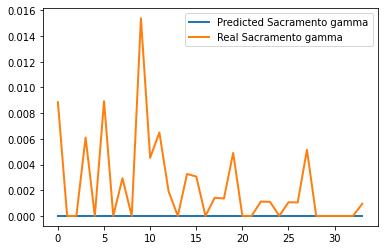

In [47]:
x = range(14)
y1 = mlp1dp_validp_gamma_Sacramento
y2 = valid_gamma_Sacramento
plt.plot(x, y1, ls="-", lw=2, label="Predicted Sacramento gamma")
plt.plot(x, y2, ls="-", lw=2, label="Real Sacramento gamma")
plt.legend()
plt.show()

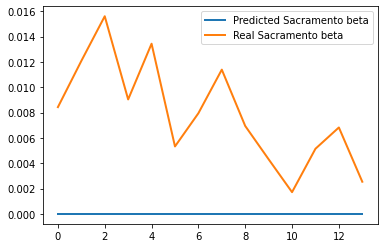

In [48]:
x = range(14)
y1 = mlp1dp_validp_beta_Sacramento
y2 = valid_beta_Sacramento
plt.plot(x, y1, ls="-", lw=2, label="Predicted Sacramento beta")
plt.plot(x, y2, ls="-", lw=2, label="Real Sacramento beta")
plt.legend()
plt.show()

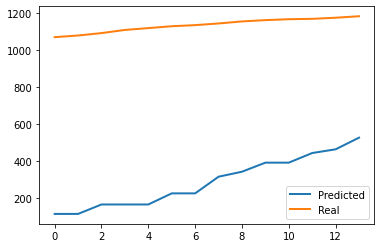

In [49]:
pred_vals = []
for i in range(14):
    pred_vals.append(mlp1dp_validp_case_vals[i][202])

x = range(14)
y1 = pred_vals
y2 = valid_labels_Sacramento
plt.plot(x, y1, ls="-", lw=2, label="Predicted")
plt.plot(x, y2, ls="-", lw=2, label="Real")
plt.legend()
plt.show()

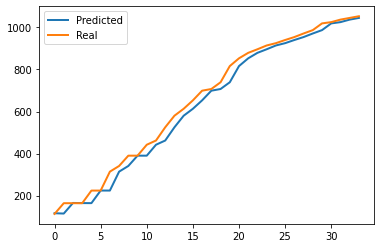

In [51]:
pred_vals = []
for i in range(34):
    pred_vals.append(mlp1dp_trainp_case_vals[i][202])

x = range(34)
y1 = pred_vals
y2 = train_labels_Sacramento
plt.plot(x, y1, ls="-", lw=2, label="Predicted")
plt.plot(x, y2, ls="-", lw=2, label="Real")
plt.legend()
plt.show()

In [55]:
for i,j in zip(mlp1dp_validp_beta_Sacramento, mlp1dp_validp_gamma_Sacramento):
    print(i, j)

tensor(1.8978e-34, device='cuda:0') tensor(0., device='cuda:0')
tensor(3.3648e-35, device='cuda:0') tensor(0., device='cuda:0')
tensor(7.2006e-36, device='cuda:0') tensor(0., device='cuda:0')
tensor(1.4036e-36, device='cuda:0') tensor(0., device='cuda:0')
tensor(3.1646e-37, device='cuda:0') tensor(0., device='cuda:0')
tensor(7.2876e-38, device='cuda:0') tensor(0., device='cuda:0')
tensor(2.3303e-38, device='cuda:0') tensor(0., device='cuda:0')
tensor(5.7001e-39, device='cuda:0') tensor(0., device='cuda:0')
tensor(0., device='cuda:0') tensor(0., device='cuda:0')
tensor(0., device='cuda:0') tensor(0., device='cuda:0')
tensor(0., device='cuda:0') tensor(0., device='cuda:0')
tensor(0., device='cuda:0') tensor(0., device='cuda:0')
tensor(0., device='cuda:0') tensor(0., device='cuda:0')
tensor(0., device='cuda:0') tensor(0., device='cuda:0')


In [56]:
for i,j in zip(mlp1dp_trainp_beta_Sacramento, mlp1dp_trainp_gamma_Sacramento):
    print(i, j)

tensor(0.0293, device='cuda:0') tensor(8.7379e-25, device='cuda:0')
tensor(0.0151, device='cuda:0') tensor(4.2686e-28, device='cuda:0')
tensor(0.0070, device='cuda:0') tensor(1.1978e-33, device='cuda:0')
tensor(0.0032, device='cuda:0') tensor(3.5468e-39, device='cuda:0')
tensor(0.0015, device='cuda:0') tensor(0., device='cuda:0')
tensor(0.0006, device='cuda:0') tensor(0., device='cuda:0')
tensor(0.0002, device='cuda:0') tensor(0., device='cuda:0')
tensor(6.8619e-05, device='cuda:0') tensor(0., device='cuda:0')
tensor(1.4091e-05, device='cuda:0') tensor(0., device='cuda:0')
tensor(1.7017e-06, device='cuda:0') tensor(0., device='cuda:0')
tensor(5.0762e-07, device='cuda:0') tensor(0., device='cuda:0')
tensor(5.5317e-08, device='cuda:0') tensor(0., device='cuda:0')
tensor(1.3023e-08, device='cuda:0') tensor(0., device='cuda:0')
tensor(1.6094e-09, device='cuda:0') tensor(0., device='cuda:0')
tensor(1.6238e-10, device='cuda:0') tensor(0., device='cuda:0')
tensor(1.8827e-11, device='cuda:0') 

## GAT - SIR (loss = cases label)

In [105]:
hidden_size = 100
learning_rate = 0.0000005
num_epochs = 1000
batch_size = 1000
output_size = 2

device = th.device('cuda:0')
input_size = train_past_cases_1d[0].shape[1] + attrs.shape[1]
gat_sir = GAT_SIR(g, input_size, hidden_size, output_size, 1)
print('#features:', input_size)

# Move model to GPU
gat_sir = gat_sir.to(device)

# Move data to GPU
pop = pop.to(device)
attrs = attrs.to(device)
for i in range(len(train_past_cases_1d)):
    train_past_cases_1d[i] = train_past_cases_1d[i].to(device)
    train_past_deaths_1d[i] = train_past_deaths_1d[i].to(device)
    train_labels_cases_1d[i] = train_labels_cases_1d[i].to(device)
    train_labels_deaths_1d[i] = train_labels_deaths_1d[i].to(device)
    if len(train_labels_cases_1d[i].shape) == 1:
        train_labels_cases_1d[i] = train_labels_cases_1d[i].unsqueeze(1)
    if len(train_labels_deaths_1d[i].shape) == 1:
        train_labels_deaths_1d[i] = train_labels_deaths_1d[i].unsqueeze(1)
        
for i in range(len(valid_past_cases_1d)):
    valid_past_cases_1d[i] = valid_past_cases_1d[i].to(device)
    valid_past_deaths_1d[i] = valid_past_deaths_1d[i].to(device)
    valid_labels_cases_1d[i] = valid_labels_cases_1d[i].to(device)
    valid_labels_deaths_1d[i] = valid_labels_deaths_1d[i].to(device)
    if len(valid_labels_cases_1d[i].shape) == 1:
         valid_labels_cases_1d[i] = valid_labels_cases_1d[i].unsqueeze(1)
    if len(test_labels_deaths_1d[i].shape) == 1:
        valid_labels_deaths_1d[i] = valid_labels_deaths_1d[i].unsqueeze(1)

for i in range(len(test_past_cases_1d)):
    test_past_cases_1d[i] = test_past_cases_1d[i].to(device)
    test_past_deaths_1d[i] = test_past_deaths_1d[i].to(device)
    test_labels_cases_1d[i] = test_labels_cases_1d[i].to(device)
    test_labels_deaths_1d[i] = test_labels_deaths_1d[i].to(device)
    if len(test_labels_cases_1d[i].shape) == 1:
        test_labels_cases_1d[i] = test_labels_cases_1d[i].unsqueeze(1)
    if len(test_labels_deaths_1d[i].shape) == 1:
        test_labels_deaths_1d[i] = test_labels_deaths_1d[i].unsqueeze(1)
        
# Normalize attrs
attrs[th.isnan(attrs)] = 0
attr_mean = th.mean(attrs, dim=1, keepdim=True)
attrs = attrs - attr_mean
attr_std = th.std(attrs, dim=1, keepdim=True)
attrs = attrs / attr_std

new_eval_err = 1000
optimizer = th.optim.Adam(gat_sir.parameters(), lr=learning_rate)
for epoch in range(num_epochs):
    losses = []
    for idx in range(len(train_past_cases_1d)):
        labels_cases = train_labels_cases_1d[idx]
        labels_deaths = train_labels_deaths_1d[idx]
        batch = th.cat([train_past_cases_1d[idx], attrs], dim=1)
        th.manual_seed(1)
        vals = gat_sir(batch)
        I = train_past_cases_1d[idx][:,-1].view(3142,1)
        D = train_past_deaths_1d[idx][:,-1].view(3142,1)
        I_new, D_new = sir_1d_output(vals, I, D)
        loss = my_msle_ID(I_new, D_new, labels_cases, labels_deaths)
        loss.backward(retain_graph=True)
        optimizer.step()
        losses.append(loss.detach().cpu().numpy())
    
    count = 0
    with th.no_grad():
        eval_errs = []
        test_errs = []
        test_mses = []
        test_maes = []
        for idx in range(14):
            valid_feats = th.cat([valid_past_cases_1d[idx], attrs], dim=1)
            eval_vals = gat_sir(valid_feats)
            eval_I = valid_past_cases_1d[idx][:,-1].view(3142,1)
            eval_D = valid_past_deaths_1d[idx][:,-1].view(3142,1)
            eval_labels_cases = valid_labels_cases_1d[idx]
            eval_labels_deaths = valid_labels_deaths_1d[idx]
            eval_I_new, eval_D_new = sir_1d_output(eval_vals, eval_I, eval_D)
            err = my_msle_ID(eval_I_new, eval_D_new, eval_labels_cases, eval_labels_deaths)
            eval_errs.append(err.cpu().numpy())
        

            test_feats = th.cat([test_past_cases_1d[idx], attrs], dim=1)
            test_vals = gat_sir(test_feats)
            test_I = test_past_cases_1d[idx][:,-1].view(3142,1)
            test_D = test_past_deaths_1d[idx][:,-1].view(3142,1)
            test_cases = test_labels_cases_1d[idx]
            test_deaths = test_labels_deaths_1d[idx]
            test_I_new, test_D_new = sir_1d_output(test_vals, test_I, test_D)
            test_err = my_msle_ID(test_I_new, test_D_new, test_cases, test_deaths)
            test_mse = th.mean((test_I_new - test_labels_cases_1d[idx])**2)
            test_mae = th.mean(th.abs(test_I_new - test_labels_cases_1d[idx]))
            test_errs.append(test_err.cpu().numpy())
            test_mses.append(test_mse.cpu().numpy())
            test_maes.append(test_mae.cpu().numpy())
        print('epoch={}, loss={:.3f}, validation loss = {:.3f}, test loss={:.3f}, test mse = {:.3f}, test mae = {:.3f}'.format(epoch, np.mean(losses), np.mean(eval_errs), np.mean(test_errs), np.mean(test_mses), np.mean(test_maes)))

#features: 97
epoch=0, loss=1.442, validation loss = 1.406, test loss=nan, test mse = 2342851.750, test mae = 78.885
epoch=1, loss=1.034, validation loss = 0.816, test loss=nan, test mse = 1002800.875, test mae = 36.698
epoch=2, loss=0.803, validation loss = 0.547, test loss=nan, test mse = 2135.164, test mae = 8.534
epoch=3, loss=0.673, validation loss = 0.420, test loss=nan, test mse = 1606.560, test mae = 7.677
epoch=4, loss=0.586, validation loss = 0.340, test loss=nan, test mse = 1595.605, test mae = 7.388
epoch=5, loss=0.520, validation loss = 0.283, test loss=nan, test mse = 1591.918, test mae = 7.235
epoch=6, loss=0.468, validation loss = 0.240, test loss=nan, test mse = 1590.521, test mae = 7.154
epoch=7, loss=0.426, validation loss = 0.206, test loss=nan, test mse = 1590.032, test mae = 7.115
epoch=8, loss=0.390, validation loss = 0.178, test loss=nan, test mse = 1589.932, test mae = 7.100
epoch=9, loss=0.360, validation loss = 0.156, test loss=nan, test mse = 1590.028, test 

epoch=82, loss=0.047, validation loss = 0.013, test loss=nan, test mse = 1588.111, test mae = 6.965
epoch=83, loss=0.047, validation loss = 0.013, test loss=nan, test mse = 1588.107, test mae = 6.964
epoch=84, loss=0.046, validation loss = 0.013, test loss=nan, test mse = 1588.102, test mae = 6.963
epoch=85, loss=0.046, validation loss = 0.013, test loss=nan, test mse = 1588.098, test mae = 6.961
epoch=86, loss=0.046, validation loss = 0.013, test loss=nan, test mse = 1588.094, test mae = 6.960
epoch=87, loss=0.045, validation loss = 0.013, test loss=nan, test mse = 1588.090, test mae = 6.959
epoch=88, loss=0.045, validation loss = 0.013, test loss=nan, test mse = 1588.086, test mae = 6.958
epoch=89, loss=0.045, validation loss = 0.013, test loss=0.010, test mse = 1588.082, test mae = 6.957
epoch=90, loss=0.044, validation loss = 0.013, test loss=0.010, test mse = 1588.078, test mae = 6.956
epoch=91, loss=0.044, validation loss = 0.013, test loss=0.010, test mse = 1588.074, test mae = 

epoch=162, loss=0.036, validation loss = 0.011, test loss=0.009, test mse = 1587.999, test mae = 6.924
epoch=163, loss=0.036, validation loss = 0.011, test loss=0.009, test mse = 1587.999, test mae = 6.924
epoch=164, loss=0.036, validation loss = 0.011, test loss=0.009, test mse = 1587.999, test mae = 6.924
epoch=165, loss=0.036, validation loss = 0.011, test loss=0.009, test mse = 1587.999, test mae = 6.924
epoch=166, loss=0.036, validation loss = 0.011, test loss=0.009, test mse = 1587.999, test mae = 6.924
epoch=167, loss=0.036, validation loss = 0.011, test loss=0.009, test mse = 1587.999, test mae = 6.923
epoch=168, loss=0.036, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.923
epoch=169, loss=0.036, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.923
epoch=170, loss=0.036, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.923
epoch=171, loss=0.036, validation loss = 0.011, test loss=0.008, test mse

epoch=242, loss=0.036, validation loss = 0.011, test loss=0.008, test mse = 1587.998, test mae = 6.918
epoch=243, loss=0.036, validation loss = 0.011, test loss=0.008, test mse = 1587.998, test mae = 6.918
epoch=244, loss=0.036, validation loss = 0.011, test loss=0.008, test mse = 1587.998, test mae = 6.918
epoch=245, loss=0.036, validation loss = 0.011, test loss=0.008, test mse = 1587.998, test mae = 6.918
epoch=246, loss=0.036, validation loss = 0.011, test loss=0.008, test mse = 1587.998, test mae = 6.918
epoch=247, loss=0.036, validation loss = 0.011, test loss=0.008, test mse = 1587.998, test mae = 6.918
epoch=248, loss=0.036, validation loss = 0.011, test loss=0.008, test mse = 1587.998, test mae = 6.918
epoch=249, loss=0.036, validation loss = 0.011, test loss=0.008, test mse = 1587.998, test mae = 6.918
epoch=250, loss=0.036, validation loss = 0.011, test loss=0.008, test mse = 1587.998, test mae = 6.918
epoch=251, loss=0.036, validation loss = 0.011, test loss=0.008, test mse

epoch=322, loss=0.037, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=323, loss=0.037, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=324, loss=0.037, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=325, loss=0.037, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=326, loss=0.037, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=327, loss=0.037, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=328, loss=0.037, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=329, loss=0.037, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=330, loss=0.037, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=331, loss=0.037, validation loss = 0.011, test loss=0.008, test mse

epoch=402, loss=0.037, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=403, loss=0.037, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=404, loss=0.037, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=405, loss=0.037, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=406, loss=0.037, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=407, loss=0.037, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=408, loss=0.037, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=409, loss=0.037, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=410, loss=0.037, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=411, loss=0.037, validation loss = 0.011, test loss=0.008, test mse

epoch=482, loss=0.037, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=483, loss=0.037, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=484, loss=0.037, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=485, loss=0.037, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=486, loss=0.037, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=487, loss=0.037, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=488, loss=0.037, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=489, loss=0.037, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=490, loss=0.037, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=491, loss=0.037, validation loss = 0.011, test loss=0.008, test mse

epoch=562, loss=0.037, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=563, loss=0.037, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=564, loss=0.037, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=565, loss=0.037, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=566, loss=0.037, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=567, loss=0.037, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=568, loss=0.037, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=569, loss=0.037, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=570, loss=0.037, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=571, loss=0.037, validation loss = 0.011, test loss=0.008, test mse

epoch=642, loss=0.037, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=643, loss=0.037, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=644, loss=0.037, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=645, loss=0.037, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=646, loss=0.037, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=647, loss=0.037, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=648, loss=0.037, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=649, loss=0.037, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=650, loss=0.037, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=651, loss=0.037, validation loss = 0.011, test loss=0.008, test mse

epoch=722, loss=0.037, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=723, loss=0.037, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=724, loss=0.037, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=725, loss=0.037, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=726, loss=0.037, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=727, loss=0.037, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=728, loss=0.037, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=729, loss=0.037, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=730, loss=0.037, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=731, loss=0.037, validation loss = 0.011, test loss=0.008, test mse

epoch=802, loss=0.037, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=803, loss=0.037, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=804, loss=0.037, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=805, loss=0.037, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=806, loss=0.037, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=807, loss=0.037, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=808, loss=0.037, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=809, loss=0.037, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=810, loss=0.037, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=811, loss=0.037, validation loss = 0.011, test loss=0.008, test mse

epoch=882, loss=0.037, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=883, loss=0.037, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=884, loss=0.037, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=885, loss=0.037, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=886, loss=0.037, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=887, loss=0.037, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=888, loss=0.037, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=889, loss=0.037, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=890, loss=0.037, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=891, loss=0.037, validation loss = 0.011, test loss=0.008, test mse

epoch=962, loss=0.037, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=963, loss=0.037, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=964, loss=0.037, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=965, loss=0.037, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=966, loss=0.037, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=967, loss=0.037, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=968, loss=0.037, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=969, loss=0.037, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=970, loss=0.037, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=971, loss=0.037, validation loss = 0.011, test loss=0.008, test mse

In [58]:
with th.no_grad():
    gat1dc_trainp_R0_NYC = []
    gat1dc_trainp_R0_Sacramento = []
    gat1dc_trainp_gamma_NYC = []
    gat1dc_trainp_beta_NYC = []
    gat1dc_trainp_gamma_Sacramento = []
    gat1dc_trainp_beta_Sacramento = []
    gat1dc_trainp_case_vals = []
    gat1dc_trainp_death_vals = []
    for idx in range(len(train_past_cases_1d)):
        labels = train_labels_cases_1d[idx]
        batch = th.cat([train_past_cases_1d[idx], attrs], dim=1)
        vals = gat_sir(batch)
        gat1dc_trainp_gamma_NYC.append(vals[4][0])
        gat1dc_trainp_gamma_Sacramento.append(vals[202][0])
        gat1dc_trainp_beta_NYC.append(vals[4][1])
        gat1dc_trainp_beta_Sacramento.append(vals[202][1])
        R_NYC_div = th.div(vals[4][1],vals[4][0])
        R_Sacramento_div = th.div(vals[202][1],vals[202][0])
        gat1dc_trainp_R0_NYC.append(R_NYC_div)
        gat1dc_trainp_R0_Sacramento.append(R_Sacramento_div)  
        I = train_past_cases_1d[idx][:,-1].view(3142,1)
        D = train_past_deaths_1d[idx][:,-1].view(3142,1)
        I_new, D_new = sir_1d_output(vals, I, D)
        gat1dc_trainp_case_vals.append(I_new)
        gat1dc_trainp_death_vals.append(D_new)

    gat1dc_validp_R0_NYC = []
    gat1dc_validp_R0_Sacramento = []
    gat1dc_validp_gamma_NYC = []
    gat1dc_validp_beta_NYC = []
    gat1dc_validp_gamma_Sacramento = []
    gat1dc_validp_beta_Sacramento = []
    gat1dc_validp_case_vals = []
    gat1dc_validp_death_vals = []
    for idx in range(14):
        labels = valid_labels_cases_1d[idx]
        batch = th.cat([valid_past_cases_1d[idx], attrs], dim=1)
        vals = gat_sir(batch)
        gat1dc_validp_gamma_NYC.append(vals[4][0])
        gat1dc_validp_gamma_Sacramento.append(vals[202][0])
        gat1dc_validp_beta_NYC.append(vals[4][1])
        gat1dc_validp_beta_Sacramento.append(vals[202][1])
        R_NYC_div = th.div(vals[4][1],vals[4][0])
        R_Sacramento_div = th.div(vals[202][1],vals[202][0])
        gat1dc_validp_R0_NYC.append(R_NYC_div)
        gat1dc_validp_R0_Sacramento.append(R_Sacramento_div)  
        I = train_past_cases_1d[idx][:,-1].view(3142,1)
        D = train_past_deaths_1d[idx][:,-1].view(3142,1)
        I_new, D_new = sir_1d_output(vals, I, D)
        gat1dc_validp_case_vals.append(I_new)
        gat1dc_validp_death_vals.append(D_new)

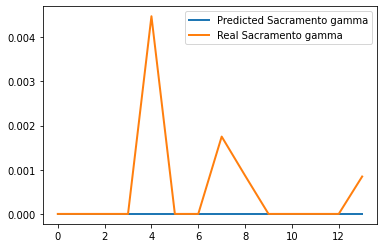

In [60]:
x = range(14)
y1 = gat1dc_validp_gamma_Sacramento
y2 = valid_gamma_Sacramento
plt.plot(x, y1, ls="-", lw=2, label="Predicted Sacramento gamma")
plt.plot(x, y2, ls="-", lw=2, label="Real Sacramento gamma")
plt.legend()
plt.show()

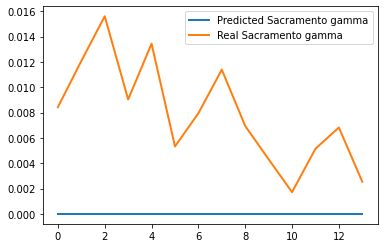

In [61]:
x = range(14)
y1 = gat1dc_validp_beta_Sacramento
y2 = valid_beta_Sacramento
plt.plot(x, y1, ls="-", lw=2, label="Predicted Sacramento gamma")
plt.plot(x, y2, ls="-", lw=2, label="Real Sacramento gamma")
plt.legend()
plt.show()

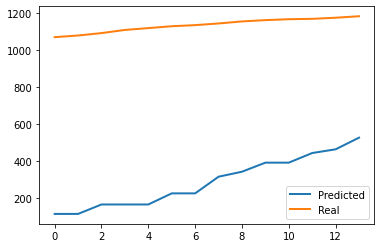

In [62]:
pred_vals = []
for i in range(14):
    pred_vals.append(gat1dc_validp_case_vals[i][202])

x = range(14)
y1 = pred_vals
y2 = valid_labels_Sacramento
plt.plot(x, y1, ls="-", lw=2, label="Predicted")
plt.plot(x, y2, ls="-", lw=2, label="Real")
plt.legend()
plt.show()

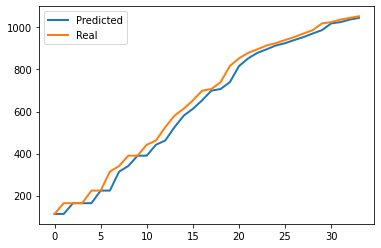

In [63]:
pred_vals = []
for i in range(34):
    pred_vals.append(gat1dc_trainp_case_vals[i][202])

x = range(34)
y1 = pred_vals
y2 = train_labels_Sacramento
plt.plot(x, y1, ls="-", lw=2, label="Predicted")
plt.plot(x, y2, ls="-", lw=2, label="Real")
plt.legend()
plt.show()

## GAT - SIR (loss = params)

In [66]:
hidden_size = 100
learning_rate = 0.0000005
num_epochs = 10000
batch_size = 1000
output_size = 2

device = th.device('cuda:0')
input_size = train_past_cases_1d[0].shape[1] + attrs.shape[1]
gat_sir = GAT_SIR(g, input_size, hidden_size, output_size, 1)
print('#features:', input_size)

# Move model to GPU
gat_sir = gat_sir.to(device)

# Move data to GPU
pop = pop.to(device)
attrs = attrs.to(device)
for i in range(len(train_past_cases_1d)):
    train_past_cases_1d[i] = train_past_cases_1d[i].to(device)
    train_past_deaths_1d[i] = train_past_deaths_1d[i].to(device)
    train_labels_cases_1d[i] = train_labels_cases_1d[i].to(device)
    train_labels_deaths_1d[i] = train_labels_deaths_1d[i].to(device)
    if len(train_labels_cases_1d[i].shape) == 1:
        train_labels_cases_1d[i] = train_labels_cases_1d[i].unsqueeze(1)
    if len(train_labels_deaths_1d[i].shape) == 1:
        train_labels_deaths_1d[i] = train_labels_deaths_1d[i].unsqueeze(1)
        
for i in range(len(valid_past_cases_1d)):
    valid_past_cases_1d[i] = valid_past_cases_1d[i].to(device)
    valid_past_deaths_1d[i] = valid_past_deaths_1d[i].to(device)
    valid_labels_cases_1d[i] = valid_labels_cases_1d[i].to(device)
    valid_labels_deaths_1d[i] = valid_labels_deaths_1d[i].to(device)
    if len(valid_labels_cases_1d[i].shape) == 1:
         valid_labels_cases_1d[i] = valid_labels_cases_1d[i].unsqueeze(1)
    if len(test_labels_deaths_1d[i].shape) == 1:
        valid_labels_deaths_1d[i] = valid_labels_deaths_1d[i].unsqueeze(1)

for i in range(len(test_past_cases_1d)):
    test_past_cases_1d[i] = test_past_cases_1d[i].to(device)
    test_past_deaths_1d[i] = test_past_deaths_1d[i].to(device)
    test_labels_cases_1d[i] = test_labels_cases_1d[i].to(device)
    test_labels_deaths_1d[i] = test_labels_deaths_1d[i].to(device)
    if len(test_labels_cases_1d[i].shape) == 1:
        test_labels_cases_1d[i] = test_labels_cases_1d[i].unsqueeze(1)
    if len(test_labels_deaths_1d[i].shape) == 1:
        test_labels_deaths_1d[i] = test_labels_deaths_1d[i].unsqueeze(1)
        
# Normalize attrs
attrs[th.isnan(attrs)] = 0
attr_mean = th.mean(attrs, dim=1, keepdim=True)
attrs = attrs - attr_mean
attr_std = th.std(attrs, dim=1, keepdim=True)
attrs = attrs / attr_std

new_eval_err = 1000
optimizer = th.optim.Adam(gat_sir.parameters(), lr=learning_rate)
for epoch in range(num_epochs):
    losses = []
    for idx in range(len(train_past_cases_1d)):
        batch = th.cat([train_past_cases_1d[idx], attrs], dim=1)
        vals = gat_sir(batch)
        loss = th.mean(100000*(train_labels_gamma_1d[idx] - vals[:,0])**2 + (train_labels_beta_1d[idx] - vals[:,1])**2)
        loss.backward(retain_graph=True)
        optimizer.step()
        losses.append(loss.detach().cpu().numpy())
        
    count = 0
    with th.no_grad():
        eval_loss1 = []
        eval_errs = []
        test_loss1 = []
        test_errs = []
        test_mses = []
        test_maes = []
        for idx in range(14):
            valid_feats = th.cat([valid_past_cases_1d[idx], attrs], dim=1)
            eval_vals = gat_sir(valid_feats)
            eval_I = valid_past_cases_1d[idx][:,-1].view(3142,1)
            eval_D = valid_past_deaths_1d[idx][:,-1].view(3142,1)
            eval_labels_cases = valid_labels_cases_1d[idx]
            eval_labels_deaths = valid_labels_deaths_1d[idx]
            eval_I_new, eval_D_new = sir_1d_output(eval_vals, eval_I, eval_D)
            err = my_msle_ID(eval_I_new, eval_D_new, eval_labels_cases, eval_labels_deaths)
            eval_loss = th.mean(100000*(valid_labels_gamma_1d[idx] - eval_vals[:,0])**2 + (valid_labels_beta_1d[idx] - eval_vals[:,1])**2)
            eval_errs.append(err.cpu().numpy())
            eval_loss1.append(eval_loss.cpu().numpy())
            
            test_feats = th.cat([test_past_cases_1d[idx], attrs], dim=1)
            test_vals = gat_sir(test_feats)
            test_I = test_past_cases_1d[idx][:,-1].view(3142,1)
            test_D = test_past_deaths_1d[idx][:,-1].view(3142,1)
            test_cases = test_labels_cases_1d[idx]
            test_deaths = test_labels_deaths_1d[idx]
            test_I_new, test_D_new = sir_1d_output(test_vals, test_I, test_D)
            test_err = my_msle_ID(test_I_new, test_D_new, test_cases, test_deaths)
            test_mse = th.mean((test_I_new - test_labels_cases_1d[idx])**2)
            test_mae = th.mean(th.abs(test_I_new - test_labels_cases_1d[idx]))
            test_errs.append(test_err.cpu().numpy())
            test_mses.append(test_mse.cpu().numpy())
            test_maes.append(test_mae.cpu().numpy())
            test_loss = th.mean(100000*(test_labels_gamma_1d[idx] - test_vals[:,0])**2 + (test_labels_beta_1d[idx] - test_vals[:,1])**2)
            test_loss1.append(test_loss.cpu().numpy())
        print('epoch={}, loss={:.3f}, validation loss = {:.3f}, test loss={:.3f}, test mse = {:.3f}, test mae = {:.3f}'.format(epoch, np.mean(losses), np.mean(eval_errs), np.mean(test_errs), np.mean(test_mses), np.mean(test_maes)))

#features: 97
epoch=0, loss=14720.409, validation loss = 1.145, test loss=1.129, test mse = 2170711.000, test mae = 79.435
epoch=1, loss=12459.161, validation loss = 0.568, test loss=0.427, test mse = 4859.380, test mae = 11.685
epoch=2, loss=11120.680, validation loss = 0.383, test loss=0.274, test mse = 2352.210, test mae = 8.840
epoch=3, loss=10226.835, validation loss = 0.290, test loss=0.206, test mse = 2574.694, test mae = 8.501
epoch=4, loss=9526.489, validation loss = 0.232, test loss=0.165, test mse = 2991.967, test mae = 8.508
epoch=5, loss=8947.104, validation loss = 0.192, test loss=0.138, test mse = 3147.469, test mae = 8.466
epoch=6, loss=8451.038, validation loss = 0.163, test loss=0.117, test mse = 2886.439, test mae = 8.276
epoch=7, loss=8017.465, validation loss = 0.141, test loss=0.102, test mse = 2408.822, test mae = 8.009
epoch=8, loss=7632.207, validation loss = 0.124, test loss=0.090, test mse = 2538.346, test mae = 7.975
epoch=9, loss=7285.852, validation loss =

epoch=78, loss=807.784, validation loss = 0.013, test loss=0.009, test mse = 1587.975, test mae = 6.954
epoch=79, loss=780.785, validation loss = 0.013, test loss=0.009, test mse = 1587.976, test mae = 6.952
epoch=80, loss=754.595, validation loss = 0.013, test loss=0.009, test mse = 1587.977, test mae = 6.951
epoch=81, loss=729.199, validation loss = 0.013, test loss=0.009, test mse = 1587.978, test mae = 6.950
epoch=82, loss=704.586, validation loss = 0.013, test loss=0.009, test mse = 1587.978, test mae = 6.949
epoch=83, loss=680.734, validation loss = 0.013, test loss=0.009, test mse = 1587.979, test mae = 6.948
epoch=84, loss=657.620, validation loss = 0.013, test loss=0.009, test mse = 1587.979, test mae = 6.947
epoch=85, loss=635.220, validation loss = 0.013, test loss=0.009, test mse = 1587.980, test mae = 6.946
epoch=86, loss=613.511, validation loss = 0.012, test loss=0.009, test mse = 1587.981, test mae = 6.945
epoch=87, loss=592.472, validation loss = 0.012, test loss=0.009

epoch=157, loss=82.248, validation loss = 0.011, test loss=0.008, test mse = 1587.994, test mae = 6.921
epoch=158, loss=81.379, validation loss = 0.011, test loss=0.008, test mse = 1587.994, test mae = 6.921
epoch=159, loss=80.560, validation loss = 0.011, test loss=0.008, test mse = 1587.994, test mae = 6.921
epoch=160, loss=79.790, validation loss = 0.011, test loss=0.008, test mse = 1587.994, test mae = 6.921
epoch=161, loss=79.065, validation loss = 0.011, test loss=0.008, test mse = 1587.994, test mae = 6.921
epoch=162, loss=78.383, validation loss = 0.011, test loss=0.008, test mse = 1587.994, test mae = 6.921
epoch=163, loss=77.742, validation loss = 0.011, test loss=0.008, test mse = 1587.994, test mae = 6.921
epoch=164, loss=77.140, validation loss = 0.011, test loss=0.008, test mse = 1587.994, test mae = 6.921
epoch=165, loss=76.575, validation loss = 0.011, test loss=0.008, test mse = 1587.994, test mae = 6.921
epoch=166, loss=76.045, validation loss = 0.011, test loss=0.008

epoch=236, loss=68.974, validation loss = 0.011, test loss=0.008, test mse = 1587.998, test mae = 6.918
epoch=237, loss=68.975, validation loss = 0.011, test loss=0.008, test mse = 1587.998, test mae = 6.918
epoch=238, loss=68.976, validation loss = 0.011, test loss=0.008, test mse = 1587.998, test mae = 6.918
epoch=239, loss=68.977, validation loss = 0.011, test loss=0.008, test mse = 1587.998, test mae = 6.918
epoch=240, loss=68.979, validation loss = 0.011, test loss=0.008, test mse = 1587.998, test mae = 6.918
epoch=241, loss=68.980, validation loss = 0.011, test loss=0.008, test mse = 1587.998, test mae = 6.918
epoch=242, loss=68.981, validation loss = 0.011, test loss=0.008, test mse = 1587.998, test mae = 6.918
epoch=243, loss=68.982, validation loss = 0.011, test loss=0.008, test mse = 1587.998, test mae = 6.918
epoch=244, loss=68.984, validation loss = 0.011, test loss=0.008, test mse = 1587.998, test mae = 6.918
epoch=245, loss=68.985, validation loss = 0.011, test loss=0.008

epoch=315, loss=69.015, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=316, loss=69.015, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=317, loss=69.015, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=318, loss=69.015, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=319, loss=69.015, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=320, loss=69.015, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=321, loss=69.015, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=322, loss=69.015, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=323, loss=69.015, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=324, loss=69.015, validation loss = 0.011, test loss=0.008

epoch=394, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=395, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=396, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=397, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=398, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=399, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=400, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=401, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=402, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=403, loss=69.016, validation loss = 0.011, test loss=0.008

epoch=473, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=474, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=475, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=476, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=477, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=478, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=479, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=480, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=481, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=482, loss=69.016, validation loss = 0.011, test loss=0.008

epoch=552, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=553, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=554, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=555, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=556, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=557, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=558, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=559, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=560, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=561, loss=69.016, validation loss = 0.011, test loss=0.008

epoch=631, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=632, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=633, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=634, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=635, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=636, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=637, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=638, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=639, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=640, loss=69.016, validation loss = 0.011, test loss=0.008

epoch=710, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=711, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=712, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=713, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=714, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=715, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=716, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=717, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=718, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=719, loss=69.016, validation loss = 0.011, test loss=0.008

epoch=789, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=790, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=791, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=792, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=793, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=794, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=795, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=796, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=797, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=798, loss=69.016, validation loss = 0.011, test loss=0.008

epoch=868, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=869, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=870, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=871, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=872, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=873, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=874, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=875, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=876, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=877, loss=69.016, validation loss = 0.011, test loss=0.008

epoch=947, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=948, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=949, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=950, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=951, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=952, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=953, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=954, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=955, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=956, loss=69.016, validation loss = 0.011, test loss=0.008

epoch=1026, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=1027, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=1028, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=1029, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=1030, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=1031, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=1032, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=1033, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=1034, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=1035, loss=69.016, validation loss = 0.011, test 

epoch=1105, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=1106, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=1107, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=1108, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=1109, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=1110, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=1111, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=1112, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=1113, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=1114, loss=69.016, validation loss = 0.011, test 

epoch=1184, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=1185, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=1186, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=1187, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=1188, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=1189, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=1190, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=1191, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=1192, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=1193, loss=69.016, validation loss = 0.011, test 

epoch=1263, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=1264, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=1265, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=1266, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=1267, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=1268, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=1269, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=1270, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=1271, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=1272, loss=69.016, validation loss = 0.011, test 

epoch=1342, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=1343, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=1344, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=1345, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=1346, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=1347, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=1348, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=1349, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=1350, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=1351, loss=69.016, validation loss = 0.011, test 

epoch=1421, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=1422, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=1423, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=1424, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=1425, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=1426, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=1427, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=1428, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=1429, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=1430, loss=69.016, validation loss = 0.011, test 

epoch=1500, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=1501, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=1502, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=1503, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=1504, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=1505, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=1506, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=1507, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=1508, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=1509, loss=69.016, validation loss = 0.011, test 

epoch=1579, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=1580, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=1581, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=1582, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=1583, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=1584, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=1585, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=1586, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=1587, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=1588, loss=69.016, validation loss = 0.011, test 

epoch=1658, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=1659, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=1660, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=1661, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=1662, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=1663, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=1664, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=1665, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=1666, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=1667, loss=69.016, validation loss = 0.011, test 

epoch=1737, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=1738, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=1739, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=1740, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=1741, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=1742, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=1743, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=1744, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=1745, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=1746, loss=69.016, validation loss = 0.011, test 

epoch=1816, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=1817, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=1818, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=1819, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=1820, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=1821, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=1822, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=1823, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=1824, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=1825, loss=69.016, validation loss = 0.011, test 

epoch=1895, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=1896, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=1897, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=1898, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=1899, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=1900, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=1901, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=1902, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=1903, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=1904, loss=69.016, validation loss = 0.011, test 

epoch=1974, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=1975, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=1976, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=1977, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=1978, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=1979, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=1980, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=1981, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=1982, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=1983, loss=69.016, validation loss = 0.011, test 

epoch=2053, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=2054, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=2055, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=2056, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=2057, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=2058, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=2059, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=2060, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=2061, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=2062, loss=69.016, validation loss = 0.011, test 

epoch=2132, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=2133, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=2134, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=2135, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=2136, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=2137, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=2138, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=2139, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=2140, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=2141, loss=69.016, validation loss = 0.011, test 

epoch=2211, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=2212, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=2213, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=2214, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=2215, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=2216, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=2217, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=2218, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=2219, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=2220, loss=69.016, validation loss = 0.011, test 

epoch=2290, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=2291, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=2292, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=2293, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=2294, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=2295, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=2296, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=2297, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=2298, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=2299, loss=69.016, validation loss = 0.011, test 

epoch=2369, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=2370, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=2371, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=2372, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=2373, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=2374, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=2375, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=2376, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=2377, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=2378, loss=69.016, validation loss = 0.011, test 

epoch=2448, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=2449, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=2450, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=2451, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=2452, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=2453, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=2454, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=2455, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=2456, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=2457, loss=69.016, validation loss = 0.011, test 

epoch=2527, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=2528, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=2529, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=2530, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=2531, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=2532, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=2533, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=2534, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=2535, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=2536, loss=69.016, validation loss = 0.011, test 

epoch=2606, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=2607, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=2608, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=2609, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=2610, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=2611, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=2612, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=2613, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=2614, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=2615, loss=69.016, validation loss = 0.011, test 

epoch=2685, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=2686, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=2687, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=2688, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=2689, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=2690, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=2691, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=2692, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=2693, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=2694, loss=69.016, validation loss = 0.011, test 

epoch=2764, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=2765, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=2766, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=2767, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=2768, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=2769, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=2770, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=2771, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=2772, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=2773, loss=69.016, validation loss = 0.011, test 

epoch=2843, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=2844, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=2845, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=2846, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=2847, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=2848, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=2849, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=2850, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=2851, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=2852, loss=69.016, validation loss = 0.011, test 

epoch=2922, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=2923, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=2924, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=2925, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=2926, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=2927, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=2928, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=2929, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=2930, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=2931, loss=69.016, validation loss = 0.011, test 

epoch=3001, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=3002, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=3003, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=3004, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=3005, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=3006, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=3007, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=3008, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=3009, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=3010, loss=69.016, validation loss = 0.011, test 

epoch=3080, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=3081, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=3082, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=3083, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=3084, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=3085, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=3086, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=3087, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=3088, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=3089, loss=69.016, validation loss = 0.011, test 

epoch=3159, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=3160, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=3161, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=3162, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=3163, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=3164, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=3165, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=3166, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=3167, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=3168, loss=69.016, validation loss = 0.011, test 

epoch=3238, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=3239, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=3240, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=3241, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=3242, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=3243, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=3244, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=3245, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=3246, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=3247, loss=69.016, validation loss = 0.011, test 

epoch=3317, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=3318, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=3319, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=3320, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=3321, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=3322, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=3323, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=3324, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=3325, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=3326, loss=69.016, validation loss = 0.011, test 

epoch=3396, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=3397, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=3398, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=3399, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=3400, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=3401, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=3402, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=3403, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=3404, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=3405, loss=69.016, validation loss = 0.011, test 

epoch=3475, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=3476, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=3477, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=3478, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=3479, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=3480, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=3481, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=3482, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=3483, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=3484, loss=69.016, validation loss = 0.011, test 

epoch=3554, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=3555, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=3556, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=3557, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=3558, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=3559, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=3560, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=3561, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=3562, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=3563, loss=69.016, validation loss = 0.011, test 

epoch=3633, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=3634, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=3635, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=3636, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=3637, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=3638, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=3639, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=3640, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=3641, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=3642, loss=69.016, validation loss = 0.011, test 

epoch=3712, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=3713, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=3714, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=3715, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=3716, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=3717, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=3718, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=3719, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=3720, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=3721, loss=69.016, validation loss = 0.011, test 

epoch=3791, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=3792, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=3793, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=3794, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=3795, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=3796, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=3797, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=3798, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=3799, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=3800, loss=69.016, validation loss = 0.011, test 

epoch=3870, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=3871, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=3872, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=3873, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=3874, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=3875, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=3876, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=3877, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=3878, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=3879, loss=69.016, validation loss = 0.011, test 

epoch=3949, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=3950, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=3951, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=3952, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=3953, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=3954, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=3955, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=3956, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=3957, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=3958, loss=69.016, validation loss = 0.011, test 

epoch=4028, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=4029, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=4030, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=4031, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=4032, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=4033, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=4034, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=4035, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=4036, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=4037, loss=69.016, validation loss = 0.011, test 

epoch=4107, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=4108, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=4109, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=4110, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=4111, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=4112, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=4113, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=4114, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=4115, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=4116, loss=69.016, validation loss = 0.011, test 

epoch=4186, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=4187, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=4188, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=4189, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=4190, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=4191, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=4192, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=4193, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=4194, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=4195, loss=69.016, validation loss = 0.011, test 

epoch=4265, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=4266, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=4267, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=4268, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=4269, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=4270, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=4271, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=4272, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=4273, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=4274, loss=69.016, validation loss = 0.011, test 

epoch=4344, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=4345, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=4346, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=4347, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=4348, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=4349, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=4350, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=4351, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=4352, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=4353, loss=69.016, validation loss = 0.011, test 

epoch=4423, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=4424, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=4425, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=4426, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=4427, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=4428, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=4429, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=4430, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=4431, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=4432, loss=69.016, validation loss = 0.011, test 

epoch=4502, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=4503, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=4504, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=4505, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=4506, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=4507, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=4508, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=4509, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=4510, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=4511, loss=69.016, validation loss = 0.011, test 

epoch=4581, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=4582, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=4583, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=4584, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=4585, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=4586, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=4587, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=4588, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=4589, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=4590, loss=69.016, validation loss = 0.011, test 

epoch=4660, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=4661, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=4662, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=4663, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=4664, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=4665, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=4666, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=4667, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=4668, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=4669, loss=69.016, validation loss = 0.011, test 

epoch=4739, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=4740, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=4741, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=4742, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=4743, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=4744, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=4745, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=4746, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=4747, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=4748, loss=69.016, validation loss = 0.011, test 

epoch=4818, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=4819, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=4820, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=4821, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=4822, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=4823, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=4824, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=4825, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=4826, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=4827, loss=69.016, validation loss = 0.011, test 

epoch=4897, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=4898, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=4899, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=4900, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=4901, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=4902, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=4903, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=4904, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=4905, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=4906, loss=69.016, validation loss = 0.011, test 

epoch=4976, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=4977, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=4978, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=4979, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=4980, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=4981, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=4982, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=4983, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=4984, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=4985, loss=69.016, validation loss = 0.011, test 

epoch=5055, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=5056, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=5057, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=5058, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=5059, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=5060, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=5061, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=5062, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=5063, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=5064, loss=69.016, validation loss = 0.011, test 

epoch=5134, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=5135, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=5136, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=5137, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=5138, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=5139, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=5140, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=5141, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=5142, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=5143, loss=69.016, validation loss = 0.011, test 

epoch=5213, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=5214, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=5215, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=5216, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=5217, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=5218, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=5219, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=5220, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=5221, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=5222, loss=69.016, validation loss = 0.011, test 

epoch=5292, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=5293, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=5294, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=5295, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=5296, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=5297, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=5298, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=5299, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=5300, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=5301, loss=69.016, validation loss = 0.011, test 

epoch=5371, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=5372, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=5373, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=5374, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=5375, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=5376, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=5377, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=5378, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=5379, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=5380, loss=69.016, validation loss = 0.011, test 

epoch=5450, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=5451, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=5452, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=5453, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=5454, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=5455, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=5456, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=5457, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=5458, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=5459, loss=69.016, validation loss = 0.011, test 

epoch=5529, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=5530, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=5531, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=5532, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=5533, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=5534, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=5535, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=5536, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=5537, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=5538, loss=69.016, validation loss = 0.011, test 

epoch=5608, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=5609, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=5610, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=5611, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=5612, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=5613, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=5614, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=5615, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=5616, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=5617, loss=69.016, validation loss = 0.011, test 

epoch=5687, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=5688, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=5689, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=5690, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=5691, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=5692, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=5693, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=5694, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=5695, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=5696, loss=69.016, validation loss = 0.011, test 

epoch=5766, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=5767, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=5768, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=5769, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=5770, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=5771, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=5772, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=5773, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=5774, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=5775, loss=69.016, validation loss = 0.011, test 

epoch=5845, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=5846, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=5847, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=5848, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=5849, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=5850, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=5851, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=5852, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=5853, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=5854, loss=69.016, validation loss = 0.011, test 

epoch=5924, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=5925, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=5926, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=5927, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=5928, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=5929, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=5930, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=5931, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=5932, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=5933, loss=69.016, validation loss = 0.011, test 

epoch=6003, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=6004, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=6005, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=6006, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=6007, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=6008, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=6009, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=6010, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=6011, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=6012, loss=69.016, validation loss = 0.011, test 

epoch=6082, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=6083, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=6084, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=6085, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=6086, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=6087, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=6088, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=6089, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=6090, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=6091, loss=69.016, validation loss = 0.011, test 

epoch=6161, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=6162, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=6163, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=6164, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=6165, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=6166, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=6167, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=6168, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=6169, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=6170, loss=69.016, validation loss = 0.011, test 

epoch=6240, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=6241, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=6242, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=6243, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=6244, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=6245, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=6246, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=6247, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=6248, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=6249, loss=69.016, validation loss = 0.011, test 

epoch=6319, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=6320, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=6321, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=6322, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=6323, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=6324, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=6325, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=6326, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=6327, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=6328, loss=69.016, validation loss = 0.011, test 

epoch=6398, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=6399, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=6400, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=6401, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=6402, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=6403, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=6404, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=6405, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=6406, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=6407, loss=69.016, validation loss = 0.011, test 

epoch=6477, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=6478, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=6479, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=6480, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=6481, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=6482, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=6483, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=6484, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=6485, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=6486, loss=69.016, validation loss = 0.011, test 

epoch=6556, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=6557, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=6558, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=6559, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=6560, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=6561, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=6562, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=6563, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=6564, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=6565, loss=69.016, validation loss = 0.011, test 

epoch=6635, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=6636, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=6637, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=6638, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=6639, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=6640, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=6641, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=6642, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=6643, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=6644, loss=69.016, validation loss = 0.011, test 

epoch=6714, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=6715, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=6716, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=6717, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=6718, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=6719, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=6720, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=6721, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=6722, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=6723, loss=69.016, validation loss = 0.011, test 

epoch=6793, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=6794, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=6795, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=6796, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=6797, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=6798, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=6799, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=6800, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=6801, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=6802, loss=69.016, validation loss = 0.011, test 

epoch=6872, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=6873, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=6874, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=6875, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=6876, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=6877, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=6878, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=6879, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=6880, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=6881, loss=69.016, validation loss = 0.011, test 

epoch=6951, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=6952, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=6953, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=6954, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=6955, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=6956, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=6957, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=6958, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=6959, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=6960, loss=69.016, validation loss = 0.011, test 

epoch=7030, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=7031, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=7032, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=7033, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=7034, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=7035, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=7036, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=7037, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=7038, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=7039, loss=69.016, validation loss = 0.011, test 

epoch=7109, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=7110, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=7111, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=7112, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=7113, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=7114, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=7115, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=7116, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=7117, loss=69.016, validation loss = 0.011, test loss=0.008, test mse = 1587.999, test mae = 6.918
epoch=7118, loss=69.016, validation loss = 0.011, test 

KeyboardInterrupt: 

In [67]:
with th.no_grad():
    gat1dp_trainp_R0_NYC = []
    gat1dp_trainp_R0_Sacramento = []
    gat1dp_trainp_gamma_NYC = []
    gat1dp_trainp_beta_NYC = []
    gat1dp_trainp_gamma_Sacramento = []
    gat1dp_trainp_beta_Sacramento = []
    gat1dp_trainp_case_vals = []
    gat1dp_trainp_death_vals = []
    for idx in range(len(train_past_cases_1d)):
        labels = train_labels_cases_1d[idx]
        batch = th.cat([train_past_cases_1d[idx], attrs], dim=1)
        vals = gat_sir(batch)
        gat1dp_trainp_gamma_NYC.append(vals[4][0])
        gat1dp_trainp_gamma_Sacramento.append(vals[202][0])
        gat1dp_trainp_beta_NYC.append(vals[4][1])
        gat1dp_trainp_beta_Sacramento.append(vals[202][1])
        R_NYC_div = th.div(vals[4][1],vals[4][0])
        R_Sacramento_div = th.div(vals[202][1],vals[202][0])
        gat1dp_trainp_R0_NYC.append(R_NYC_div)
        gat1dp_trainp_R0_Sacramento.append(R_Sacramento_div)  
        I = train_past_cases_1d[idx][:,-1].view(3142,1)
        D = train_past_deaths_1d[idx][:,-1].view(3142,1)
        I_new, D_new = sir_1d_output(vals, I, D)
        gat1dp_trainp_case_vals.append(I_new)
        gat1dp_trainp_death_vals.append(D_new)

    gat1dp_validp_R0_NYC = []
    gat1dp_validp_R0_Sacramento = []
    gat1dp_validp_gamma_NYC = []
    gat1dp_validp_beta_NYC = []
    gat1dp_validp_gamma_Sacramento = []
    gat1dp_validp_beta_Sacramento = []
    gat1dp_validp_case_vals = []
    gat1dp_validp_death_vals = []
    for idx in range(14):
        labels = valid_labels_cases_1d[idx]
        batch = th.cat([valid_past_cases_1d[idx], attrs], dim=1)
        vals = gat_sir(batch)
        gat1dp_validp_gamma_NYC.append(vals[4][0])
        gat1dp_validp_gamma_Sacramento.append(vals[202][0])
        gat1dp_validp_beta_NYC.append(vals[4][1])
        gat1dp_validp_beta_Sacramento.append(vals[202][1])
        R_NYC_div = th.div(vals[4][1],vals[4][0])
        R_Sacramento_div = th.div(vals[202][1],vals[202][0])
        gat1dp_validp_R0_NYC.append(R_NYC_div)
        gat1dp_validp_R0_Sacramento.append(R_Sacramento_div)  
        I = train_past_cases_1d[idx][:,-1].view(3142,1)
        D = train_past_deaths_1d[idx][:,-1].view(3142,1)
        I_new, D_new = sir_1d_output(vals, I, D)
        gat1dp_validp_case_vals.append(I_new)
        gat1dp_validp_death_vals.append(D_new)

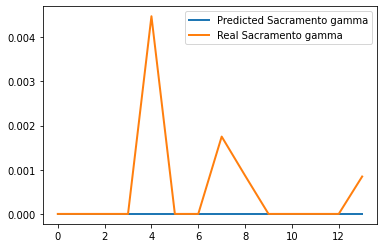

In [68]:
x = range(14)
y1 = gat1dp_validp_gamma_Sacramento
y2 = valid_gamma_Sacramento
plt.plot(x, y1, ls="-", lw=2, label="Predicted Sacramento gamma")
plt.plot(x, y2, ls="-", lw=2, label="Real Sacramento gamma")
plt.legend()
plt.show()

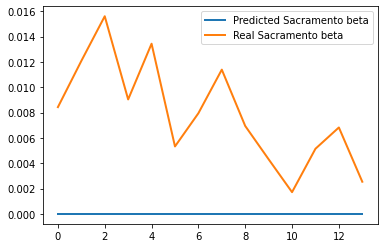

In [69]:
x = range(14)
y1 = gat1dc_validp_beta_Sacramento
y2 = valid_beta_Sacramento
plt.plot(x, y1, ls="-", lw=2, label="Predicted Sacramento beta")
plt.plot(x, y2, ls="-", lw=2, label="Real Sacramento beta")
plt.legend()
plt.show()

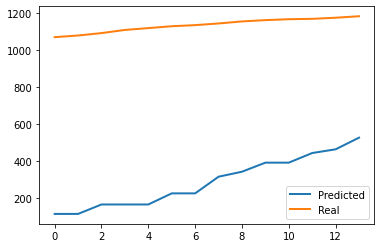

In [70]:
pred_vals = []
for i in range(14):
    pred_vals.append(gat1dp_validp_case_vals[i][202])

x = range(14)
y1 = pred_vals
y2 = valid_labels_Sacramento
plt.plot(x, y1, ls="-", lw=2, label="Predicted")
plt.plot(x, y2, ls="-", lw=2, label="Real")
plt.legend()
plt.show()

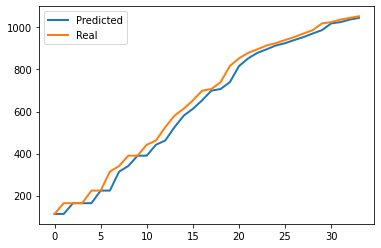

In [71]:
pred_vals = []
for i in range(34):
    pred_vals.append(gat1dp_trainp_case_vals[i][202])

x = range(34)
y1 = pred_vals
y2 = train_labels_Sacramento
plt.plot(x, y1, ls="-", lw=2, label="Predicted")
plt.plot(x, y2, ls="-", lw=2, label="Real")
plt.legend()
plt.show()

# 7-day Predictions

## Prepare Data

In [72]:
attr_cols = []

# Set the variable to True if we want to specify features ourselves.
use_specified_fields = False

if use_specified_fields:
    f = open("fields.txt", "r")
    fields = f.readlines()
    for field in fields:
        field = field.rstrip()
        arr = np.array(df[field])
        if arr.dtype == np.float32 or arr.dtype == np.float64:
            attr_cols.append(np.array(arr, dtype=np.float32))
else:
    for i in range(6, 86):
        arr = np.array(df[keys[i]])
        if arr.dtype == np.float32 or arr.dtype == np.float64:
            attr_cols.append(np.array(arr, dtype=np.float32))

attrs = th.tensor(np.stack(attr_cols, 1), dtype=th.float32)
cases = []
# for i in range(87, 216):
for i in range(132, 216):
    cases.append(np.array(df[keys[i]]))
cases = np.stack(cases, 1)
deaths = []
# for i in range(218, 347):
for i in range(263, 347):
    deaths.append(np.array(df[keys[i]]))
deaths = np.stack(deaths, 1)

pop = attrs[:,5]
pop = pop.view(3142, 1)
pop[1834] = 1 

print('attrs:', attrs.shape)
print('cases:', cases.shape)
print('deaths:', deaths.shape)
print(attrs[0])
print(cases[0])
print(deaths[0])

attrs: torch.Size([3142, 78])
cases: (3142, 84)
deaths: (3142, 84)
tensor([ 4.0641e+01, -7.3955e+01,  4.0651e+01, -7.3955e+01,  1.0000e+00,
         2.5828e+06,  1.2550e+06,  1.3938e+06,  4.7379e-01,  3.5671e+05,
         3.5369e+04,  2.5047e+06,  3.4100e+01,  3.8667e+05,  3.0966e+05,
         6.3500e+02,  9.7000e+00,  1.9580e+02,  1.9500e+01,  1.3841e+01,
         2.3050e+01,  3.5442e+04,  9.3070e+03,  6.0000e+00,  1.2000e+01,
         3.1800e+02,  4.5415e+00,  9.0415e+04,  8.6783e+04,  8.1356e+04,
         7.8035e+04,  7.9604e+04,  7.6959e+04,  8.6716e+04,  8.3968e+04,
         9.6663e+04,  9.9134e+04,  1.0605e+05,  1.1679e+05,  9.7154e+04,
         1.0570e+05,  1.6196e+05,  1.7958e+05,  1.4949e+05,  1.7469e+05,
         6.3789e+04,  7.8116e+04,  5.5241e+04,  6.8866e+04,  6.4628e+04,
         8.8066e+04,  3.5780e+04,  5.8209e+04,  1.2524e+04,  2.8426e+04,
         1.5400e+02,  2.4000e+01,  3.3000e+01,  1.5100e+02,  3.4100e+02,
         4.9300e+02,  1.1160e+03,  2.1390e+03,  2.8520e+0

In [73]:
num_days = cases.shape[1]
num_valid_days = 15
num_test_days = 15
train_valid_split = num_days - num_valid_days - num_test_days
valid_test_split = num_days - num_test_days
in_len = 20
out_len = 7
out_size = 7

train_past_cases = []
train_past_deaths = []
train_labels_cases = []
train_labels_deaths = []
for start in range(14):
    end = start + in_len + out_len - 1
    end_begin = end - out_len
    train_past_cases.append(th.tensor(cases[:,start:end_begin], dtype=th.float32))
    #train_past_deaths.append(th.mul(th.tensor(deaths[:,start:end_begin], dtype=th.float32),1))
    train_past_deaths.append(th.mul(th.tensor(deaths[:,start:end_begin], dtype=th.float32),1))
    train_labels_cases.append(th.tensor(cases[:,end_begin:end], dtype=th.float32))
    #train_labels_deaths.append(th.mul(th.tensor(deaths[:,end_begin:end], dtype=th.float32),1))
    train_labels_deaths.append(th.mul(th.tensor(deaths[:,end_begin:end], dtype=th.float32),1))

for start in range(14, train_valid_split - in_len - out_len + 1):
    end = start + in_len + out_len - 1
    end_begin = end - out_len
    train_past_cases.append(th.tensor(cases[:,start:end_begin], dtype=th.float32))
    #train_past_deaths.append(th.mul(th.tensor(deaths[:,start:end_begin], dtype=th.float32),1))
    train_past_deaths.append(th.mul(th.tensor(cases[:,start-14:end_begin-14], dtype=th.float32),1))
    train_labels_cases.append(th.tensor(cases[:,end_begin:end], dtype=th.float32))
    #train_labels_deaths.append(th.mul(th.tensor(deaths[:,end_begin:end], dtype=th.float32),1))
    train_labels_deaths.append(th.mul(th.tensor(cases[:,end_begin-14:end-14], dtype=th.float32),1))

valid_past_cases = []
valid_past_deaths = []
valid_labels_cases = []
valid_labels_deaths = []
for start in range(train_valid_split - in_len - out_len + 1, valid_test_split - in_len - out_len):
    end = start + in_len + out_len - 1
    end_begin = end - out_len
    valid_past_cases.append(th.tensor(cases[:,start:end_begin], dtype=th.float32))
    #valid_past_deaths.append(th.mul(th.tensor(deaths[:,start:end_begin], dtype=th.float32),50))
    valid_past_deaths.append(th.mul(th.tensor(cases[:,start-14:end_begin-14], dtype=th.float32),1))
    valid_labels_cases.append(th.tensor(cases[:,end_begin:end], dtype=th.float32))
    #valid_labels_deaths.append(th.mul(th.tensor(deaths[:,end_begin:end], dtype=th.float32),50))
    valid_labels_deaths.append(th.mul(th.tensor(cases[:,end_begin-14:end-14], dtype=th.float32),1))
    
test_past_cases = []
test_past_deaths = []
test_labels_cases = []
test_labels_deaths = []
for start in range(valid_test_split - in_len - out_len + 1, num_days - in_len - out_len):
    end = start + in_len + out_len - 1
    end_begin = end - out_len
    test_past_cases.append(th.tensor(cases[:,start:end_begin], dtype=th.float32))
    # test_past_deaths.append(th.mul(th.tensor(deaths[:,start:end_begin], dtype=th.float32),50))
    test_past_deaths.append(th.mul(th.tensor(cases[:,start-14:end_begin-14], dtype=th.float32),1))
    test_labels_cases.append(th.tensor(cases[:,end_begin:end], dtype=th.float32))
    #test_labels_deaths.append(th.mul(th.tensor(deaths[:,end_begin:end], dtype=th.float32),50))
    test_labels_deaths.append(th.mul(th.tensor(cases[:,end_begin-1:end-1], dtype=th.float32),1))

## Helper Functions

In [74]:
def sir_output(params, I, D):
    gamma = params[:,0]
    beta = params[:,1]
    I[I != I] = 0.0
    D[D != D] = 0.0
    err = th.tensor([0],dtype=th.float)
    err = err.to(device)
    S = pop - I - D
    I_lst = []
    D_lst = []
    for i in range(7):
        S_new = th.add(S, - th.div(th.mul(beta.view(3142,1), th.mul(S, I)), pop))
        I_new = th.add(th.add(I, th.mul(beta.view(3142,1), th.div(th.mul(S,I), pop))), - th.mul(gamma.view(3142,1), I))
        D_new = th.add(D, th.mul(gamma.view(3142,1), I))
        I_lst.append(I_new)
        D_lst.append(D_new)
        S = S_new
        I = I_new
        D = D_new
    return th.cat(I_lst, dim = 1), th.cat(D_lst, dim = 1)

## Training Loop

### MLP - SIR

In [75]:
hidden_size = 100
learning_rate = 0.0000005
num_epochs = 1000
batch_size = 1000
output_size = 2

device = th.device('cuda:0')
input_size = train_past_cases[0].shape[1] + attrs.shape[1]
mlp_sir = Net_SIR(input_size, hidden_size, output_size)
print('#features:', input_size)

# Move model to GPU
mlp_sir = mlp_sir.to(device)
# TODO we might want to choose a better loss.
# L2 loss will penalize the data points with larger deaths more. Is this what we want?
# criterion = criterion.to(device)

# Move data to GPU
pop = pop.to(device)
attrs = attrs.to(device)
for i in range(len(train_past_cases)):
    train_past_cases[i] = train_past_cases[i].to(device)
    train_past_deaths[i] = train_past_deaths[i].to(device)
    train_labels_cases[i] = train_labels_cases[i].to(device)
    train_labels_deaths[i] = train_labels_deaths[i].to(device)
    if len(train_labels_cases[i].shape) == 1:
        train_labels_cases[i] = train_labels_cases[i].unsqueeze(1)
    if len(train_labels_deaths[i].shape) == 1:
        train_labels_deaths[i] = train_labels_deaths[i].unsqueeze(1)
        
for i in range(len(valid_past_cases)):
    valid_past_cases[i] = valid_past_cases[i].to(device)
    valid_past_deaths[i] = valid_past_deaths[i].to(device)
    valid_labels_cases[i] = valid_labels_cases[i].to(device)
    valid_labels_deaths[i] = valid_labels_deaths[i].to(device)
    if len(valid_labels_cases[i].shape) == 1:
         valid_labels_cases[i] = valid_labels_cases[i].unsqueeze(1)
    if len(test_labels_deaths[i].shape) == 1:
        valid_labels_deaths[i] = valid_labels_deaths[i].unsqueeze(1)

for i in range(len(test_past_cases)):
    test_past_cases[i] = test_past_cases[i].to(device)
    test_past_deaths[i] = test_past_deaths[i].to(device)
    test_labels_cases[i] = test_labels_cases[i].to(device)
    test_labels_deaths[i] = test_labels_deaths[i].to(device)
    if len(test_labels_cases[i].shape) == 1:
        test_labels_cases[i] = test_labels_cases[i].unsqueeze(1)
    if len(test_labels_deaths[i].shape) == 1:
        test_labels_deaths[i] = test_labels_deaths[i].unsqueeze(1)
        
# Normalize attrs
attrs[th.isnan(attrs)] = 0
attr_mean = th.mean(attrs, dim=1, keepdim=True)
attrs = attrs - attr_mean
attr_std = th.std(attrs, dim=1, keepdim=True)
attrs = attrs / attr_std

optimizer = th.optim.Adam(mlp_sir.parameters(), lr=learning_rate)
for epoch in range(num_epochs):
    losses = []
    for idx in range(19, len(train_past_cases)):
        labels_cases = train_labels_cases[idx]
        labels_deaths = train_labels_deaths[idx]
        batch = th.cat([train_past_cases[idx], attrs], dim=1)
        th.manual_seed(1)
        vals = mlp_sir(batch)
        I = train_past_cases[idx][:,-1].view(3142,1)
        D = train_past_deaths[idx][:,-1].view(3142,1)
        I_new, D_new = sir_output(vals, I, D)
        loss = my_msle_ID(I_new, D_new, labels_cases, labels_deaths)
        loss.backward()
        optimizer.step()
        losses.append(loss.detach().cpu().numpy())
    
    with th.no_grad():
        eval_errs = []
        test_errs = []
        test_mses = []
        test_maes = []
        for idx in range(6):
            valid_feats = th.cat([valid_past_cases[idx], attrs], dim=1)
            eval_vals = mlp_sir(valid_feats)
            eval_I = valid_past_cases[idx][:,-1].view(3142,1)
            eval_D = valid_past_deaths[idx][:,-1].view(3142,1)
            eval_labels_cases = valid_labels_cases[idx]
            eval_labels_deaths = valid_labels_deaths[idx]
            eval_I_new, eval_D_new = sir_output(eval_vals, eval_I, eval_D)
            err = my_msle_ID(eval_I_new, eval_D_new, eval_labels_cases, eval_labels_deaths)
            eval_errs.append(err.cpu().numpy())
            
            
            test_feats = th.cat([test_past_cases[idx], attrs], dim=1)
            test_vals = mlp_sir(test_feats)
            test_I = test_past_cases[idx][:,-1].view(3142,1)
            test_D = test_past_deaths[idx][:,-1].view(3142,1)
            test_cases = test_labels_cases[idx]
            test_deaths = test_labels_deaths[idx]
            test_I_new, test_D_new = sir_output(test_vals, test_I, test_D)
            test_err = my_msle_ID(test_I_new, test_D_new, test_cases, test_deaths)
            test_mse = th.mean((test_I_new - test_labels_cases[idx])**2)
            test_mae = th.mean(th.abs(test_I_new - test_labels_cases[idx]))
            test_errs.append(test_err.cpu().numpy())
            test_mses.append(test_mse.cpu().numpy())
            test_maes.append(test_mae.cpu().numpy())
        print('epoch={}, loss={:.3f}, validation loss = {:.3f}, test loss={:.3f}, test mse = {:.3f}, test mae = {:.3f}'.format(epoch, np.mean(losses), np.mean(eval_errs), np.mean(test_errs), np.mean(test_mses), np.mean(test_maes)))
            
#        if np.mean(eval_errs) <= 0.054:
#            R0_NYC = []
#            R0_Sacramento = []
#            gamma_NYC = []
#            beta_NYC = []
#            gamma_Sacramento = []
#            beta_Sacramento = []
#            train_vals = []
#            for idx in range(19, len(train_past_cases)):
#                labels = train_labels_cases[idx]
#                batch = th.cat([train_past_cases[idx], attrs], dim=1)
#                th.manual_seed(1)
#                vals = mlp_sir(batch)
#                gamma_NYC.append(vals[4][0])
#                gamma_Sacramento.append(vals[202][0])
#                beta_NYC.append(vals[4][1])
#                beta_Sacramento.append(vals[202][1])
#                R_NYC_div = th.div(vals[4][1],vals[4][0])
#                R_Sacramento_div = th.div(vals[202][1],vals[202][0])
#                R0_NYC.append(R_NYC_div)
#                R0_Sacramento.append(R_Sacramento_div)  
#                I = train_past_cases[idx][:,-1].view(3142,1)
#                D = train_past_deaths[idx][:,-1].view(3142,1)
#                output = sir_output(vals, I, D, labels)
#                train_vals.append(output)
#            break
#        print('epoch={}, loss={:.3f}, validation loss = {:.3f}, test loss={:.3f}, test mse = {:.3f}, test mae = {:.3f}'.format(epoch, np.mean(losses), np.mean(eval_errs), np.mean(test_errs), np.mean(test_mses), np.mean(test_maes)))

#features: 97
epoch=0, loss=1.372, validation loss = 1.109, test loss=0.511, test mse = 30726.182, test mae = 30.911
epoch=1, loss=1.370, validation loss = 1.106, test loss=0.509, test mse = 30682.729, test mae = 30.768
epoch=2, loss=1.367, validation loss = 1.103, test loss=0.508, test mse = 30639.508, test mae = 30.622
epoch=3, loss=1.363, validation loss = 1.100, test loss=0.506, test mse = 30597.773, test mae = 30.479
epoch=4, loss=1.360, validation loss = 1.097, test loss=0.505, test mse = 30558.447, test mae = 30.344
epoch=5, loss=1.356, validation loss = 1.094, test loss=0.503, test mse = 30522.219, test mae = 30.217
epoch=6, loss=1.353, validation loss = 1.091, test loss=0.502, test mse = 30489.314, test mae = 30.102
epoch=7, loss=1.349, validation loss = 1.087, test loss=0.500, test mse = 30459.750, test mae = 29.997
epoch=8, loss=1.345, validation loss = 1.084, test loss=0.499, test mse = 30433.438, test mae = 29.904
epoch=9, loss=1.342, validation loss = 1.081, test loss=0.4

epoch=80, loss=1.163, validation loss = 0.916, test loss=0.449, test mse = 30281.602, test mae = 30.290
epoch=81, loss=1.161, validation loss = 0.914, test loss=0.448, test mse = 30281.295, test mae = 30.290
epoch=82, loss=1.159, validation loss = 0.912, test loss=0.448, test mse = 30280.963, test mae = 30.289
epoch=83, loss=1.157, validation loss = 0.911, test loss=0.447, test mse = 30280.611, test mae = 30.287
epoch=84, loss=1.155, validation loss = 0.909, test loss=0.447, test mse = 30280.242, test mae = 30.285
epoch=85, loss=1.154, validation loss = 0.907, test loss=0.447, test mse = 30279.852, test mae = 30.283
epoch=86, loss=1.152, validation loss = 0.906, test loss=0.446, test mse = 30279.443, test mae = 30.280
epoch=87, loss=1.150, validation loss = 0.904, test loss=0.446, test mse = 30279.021, test mae = 30.276
epoch=88, loss=1.148, validation loss = 0.903, test loss=0.446, test mse = 30278.580, test mae = 30.272
epoch=89, loss=1.147, validation loss = 0.901, test loss=0.445, 

epoch=161, loss=1.039, validation loss = 0.802, test loss=0.424, test mse = 30240.416, test mae = 29.560
epoch=162, loss=1.038, validation loss = 0.801, test loss=0.423, test mse = 30240.018, test mae = 29.550
epoch=163, loss=1.036, validation loss = 0.800, test loss=0.423, test mse = 30239.617, test mae = 29.540
epoch=164, loss=1.035, validation loss = 0.799, test loss=0.423, test mse = 30239.225, test mae = 29.530
epoch=165, loss=1.034, validation loss = 0.798, test loss=0.423, test mse = 30238.838, test mae = 29.520
epoch=166, loss=1.033, validation loss = 0.797, test loss=0.422, test mse = 30238.455, test mae = 29.510
epoch=167, loss=1.031, validation loss = 0.795, test loss=0.422, test mse = 30238.078, test mae = 29.500
epoch=168, loss=1.030, validation loss = 0.794, test loss=0.422, test mse = 30237.703, test mae = 29.491
epoch=169, loss=1.029, validation loss = 0.793, test loss=0.422, test mse = 30237.334, test mae = 29.481
epoch=170, loss=1.027, validation loss = 0.792, test lo

epoch=242, loss=0.948, validation loss = 0.720, test loss=0.409, test mse = 30221.000, test mae = 28.956
epoch=243, loss=0.947, validation loss = 0.719, test loss=0.409, test mse = 30220.889, test mae = 28.951
epoch=244, loss=0.946, validation loss = 0.718, test loss=0.409, test mse = 30220.781, test mae = 28.946
epoch=245, loss=0.945, validation loss = 0.718, test loss=0.409, test mse = 30220.678, test mae = 28.942
epoch=246, loss=0.944, validation loss = 0.717, test loss=0.408, test mse = 30220.572, test mae = 28.937
epoch=247, loss=0.943, validation loss = 0.716, test loss=0.408, test mse = 30220.471, test mae = 28.932
epoch=248, loss=0.942, validation loss = 0.715, test loss=0.408, test mse = 30220.369, test mae = 28.928
epoch=249, loss=0.941, validation loss = 0.714, test loss=0.408, test mse = 30220.271, test mae = 28.923
epoch=250, loss=0.940, validation loss = 0.713, test loss=0.408, test mse = 30220.178, test mae = 28.919
epoch=251, loss=0.939, validation loss = 0.712, test lo

epoch=323, loss=0.877, validation loss = 0.656, test loss=0.398, test mse = 30216.443, test mae = 28.689
epoch=324, loss=0.876, validation loss = 0.655, test loss=0.398, test mse = 30216.422, test mae = 28.687
epoch=325, loss=0.875, validation loss = 0.655, test loss=0.398, test mse = 30216.400, test mae = 28.685
epoch=326, loss=0.874, validation loss = 0.654, test loss=0.398, test mse = 30216.381, test mae = 28.683
epoch=327, loss=0.874, validation loss = 0.653, test loss=0.397, test mse = 30216.359, test mae = 28.681
epoch=328, loss=0.873, validation loss = 0.652, test loss=0.397, test mse = 30216.344, test mae = 28.679
epoch=329, loss=0.872, validation loss = 0.652, test loss=0.397, test mse = 30216.322, test mae = 28.677
epoch=330, loss=0.871, validation loss = 0.651, test loss=0.397, test mse = 30216.307, test mae = 28.676
epoch=331, loss=0.870, validation loss = 0.650, test loss=0.397, test mse = 30216.287, test mae = 28.674
epoch=332, loss=0.870, validation loss = 0.650, test lo

epoch=404, loss=0.817, validation loss = 0.603, test loss=0.389, test mse = 30215.654, test mae = 28.563
epoch=405, loss=0.816, validation loss = 0.602, test loss=0.389, test mse = 30215.648, test mae = 28.562
epoch=406, loss=0.816, validation loss = 0.602, test loss=0.388, test mse = 30215.643, test mae = 28.560
epoch=407, loss=0.815, validation loss = 0.601, test loss=0.388, test mse = 30215.639, test mae = 28.559
epoch=408, loss=0.814, validation loss = 0.600, test loss=0.388, test mse = 30215.635, test mae = 28.557
epoch=409, loss=0.813, validation loss = 0.600, test loss=0.388, test mse = 30215.631, test mae = 28.556
epoch=410, loss=0.813, validation loss = 0.599, test loss=0.388, test mse = 30215.627, test mae = 28.555
epoch=411, loss=0.812, validation loss = 0.599, test loss=0.388, test mse = 30215.619, test mae = 28.553
epoch=412, loss=0.811, validation loss = 0.598, test loss=0.388, test mse = 30215.617, test mae = 28.552
epoch=413, loss=0.811, validation loss = 0.597, test lo

epoch=485, loss=0.763, validation loss = 0.555, test loss=0.381, test mse = 30215.445, test mae = 28.453
epoch=486, loss=0.762, validation loss = 0.555, test loss=0.381, test mse = 30215.445, test mae = 28.452
epoch=487, loss=0.762, validation loss = 0.554, test loss=0.380, test mse = 30215.445, test mae = 28.450
epoch=488, loss=0.761, validation loss = 0.554, test loss=0.380, test mse = 30215.443, test mae = 28.449
epoch=489, loss=0.760, validation loss = 0.553, test loss=0.380, test mse = 30215.445, test mae = 28.448
epoch=490, loss=0.760, validation loss = 0.553, test loss=0.380, test mse = 30215.443, test mae = 28.446
epoch=491, loss=0.759, validation loss = 0.552, test loss=0.380, test mse = 30215.443, test mae = 28.445
epoch=492, loss=0.759, validation loss = 0.552, test loss=0.380, test mse = 30215.439, test mae = 28.443
epoch=493, loss=0.758, validation loss = 0.551, test loss=0.380, test mse = 30215.443, test mae = 28.442
epoch=494, loss=0.757, validation loss = 0.550, test lo

epoch=566, loss=0.713, validation loss = 0.512, test loss=0.374, test mse = 30215.594, test mae = 28.356
epoch=567, loss=0.713, validation loss = 0.512, test loss=0.374, test mse = 30215.596, test mae = 28.355
epoch=568, loss=0.712, validation loss = 0.511, test loss=0.374, test mse = 30215.602, test mae = 28.354
epoch=569, loss=0.711, validation loss = 0.511, test loss=0.374, test mse = 30215.604, test mae = 28.353
epoch=570, loss=0.711, validation loss = 0.510, test loss=0.374, test mse = 30215.609, test mae = 28.352
epoch=571, loss=0.710, validation loss = 0.510, test loss=0.374, test mse = 30215.615, test mae = 28.351
epoch=572, loss=0.710, validation loss = 0.509, test loss=0.374, test mse = 30215.619, test mae = 28.350
epoch=573, loss=0.709, validation loss = 0.509, test loss=0.374, test mse = 30215.623, test mae = 28.349
epoch=574, loss=0.708, validation loss = 0.508, test loss=0.373, test mse = 30215.627, test mae = 28.348
epoch=575, loss=0.708, validation loss = 0.508, test lo

epoch=647, loss=0.667, validation loss = 0.473, test loss=0.369, test mse = 30216.039, test mae = 28.297
epoch=648, loss=0.667, validation loss = 0.473, test loss=0.369, test mse = 30216.047, test mae = 28.297
epoch=649, loss=0.666, validation loss = 0.473, test loss=0.369, test mse = 30216.053, test mae = 28.297
epoch=650, loss=0.666, validation loss = 0.472, test loss=0.369, test mse = 30216.057, test mae = 28.296
epoch=651, loss=0.665, validation loss = 0.472, test loss=0.369, test mse = 30216.064, test mae = 28.296
epoch=652, loss=0.664, validation loss = 0.471, test loss=0.369, test mse = 30216.072, test mae = 28.296
epoch=653, loss=0.664, validation loss = 0.471, test loss=0.369, test mse = 30216.080, test mae = 28.295
epoch=654, loss=0.663, validation loss = 0.470, test loss=0.369, test mse = 30216.086, test mae = 28.295
epoch=655, loss=0.663, validation loss = 0.470, test loss=0.369, test mse = 30216.092, test mae = 28.295
epoch=656, loss=0.662, validation loss = 0.469, test lo

epoch=728, loss=0.625, validation loss = 0.439, test loss=0.367, test mse = 30216.611, test mae = 28.287
epoch=729, loss=0.624, validation loss = 0.438, test loss=0.367, test mse = 30216.619, test mae = 28.287
epoch=730, loss=0.624, validation loss = 0.438, test loss=0.367, test mse = 30216.631, test mae = 28.287
epoch=731, loss=0.623, validation loss = 0.437, test loss=0.367, test mse = 30216.639, test mae = 28.287
epoch=732, loss=0.623, validation loss = 0.437, test loss=0.367, test mse = 30216.643, test mae = 28.287
epoch=733, loss=0.622, validation loss = 0.437, test loss=0.367, test mse = 30216.648, test mae = 28.287
epoch=734, loss=0.622, validation loss = 0.436, test loss=0.367, test mse = 30216.658, test mae = 28.287
epoch=735, loss=0.621, validation loss = 0.436, test loss=0.367, test mse = 30216.666, test mae = 28.287
epoch=736, loss=0.621, validation loss = 0.435, test loss=0.367, test mse = 30216.672, test mae = 28.287
epoch=737, loss=0.620, validation loss = 0.435, test lo

epoch=809, loss=0.585, validation loss = 0.407, test loss=0.365, test mse = 30217.211, test mae = 28.296
epoch=810, loss=0.584, validation loss = 0.407, test loss=0.365, test mse = 30217.217, test mae = 28.296
epoch=811, loss=0.584, validation loss = 0.406, test loss=0.365, test mse = 30217.225, test mae = 28.296
epoch=812, loss=0.583, validation loss = 0.406, test loss=0.365, test mse = 30217.229, test mae = 28.296
epoch=813, loss=0.583, validation loss = 0.405, test loss=0.365, test mse = 30217.236, test mae = 28.296
epoch=814, loss=0.583, validation loss = 0.405, test loss=0.365, test mse = 30217.244, test mae = 28.296
epoch=815, loss=0.582, validation loss = 0.405, test loss=0.365, test mse = 30217.252, test mae = 28.297
epoch=816, loss=0.582, validation loss = 0.404, test loss=0.365, test mse = 30217.260, test mae = 28.297
epoch=817, loss=0.581, validation loss = 0.404, test loss=0.365, test mse = 30217.266, test mae = 28.297
epoch=818, loss=0.581, validation loss = 0.404, test lo

epoch=890, loss=0.548, validation loss = 0.378, test loss=0.365, test mse = 30217.717, test mae = 28.309
epoch=891, loss=0.548, validation loss = 0.378, test loss=0.365, test mse = 30217.721, test mae = 28.309
epoch=892, loss=0.547, validation loss = 0.377, test loss=0.365, test mse = 30217.727, test mae = 28.309
epoch=893, loss=0.547, validation loss = 0.377, test loss=0.365, test mse = 30217.729, test mae = 28.309
epoch=894, loss=0.546, validation loss = 0.377, test loss=0.365, test mse = 30217.740, test mae = 28.309
epoch=895, loss=0.546, validation loss = 0.376, test loss=0.365, test mse = 30217.744, test mae = 28.309
epoch=896, loss=0.545, validation loss = 0.376, test loss=0.365, test mse = 30217.748, test mae = 28.309
epoch=897, loss=0.545, validation loss = 0.376, test loss=0.365, test mse = 30217.752, test mae = 28.310
epoch=898, loss=0.545, validation loss = 0.375, test loss=0.365, test mse = 30217.758, test mae = 28.310
epoch=899, loss=0.544, validation loss = 0.375, test lo

epoch=971, loss=0.514, validation loss = 0.351, test loss=0.366, test mse = 30218.104, test mae = 28.320
epoch=972, loss=0.514, validation loss = 0.351, test loss=0.366, test mse = 30218.104, test mae = 28.321
epoch=973, loss=0.513, validation loss = 0.351, test loss=0.366, test mse = 30218.109, test mae = 28.321
epoch=974, loss=0.513, validation loss = 0.350, test loss=0.366, test mse = 30218.111, test mae = 28.321
epoch=975, loss=0.513, validation loss = 0.350, test loss=0.366, test mse = 30218.117, test mae = 28.321
epoch=976, loss=0.512, validation loss = 0.350, test loss=0.366, test mse = 30218.123, test mae = 28.321
epoch=977, loss=0.512, validation loss = 0.349, test loss=0.366, test mse = 30218.127, test mae = 28.321
epoch=978, loss=0.511, validation loss = 0.349, test loss=0.366, test mse = 30218.133, test mae = 28.321
epoch=979, loss=0.511, validation loss = 0.349, test loss=0.366, test mse = 30218.135, test mae = 28.322
epoch=980, loss=0.511, validation loss = 0.349, test lo

In [76]:
with th.no_grad():
    mlp7dc_trainp_R0_NYC = []
    mlp7dc_trainp_R0_Sacramento = []
    mlp7dc_trainp_gamma_NYC = []
    mlp7dc_trainp_beta_NYC = []
    mlp7dc_trainp_gamma_Sacramento = []
    mlp7dc_trainp_beta_Sacramento = []
    mlp7dc_trainp_case_vals = []
    mlp7dc_trainp_death_vals = []
    for idx in range(len(train_past_cases_1d)):
        labels = train_labels_cases_1d[idx]
        batch = th.cat([train_past_cases_1d[idx], attrs], dim=1)
        vals = mlp_sir(batch)
        mlp7dc_trainp_gamma_NYC.append(vals[4][0])
        mlp7dc_trainp_gamma_Sacramento.append(vals[202][0])
        mlp7dc_trainp_beta_NYC.append(vals[4][1])
        mlp7dc_trainp_beta_Sacramento.append(vals[202][1])
        R_NYC_div = th.div(vals[4][1],vals[4][0])
        R_Sacramento_div = th.div(vals[202][1],vals[202][0])
        mlp7dc_trainp_R0_NYC.append(R_NYC_div)
        mlp7dc_trainp_R0_Sacramento.append(R_Sacramento_div)  
        I = train_past_cases_1d[idx][:,-1].view(3142,1)
        D = train_past_deaths_1d[idx][:,-1].view(3142,1)
        I_new, D_new = sir_1d_output(vals, I, D)
        mlp7dc_trainp_case_vals.append(I_new)
        mlp7dc_trainp_death_vals.append(D_new)

    mlp7dc_validp_R0_NYC = []
    mlp7dc_validp_R0_Sacramento = []
    mlp7dc_validp_gamma_NYC = []
    mlp7dc_validp_beta_NYC = []
    mlp7dc_validp_gamma_Sacramento = []
    mlp7dc_validp_beta_Sacramento = []
    mlp7dc_validp_case_vals = []
    mlp7dc_validp_death_vals = []
    for idx in range(14):
        labels = valid_labels_cases_1d[idx]
        batch = th.cat([valid_past_cases_1d[idx], attrs], dim=1)
        vals = mlp_sir(batch)
        mlp7dc_validp_gamma_NYC.append(vals[4][0])
        mlp7dc_validp_gamma_Sacramento.append(vals[202][0])
        mlp7dc_validp_beta_NYC.append(vals[4][1])
        mlp7dc_validp_beta_Sacramento.append(vals[202][1])
        R_NYC_div = th.div(vals[4][1],vals[4][0])
        R_Sacramento_div = th.div(vals[202][1],vals[202][0])
        mlp7dc_validp_R0_NYC.append(R_NYC_div)
        mlp7dc_validp_R0_Sacramento.append(R_Sacramento_div)  
        I = train_past_cases_1d[idx][:,-1].view(3142,1)
        D = train_past_deaths_1d[idx][:,-1].view(3142,1)
        I_new, D_new = sir_1d_output(vals, I, D)
        mlp7dc_validp_case_vals.append(I_new)
        mlp7dc_validp_death_vals.append(D_new)

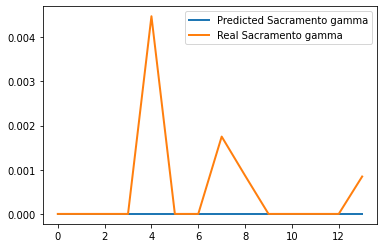

In [77]:
x = range(14)
y1 = mlp7dc_validp_gamma_Sacramento
y2 = valid_gamma_Sacramento
plt.plot(x, y1, ls="-", lw=2, label="Predicted Sacramento gamma")
plt.plot(x, y2, ls="-", lw=2, label="Real Sacramento gamma")
plt.legend()
plt.show()

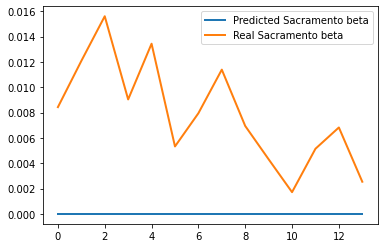

In [78]:
x = range(14)
y1 = mlp7dc_validp_beta_Sacramento
y2 = valid_beta_Sacramento
plt.plot(x, y1, ls="-", lw=2, label="Predicted Sacramento beta")
plt.plot(x, y2, ls="-", lw=2, label="Real Sacramento beta")
plt.legend()
plt.show()

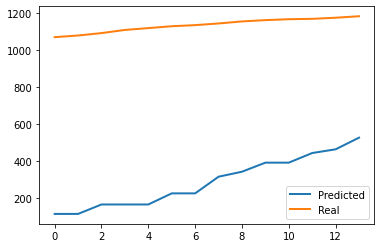

In [79]:
pred_vals = []
for i in range(14):
    pred_vals.append(mlp7dc_validp_case_vals[i][202])

x = range(14)
y1 = pred_vals
y2 = valid_labels_Sacramento
plt.plot(x, y1, ls="-", lw=2, label="Predicted")
plt.plot(x, y2, ls="-", lw=2, label="Real")
plt.legend()
plt.show()

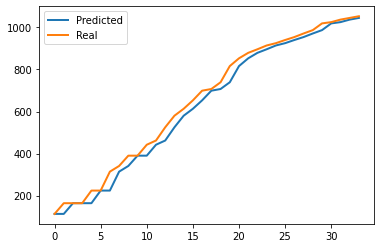

In [84]:
pred_vals = []
for i in range(34):
    pred_vals.append(mlp7dc_trainp_case_vals[i][202])

x = range(34)
y1 = pred_vals
y2 = train_labels_Sacramento
plt.plot(x, y1, ls="-", lw=2, label="Predicted")
plt.plot(x, y2, ls="-", lw=2, label="Real")
plt.legend()
plt.show()

### GAT - SIR

In [85]:
hidden_size = 100
learning_rate = 0.0000005
num_epochs = 1000
batch_size = 1000
output_size = 2

device = th.device('cuda:0')
input_size = train_past_cases[0].shape[1] + attrs.shape[1]
gat_sir = GAT_SIR(g, input_size, hidden_size, output_size, 1)
print('#features:', input_size)

# Move model to GPU
gat_sir = gat_sir.to(device)
# TODO we might want to choose a better loss.
# L2 loss will penalize the data points with larger deaths more. Is this what we want?
# criterion = criterion.to(device)

# Move data to GPU
pop = pop.to(device)
attrs = attrs.to(device)
for i in range(len(train_past_cases)):
    train_past_cases[i] = train_past_cases[i].to(device)
    train_past_deaths[i] = train_past_deaths[i].to(device)
    train_labels_cases[i] = train_labels_cases[i].to(device)
    train_labels_deaths[i] = train_labels_deaths[i].to(device)
    if len(train_labels_cases[i].shape) == 1:
        train_labels_cases[i] = train_labels_cases[i].unsqueeze(1)
    if len(train_labels_deaths[i].shape) == 1:
        train_labels_deaths[i] = train_labels_deaths[i].unsqueeze(1)
        
for i in range(len(valid_past_cases)):
    valid_past_cases[i] = valid_past_cases[i].to(device)
    valid_past_deaths[i] = valid_past_deaths[i].to(device)
    valid_labels_cases[i] = valid_labels_cases[i].to(device)
    valid_labels_deaths[i] = valid_labels_deaths[i].to(device)
    if len(valid_labels_cases[i].shape) == 1:
         valid_labels_cases[i] = valid_labels_cases[i].unsqueeze(1)
    if len(test_labels_deaths[i].shape) == 1:
        valid_labels_deaths[i] = valid_labels_deaths[i].unsqueeze(1)

for i in range(len(test_past_cases)):
    test_past_cases[i] = test_past_cases[i].to(device)
    test_past_deaths[i] = test_past_deaths[i].to(device)
    test_labels_cases[i] = test_labels_cases[i].to(device)
    test_labels_deaths[i] = test_labels_deaths[i].to(device)
    if len(test_labels_cases[i].shape) == 1:
        test_labels_cases[i] = test_labels_cases[i].unsqueeze(1)
    if len(test_labels_deaths[i].shape) == 1:
        test_labels_deaths[i] = test_labels_deaths[i].unsqueeze(1)
        
# Normalize attrs
attrs[th.isnan(attrs)] = 0
attr_mean = th.mean(attrs, dim=1, keepdim=True)
attrs = attrs - attr_mean
attr_std = th.std(attrs, dim=1, keepdim=True)
attrs = attrs / attr_std

optimizer = th.optim.Adam(gat_sir.parameters(), lr=learning_rate)
for epoch in range(num_epochs):
    losses = []
    for idx in range(19, len(train_past_cases)):
        labels_cases = train_labels_cases[idx]
        labels_deaths = train_labels_deaths[idx]
        batch = th.cat([train_past_cases[idx], attrs], dim=1)
        th.manual_seed(1)
        vals = gat_sir(batch)
        I = train_past_cases[idx][:,-1].view(3142,1)
        D = train_past_deaths[idx][:,-1].view(3142,1)
        I_new, D_new = sir_output(vals, I, D)
        loss = my_msle_ID(I_new, D_new, labels_cases, labels_deaths)
        loss.backward()
        optimizer.step()
        losses.append(loss.detach().cpu().numpy())
    
    with th.no_grad():
        eval_errs = []
        test_errs = []
        test_mses = []
        test_maes = []
        for idx in range(6):
            valid_feats = th.cat([valid_past_cases[idx], attrs], dim=1)
            eval_vals = gat_sir(valid_feats)
            eval_I = valid_past_cases[idx][:,-1].view(3142,1)
            eval_D = valid_past_deaths[idx][:,-1].view(3142,1)
            eval_labels_cases = valid_labels_cases[idx]
            eval_labels_deaths = valid_labels_deaths[idx]
            eval_I_new, eval_D_new = sir_output(eval_vals, eval_I, eval_D)
            err = my_msle_ID(eval_I_new, eval_D_new, eval_labels_cases, eval_labels_deaths)
            eval_errs.append(err.cpu().numpy())
            
            
            test_feats = th.cat([test_past_cases[idx], attrs], dim=1)
            test_vals = gat_sir(test_feats)
            test_I = test_past_cases[idx][:,-1].view(3142,1)
            test_D = test_past_deaths[idx][:,-1].view(3142,1)
            test_cases = test_labels_cases[idx]
            test_deaths = test_labels_deaths[idx]
            test_I_new, test_D_new = sir_output(test_vals, test_I, test_D)
            test_err = my_msle_ID(test_I_new, test_D_new, test_cases, test_deaths)
            test_mse = th.mean((test_I_new - test_labels_cases[idx])**2)
            test_mae = th.mean(th.abs(test_I_new - test_labels_cases[idx]))
            test_errs.append(test_err.cpu().numpy())
            test_mses.append(test_mse.cpu().numpy())
            test_maes.append(test_mae.cpu().numpy())
        print('epoch={}, loss={:.3f}, validation loss = {:.3f}, test loss={:.3f}, test mse = {:.3f}, test mae = {:.3f}'.format(epoch, np.mean(losses), np.mean(eval_errs), np.mean(test_errs), np.mean(test_mses), np.mean(test_maes)))

#features: 97
epoch=0, loss=2.319, validation loss = 1.814, test loss=1.980, test mse = 2345650.500, test mae = 118.209
epoch=1, loss=2.114, validation loss = 1.573, test loss=1.754, test mse = 2232254.250, test mae = 107.060
epoch=2, loss=1.927, validation loss = 1.363, test loss=1.524, test mse = 2154795.250, test mae = 99.170
epoch=3, loss=1.738, validation loss = 1.186, test loss=1.341, test mse = 2052828.375, test mae = 88.949
epoch=4, loss=1.532, validation loss = 1.045, test loss=1.174, test mse = 2018318.625, test mae = 84.683
epoch=5, loss=1.339, validation loss = 0.915, test loss=1.029, test mse = 2002240.625, test mae = 81.088
epoch=6, loss=1.150, validation loss = 0.811, test loss=0.888, test mse = 1437896.625, test mae = 67.611
epoch=7, loss=1.012, validation loss = 0.738, test loss=0.775, test mse = 891181.500, test mae = 55.495
epoch=8, loss=0.923, validation loss = 0.671, test loss=0.682, test mse = 457432.094, test mae = 43.364
epoch=9, loss=0.855, validation loss = 0.

epoch=79, loss=0.410, validation loss = 0.229, test loss=0.482, test mse = 30217.240, test mae = 28.673
epoch=80, loss=0.408, validation loss = 0.227, test loss=0.482, test mse = 30216.900, test mae = 28.664
epoch=81, loss=0.406, validation loss = 0.226, test loss=0.483, test mse = 30216.600, test mae = 28.655
epoch=82, loss=0.405, validation loss = 0.225, test loss=0.483, test mse = 30216.318, test mae = 28.647
epoch=83, loss=0.403, validation loss = 0.224, test loss=0.483, test mse = 30216.076, test mae = 28.638
epoch=84, loss=0.401, validation loss = 0.223, test loss=0.483, test mse = 30215.867, test mae = 28.630
epoch=85, loss=0.400, validation loss = 0.222, test loss=0.483, test mse = 30215.682, test mae = 28.622
epoch=86, loss=0.398, validation loss = 0.221, test loss=0.483, test mse = 30215.523, test mae = 28.614
epoch=87, loss=0.396, validation loss = 0.220, test loss=0.483, test mse = 30215.393, test mae = 28.606
epoch=88, loss=0.395, validation loss = 0.219, test loss=0.483, 

epoch=158, loss=0.336, validation loss = 0.182, test loss=0.486, test mse = 30219.432, test mae = 28.427
epoch=159, loss=0.335, validation loss = 0.182, test loss=0.487, test mse = 30219.463, test mae = 28.426
epoch=160, loss=0.335, validation loss = 0.182, test loss=0.487, test mse = 30219.502, test mae = 28.426
epoch=161, loss=0.335, validation loss = 0.182, test loss=0.487, test mse = 30219.533, test mae = 28.425
epoch=162, loss=0.334, validation loss = 0.181, test loss=0.487, test mse = 30219.562, test mae = 28.425
epoch=163, loss=0.334, validation loss = 0.181, test loss=0.487, test mse = 30219.588, test mae = 28.424
epoch=164, loss=0.334, validation loss = 0.181, test loss=0.487, test mse = 30219.619, test mae = 28.424
epoch=165, loss=0.333, validation loss = 0.181, test loss=0.487, test mse = 30219.648, test mae = 28.424
epoch=166, loss=0.333, validation loss = 0.181, test loss=0.487, test mse = 30219.678, test mae = 28.423
epoch=167, loss=0.333, validation loss = 0.180, test lo

epoch=237, loss=0.321, validation loss = 0.174, test loss=0.490, test mse = 30220.506, test mae = 28.410
epoch=238, loss=0.321, validation loss = 0.174, test loss=0.490, test mse = 30220.508, test mae = 28.409
epoch=239, loss=0.321, validation loss = 0.174, test loss=0.491, test mse = 30220.510, test mae = 28.409
epoch=240, loss=0.320, validation loss = 0.174, test loss=0.491, test mse = 30220.516, test mae = 28.409
epoch=241, loss=0.320, validation loss = 0.174, test loss=0.491, test mse = 30220.521, test mae = 28.409
epoch=242, loss=0.320, validation loss = 0.174, test loss=0.491, test mse = 30220.523, test mae = 28.409
epoch=243, loss=0.320, validation loss = 0.174, test loss=0.491, test mse = 30220.523, test mae = 28.409
epoch=244, loss=0.320, validation loss = 0.174, test loss=0.491, test mse = 30220.529, test mae = 28.409
epoch=245, loss=0.320, validation loss = 0.174, test loss=0.491, test mse = 30220.531, test mae = 28.409
epoch=246, loss=0.320, validation loss = 0.174, test lo

epoch=316, loss=0.318, validation loss = 0.173, test loss=0.494, test mse = 30220.635, test mae = 28.405
epoch=317, loss=0.318, validation loss = 0.173, test loss=0.494, test mse = 30220.635, test mae = 28.405
epoch=318, loss=0.318, validation loss = 0.173, test loss=0.494, test mse = 30220.635, test mae = 28.405
epoch=319, loss=0.318, validation loss = 0.173, test loss=0.494, test mse = 30220.635, test mae = 28.405
epoch=320, loss=0.318, validation loss = 0.173, test loss=0.494, test mse = 30220.635, test mae = 28.405
epoch=321, loss=0.318, validation loss = 0.173, test loss=0.494, test mse = 30220.639, test mae = 28.405
epoch=322, loss=0.318, validation loss = 0.173, test loss=0.494, test mse = 30220.639, test mae = 28.405
epoch=323, loss=0.318, validation loss = 0.173, test loss=0.494, test mse = 30220.639, test mae = 28.405
epoch=324, loss=0.318, validation loss = 0.173, test loss=0.494, test mse = 30220.641, test mae = 28.405
epoch=325, loss=0.318, validation loss = 0.173, test lo

epoch=395, loss=0.319, validation loss = 0.174, test loss=0.496, test mse = 30220.662, test mae = 28.403
epoch=396, loss=0.319, validation loss = 0.174, test loss=0.496, test mse = 30220.662, test mae = 28.403
epoch=397, loss=0.319, validation loss = 0.174, test loss=0.496, test mse = 30220.662, test mae = 28.403
epoch=398, loss=0.319, validation loss = 0.174, test loss=0.496, test mse = 30220.662, test mae = 28.403
epoch=399, loss=0.319, validation loss = 0.174, test loss=0.496, test mse = 30220.662, test mae = 28.403
epoch=400, loss=0.319, validation loss = 0.174, test loss=0.496, test mse = 30220.662, test mae = 28.403
epoch=401, loss=0.319, validation loss = 0.174, test loss=0.496, test mse = 30220.662, test mae = 28.403
epoch=402, loss=0.319, validation loss = 0.174, test loss=0.496, test mse = 30220.664, test mae = 28.403
epoch=403, loss=0.319, validation loss = 0.174, test loss=0.496, test mse = 30220.664, test mae = 28.403
epoch=404, loss=0.319, validation loss = 0.174, test lo

epoch=474, loss=0.320, validation loss = 0.174, test loss=0.498, test mse = 30220.670, test mae = 28.402
epoch=475, loss=0.320, validation loss = 0.174, test loss=0.498, test mse = 30220.670, test mae = 28.402
epoch=476, loss=0.320, validation loss = 0.174, test loss=0.498, test mse = 30220.670, test mae = 28.402
epoch=477, loss=0.320, validation loss = 0.174, test loss=0.498, test mse = 30220.670, test mae = 28.402
epoch=478, loss=0.320, validation loss = 0.174, test loss=0.498, test mse = 30220.670, test mae = 28.402
epoch=479, loss=0.320, validation loss = 0.174, test loss=0.498, test mse = 30220.670, test mae = 28.402
epoch=480, loss=0.320, validation loss = 0.174, test loss=0.498, test mse = 30220.670, test mae = 28.402
epoch=481, loss=0.320, validation loss = 0.174, test loss=0.498, test mse = 30220.670, test mae = 28.402
epoch=482, loss=0.320, validation loss = 0.174, test loss=0.498, test mse = 30220.670, test mae = 28.402
epoch=483, loss=0.320, validation loss = 0.174, test lo

epoch=553, loss=0.321, validation loss = 0.174, test loss=0.499, test mse = 30220.672, test mae = 28.401
epoch=554, loss=0.321, validation loss = 0.174, test loss=0.499, test mse = 30220.672, test mae = 28.401
epoch=555, loss=0.321, validation loss = 0.174, test loss=0.499, test mse = 30220.672, test mae = 28.401
epoch=556, loss=0.321, validation loss = 0.174, test loss=0.499, test mse = 30220.672, test mae = 28.401
epoch=557, loss=0.321, validation loss = 0.174, test loss=0.499, test mse = 30220.672, test mae = 28.401
epoch=558, loss=0.321, validation loss = 0.174, test loss=0.499, test mse = 30220.672, test mae = 28.401
epoch=559, loss=0.321, validation loss = 0.174, test loss=0.499, test mse = 30220.672, test mae = 28.401
epoch=560, loss=0.321, validation loss = 0.174, test loss=0.499, test mse = 30220.672, test mae = 28.401
epoch=561, loss=0.321, validation loss = 0.174, test loss=0.499, test mse = 30220.672, test mae = 28.401
epoch=562, loss=0.321, validation loss = 0.174, test lo

epoch=632, loss=0.322, validation loss = 0.174, test loss=0.500, test mse = 30220.678, test mae = 28.401
epoch=633, loss=0.322, validation loss = 0.174, test loss=0.500, test mse = 30220.678, test mae = 28.401
epoch=634, loss=0.322, validation loss = 0.174, test loss=0.500, test mse = 30220.678, test mae = 28.401
epoch=635, loss=0.322, validation loss = 0.174, test loss=0.500, test mse = 30220.678, test mae = 28.401
epoch=636, loss=0.322, validation loss = 0.174, test loss=0.500, test mse = 30220.678, test mae = 28.401
epoch=637, loss=0.322, validation loss = 0.174, test loss=0.500, test mse = 30220.678, test mae = 28.401
epoch=638, loss=0.322, validation loss = 0.174, test loss=0.500, test mse = 30220.678, test mae = 28.401
epoch=639, loss=0.322, validation loss = 0.174, test loss=0.500, test mse = 30220.678, test mae = 28.401
epoch=640, loss=0.322, validation loss = 0.174, test loss=0.500, test mse = 30220.678, test mae = 28.401
epoch=641, loss=0.322, validation loss = 0.174, test lo

epoch=711, loss=0.322, validation loss = 0.174, test loss=0.500, test mse = 30220.678, test mae = 28.400
epoch=712, loss=0.322, validation loss = 0.174, test loss=0.500, test mse = 30220.678, test mae = 28.400
epoch=713, loss=0.322, validation loss = 0.174, test loss=0.500, test mse = 30220.678, test mae = 28.400
epoch=714, loss=0.322, validation loss = 0.174, test loss=0.500, test mse = 30220.678, test mae = 28.400
epoch=715, loss=0.322, validation loss = 0.174, test loss=0.500, test mse = 30220.678, test mae = 28.400
epoch=716, loss=0.323, validation loss = 0.174, test loss=0.500, test mse = 30220.678, test mae = 28.400
epoch=717, loss=0.323, validation loss = 0.174, test loss=0.500, test mse = 30220.678, test mae = 28.400
epoch=718, loss=0.323, validation loss = 0.174, test loss=0.500, test mse = 30220.678, test mae = 28.400
epoch=719, loss=0.323, validation loss = 0.174, test loss=0.500, test mse = 30220.678, test mae = 28.400
epoch=720, loss=0.323, validation loss = 0.174, test lo

epoch=790, loss=0.323, validation loss = 0.174, test loss=0.501, test mse = 30220.678, test mae = 28.400
epoch=791, loss=0.323, validation loss = 0.174, test loss=0.501, test mse = 30220.678, test mae = 28.400
epoch=792, loss=0.323, validation loss = 0.174, test loss=0.501, test mse = 30220.678, test mae = 28.400
epoch=793, loss=0.323, validation loss = 0.174, test loss=0.501, test mse = 30220.678, test mae = 28.400
epoch=794, loss=0.323, validation loss = 0.174, test loss=0.501, test mse = 30220.678, test mae = 28.400
epoch=795, loss=0.323, validation loss = 0.174, test loss=0.501, test mse = 30220.678, test mae = 28.400
epoch=796, loss=0.323, validation loss = 0.174, test loss=0.501, test mse = 30220.678, test mae = 28.400
epoch=797, loss=0.323, validation loss = 0.174, test loss=0.501, test mse = 30220.678, test mae = 28.400
epoch=798, loss=0.323, validation loss = 0.174, test loss=0.501, test mse = 30220.678, test mae = 28.400
epoch=799, loss=0.323, validation loss = 0.174, test lo

epoch=869, loss=0.324, validation loss = 0.174, test loss=0.501, test mse = 30220.678, test mae = 28.400
epoch=870, loss=0.324, validation loss = 0.174, test loss=0.501, test mse = 30220.678, test mae = 28.400
epoch=871, loss=0.324, validation loss = 0.174, test loss=0.501, test mse = 30220.678, test mae = 28.400
epoch=872, loss=0.324, validation loss = 0.174, test loss=0.501, test mse = 30220.678, test mae = 28.400
epoch=873, loss=0.324, validation loss = 0.174, test loss=0.501, test mse = 30220.678, test mae = 28.400
epoch=874, loss=0.324, validation loss = 0.174, test loss=0.501, test mse = 30220.678, test mae = 28.400
epoch=875, loss=0.324, validation loss = 0.174, test loss=0.501, test mse = 30220.678, test mae = 28.400
epoch=876, loss=0.324, validation loss = 0.174, test loss=0.501, test mse = 30220.678, test mae = 28.400
epoch=877, loss=0.324, validation loss = 0.174, test loss=0.501, test mse = 30220.678, test mae = 28.400
epoch=878, loss=0.324, validation loss = 0.174, test lo

epoch=948, loss=0.324, validation loss = 0.174, test loss=0.501, test mse = 30220.680, test mae = 28.400
epoch=949, loss=0.324, validation loss = 0.174, test loss=0.501, test mse = 30220.680, test mae = 28.400
epoch=950, loss=0.324, validation loss = 0.174, test loss=0.501, test mse = 30220.680, test mae = 28.400
epoch=951, loss=0.324, validation loss = 0.174, test loss=0.501, test mse = 30220.680, test mae = 28.400
epoch=952, loss=0.324, validation loss = 0.174, test loss=0.501, test mse = 30220.680, test mae = 28.400
epoch=953, loss=0.324, validation loss = 0.174, test loss=0.501, test mse = 30220.680, test mae = 28.400
epoch=954, loss=0.324, validation loss = 0.174, test loss=0.501, test mse = 30220.680, test mae = 28.400
epoch=955, loss=0.324, validation loss = 0.174, test loss=0.501, test mse = 30220.680, test mae = 28.400
epoch=956, loss=0.324, validation loss = 0.174, test loss=0.501, test mse = 30220.680, test mae = 28.400
epoch=957, loss=0.324, validation loss = 0.174, test lo

In [86]:
with th.no_grad():
    gat7dc_trainp_R0_NYC = []
    gat7dc_trainp_R0_Sacramento = []
    gat7dc_trainp_gamma_NYC = []
    gat7dc_trainp_beta_NYC = []
    gat7dc_trainp_gamma_Sacramento = []
    gat7dc_trainp_beta_Sacramento = []
    gat7dc_trainp_case_vals = []
    gat7dc_trainp_death_vals = []
    for idx in range(len(train_past_cases_1d)):
        labels = train_labels_cases_1d[idx]
        batch = th.cat([train_past_cases_1d[idx], attrs], dim=1)
        vals = gat_sir(batch)
        gat7dc_trainp_gamma_NYC.append(vals[4][0])
        gat7dc_trainp_gamma_Sacramento.append(vals[202][0])
        gat7dc_trainp_beta_NYC.append(vals[4][1])
        gat7dc_trainp_beta_Sacramento.append(vals[202][1])
        R_NYC_div = th.div(vals[4][1],vals[4][0])
        R_Sacramento_div = th.div(vals[202][1],vals[202][0])
        gat7dc_trainp_R0_NYC.append(R_NYC_div)
        gat7dc_trainp_R0_Sacramento.append(R_Sacramento_div)  
        I = train_past_cases_1d[idx][:,-1].view(3142,1)
        D = train_past_deaths_1d[idx][:,-1].view(3142,1)
        I_new, D_new = sir_1d_output(vals, I, D)
        gat7dc_trainp_case_vals.append(I_new)
        gat7dc_trainp_death_vals.append(D_new)

    gat7dc_validp_R0_NYC = []
    gat7dc_validp_R0_Sacramento = []
    gat7dc_validp_gamma_NYC = []
    gat7dc_validp_beta_NYC = []
    gat7dc_validp_gamma_Sacramento = []
    gat7dc_validp_beta_Sacramento = []
    gat7dc_validp_case_vals = []
    gat7dc_validp_death_vals = []
    for idx in range(14):
        labels = valid_labels_cases_1d[idx]
        batch = th.cat([valid_past_cases_1d[idx], attrs], dim=1)
        vals = gat_sir(batch)
        gat7dc_validp_gamma_NYC.append(vals[4][0])
        gat7dc_validp_gamma_Sacramento.append(vals[202][0])
        gat7dc_validp_beta_NYC.append(vals[4][1])
        gat7dc_validp_beta_Sacramento.append(vals[202][1])
        R_NYC_div = th.div(vals[4][1],vals[4][0])
        R_Sacramento_div = th.div(vals[202][1],vals[202][0])
        gat7dc_validp_R0_NYC.append(R_NYC_div)
        gat7dc_validp_R0_Sacramento.append(R_Sacramento_div)  
        I = train_past_cases_1d[idx][:,-1].view(3142,1)
        D = train_past_deaths_1d[idx][:,-1].view(3142,1)
        I_new, D_new = sir_1d_output(vals, I, D)
        gat7dc_validp_case_vals.append(I_new)
        gat7dc_validp_death_vals.append(D_new)

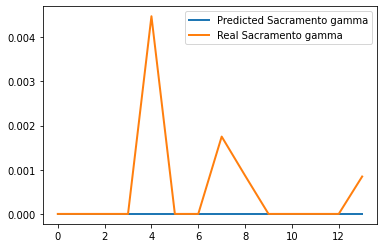

In [87]:
x = range(14)
y1 = gat7dc_validp_gamma_Sacramento
y2 = valid_gamma_Sacramento
plt.plot(x, y1, ls="-", lw=2, label="Predicted Sacramento gamma")
plt.plot(x, y2, ls="-", lw=2, label="Real Sacramento gamma")
plt.legend()
plt.show()

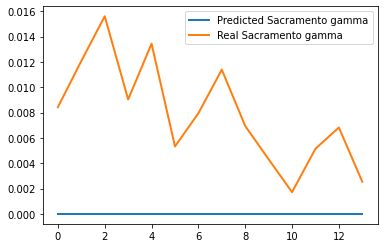

In [88]:
x = range(14)
y1 = gat7dc_validp_beta_Sacramento
y2 = valid_beta_Sacramento
plt.plot(x, y1, ls="-", lw=2, label="Predicted Sacramento gamma")
plt.plot(x, y2, ls="-", lw=2, label="Real Sacramento gamma")
plt.legend()
plt.show()

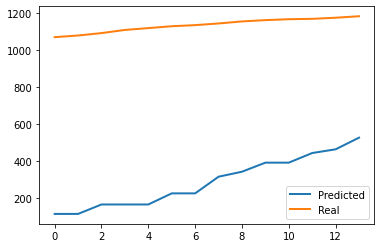

In [89]:
pred_vals = []
for i in range(14):
    pred_vals.append(gat7dc_validp_case_vals[i][202])

x = range(14)
y1 = pred_vals
y2 = valid_labels_Sacramento
plt.plot(x, y1, ls="-", lw=2, label="Predicted")
plt.plot(x, y2, ls="-", lw=2, label="Real")
plt.legend()
plt.show()

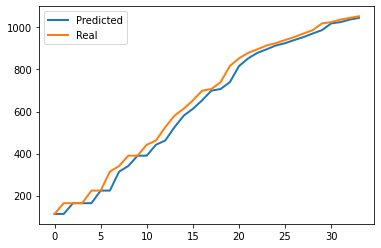

In [90]:
pred_vals = []
for i in range(34):
    pred_vals.append(gat7dc_trainp_case_vals[i][202])

x = range(34)
y1 = pred_vals
y2 = train_labels_Sacramento
plt.plot(x, y1, ls="-", lw=2, label="Predicted")
plt.plot(x, y2, ls="-", lw=2, label="Real")
plt.legend()
plt.show()

## Comparison

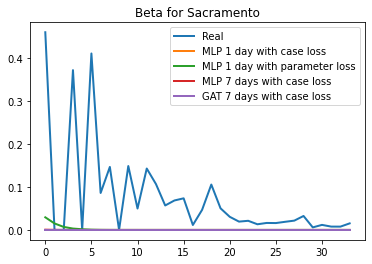

In [91]:
x = range(34)
y0 = train_beta_Sacramento
y1 = mlp1dc_trainp_beta_Sacramento
y2 = mlp1dp_trainp_beta_Sacramento
y3 = mlp7dc_trainp_beta_Sacramento
y4 = gat7dc_trainp_beta_Sacramento
plt.plot(x, y0, ls="-", lw=2, label="Real")
plt.plot(x, y1, ls="-", lw=2, label="MLP 1 day with case loss")
plt.plot(x, y2, ls="-", lw=2, label="MLP 1 day with parameter loss")
plt.plot(x, y3, ls="-", lw=2, label="MLP 7 days with case loss")
plt.plot(x, y4, ls="-", lw=2, label="GAT 7 days with case loss")
plt.title("Beta for Sacramento")
plt.legend()
plt.show()

In [103]:
beta_df = pd.DataFrame()
beta_df['Real'] = [i[0] for i in train_beta_Sacramento]
beta_df['MLP1D_C'] = [i.item() for i in mlp1dc_trainp_beta_Sacramento]
beta_df['MLP1D_P'] = [i.item() for i in mlp1dp_trainp_beta_Sacramento]
beta_df['GAT1D_C'] = [i.item() for i in gat1dc_trainp_beta_Sacramento]
beta_df['GAT1D_P'] = [i.item() for i in gat1dp_trainp_beta_Sacramento]
beta_df['MLP7D_C'] = [i.item() for i in mlp7dc_trainp_beta_Sacramento]
beta_df['GAT7D_C'] = [i.item() for i in gat7dc_trainp_beta_Sacramento]
beta_df

,Real,MLP1D_C,MLP1D_P,GAT1D_C,GAT1D_P,MLP7D_C,GAT7D_C
0,0.460212,8.421676e-13,2.933622e-02,0.0,0.0,5.606119e-04,1.377251e-26
1,0.000000,1.229229e-14,1.507194e-02,0.0,0.0,1.629648e-04,1.201623e-31
2,0.000000,3.276807e-17,6.952314e-03,0.0,0.0,4.671358e-05,4.979587e-37
3,0.371992,4.275272e-20,3.155829e-03,0.0,0.0,5.664115e-06,0.000000e+00
4,0.000000,5.152572e-22,1.543100e-03,0.0,0.0,1.525064e-06,0.000000e+00
5,0.410776,1.006317e-25,6.154000e-04,0.0,0.0,3.136173e-07,0.000000e+00
6,0.086005,7.486005e-29,2.149767e-04,0.0,0.0,1.305216e-08,0.000000e+00
7,0.146661,1.195815e-33,6.861942e-05,0.0,0.0,1.635662e-09,0.000000e+00
8,0.000000,1.091614e-38,1.409100e-05,0.0,0.0,3.237708e-11,0.000000e+00
9,0.148757,0.000000e+00,1.701726e-06,0.0,0.0,1.210912e-12,0.000000e+00


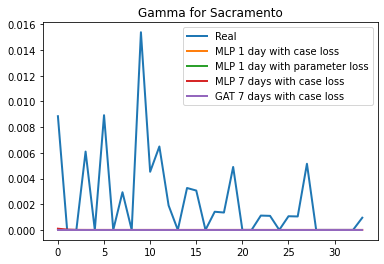

In [93]:
x = range(34)
y0 = train_gamma_Sacramento
y1 = mlp1dc_trainp_gamma_Sacramento
y2 = mlp1dp_trainp_gamma_Sacramento
y3 = mlp7dc_trainp_gamma_Sacramento
y4 = gat7dc_trainp_gamma_Sacramento
plt.plot(x, y0, ls="-", lw=2, label="Real")
plt.plot(x, y1, ls="-", lw=2, label="MLP 1 day with case loss")
plt.plot(x, y2, ls="-", lw=2, label="MLP 1 day with parameter loss")
plt.plot(x, y3, ls="-", lw=2, label="MLP 7 days with case loss")
plt.plot(x, y4, ls="-", lw=2, label="GAT 7 days with case loss")
plt.title("Gamma for Sacramento")
plt.legend()
plt.show()

In [104]:
gamma_df = pd.DataFrame()
gamma_df['Real'] = [i[0] for i in train_gamma_Sacramento]
gamma_df['MLP1D_C'] = [i.item() for i in mlp1dc_trainp_gamma_Sacramento]
gamma_df['MLP1D_P'] = [i.item() for i in mlp1dp_trainp_gamma_Sacramento]
gamma_df['GAT1D_C'] = [i.item() for i in gat1dc_trainp_gamma_Sacramento]
gamma_df['GAT1D_P'] = [i.item() for i in gat1dp_trainp_gamma_Sacramento]
gamma_df['MLP7D_C'] = [i.item() for i in mlp7dc_trainp_gamma_Sacramento]
gamma_df['GAT7D_C'] = [i.item() for i in gat7dc_trainp_gamma_Sacramento]
gamma_df

,Real,MLP1D_C,MLP1D_P,GAT1D_C,GAT1D_P,MLP7D_C,GAT7D_C
0,0.008850,0.0,8.737867e-25,0.0,0.0,9.419385e-05,7.999652e-32
1,0.000000,0.0,4.268639e-28,0.0,0.0,2.741231e-05,6.837539e-38
2,0.000000,0.0,1.197833e-33,0.0,0.0,3.979194e-06,0.000000e+00
3,0.006098,0.0,3.546848e-39,0.0,0.0,7.737696e-07,0.000000e+00
4,0.000000,0.0,0.000000e+00,0.0,0.0,1.039015e-07,0.000000e+00
5,0.008929,0.0,0.000000e+00,0.0,0.0,1.959630e-08,0.000000e+00
6,0.000000,0.0,0.000000e+00,0.0,0.0,1.104073e-09,0.000000e+00
7,0.002933,0.0,0.000000e+00,0.0,0.0,4.091419e-11,0.000000e+00
8,0.000000,0.0,0.000000e+00,0.0,0.0,4.886808e-13,0.000000e+00
9,0.015385,0.0,0.000000e+00,0.0,0.0,4.471290e-15,0.000000e+00
